# Construction of a prediction model for Covid19
## Part 2 of the notebook (for part one look at the fork of covidclinicaldata

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import eli5

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, plot_roc_curve
from sklearn.dummy import DummyClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from colorama import Fore #To pain the terminal with different colors
import warnings
warnings.filterwarnings('ignore') #To disable warnings
from IPython.display import display #To print a dataframe like the cell does

shap.initjs() #So shap values can be displayed inline

In [2]:
all_data = pd.read_csv("covid_clinical_data.csv", index_col=0)
all_data

covid19_test_results  age high_risk_exposure_occupation  \
0                 Negative    4                          True   
1                 Negative    2                         False   
2                 Negative    1                           NaN   
3                 Negative    3                          True   
4                 Negative    1                         False   
...                    ...  ...                           ...   
93989             Negative    3                         False   
93990             Negative    3                         False   
93991             Negative    3                         False   
93993             Negative    3                         False   
93994             Negative    2                         False   

      high_risk_interactions  diabetes    chd    htn  cancer  asthma  \
0                        NaN     False  False  False   False   False   
1                        NaN     False  False  False   False   False   
2                        NaN     False  False  False   False   False   
3                       True     False  False  False   False   False   
4                        NaN     False  False  False   False   False   
...                      ...       ...    ...    ...     ...     ...   
93989                   True     False  False  False   False   False   
93990                   True     False  False  False   False   False   
93991                  False     False  False  False   False   False   
93993                  False     False  False  False   False   False   
93994                  False     False  False  False   False   False   

       autoimmune_dis  ...    sob  sob_severity  diarrhea  fatigue  headache  \
0               False  ...  False           0.0     False    False     False   
1               False  ...  False           0.0     False    False     False   
2               False  ...    NaN           NaN       NaN      NaN       NaN   
3               False  ...   True           2.0     False     True     False   
4               False  ...  False           0.0     False    False     False   
...               ...  ...    ...           ...       ...      ...       ...   
93989           False  ...  False           0.0     False    False     False   
93990           False  ...  False           0.0     False    False     False   
93991           False  ...  False           0.0     False    False     False   
93993           False  ...  False           0.0     False    False     False   
93994           False  ...  False           0.0     False    False     False   

       loss_of_smell  loss_of_taste runny_nose muscle_sore sore_throat  
0              False          False      False       False       False  
1              False          False      False       False       False  
2                NaN            NaN        NaN         NaN         NaN  
3              False          False      False       False        True  
4              False          False      False       False       False  
...              ...            ...        ...         ...         ...  
93989          False          False      False       False       False  
93990          False          False       True       False        True  
93991          False          False      False       False       False  
93993          False          False      False       False       False  
93994          False          False      False       False       False  

[51695 rows x 35 columns]

In [3]:
X = all_data.iloc[:, 1:]
y = all_data["covid19_test_results"]

In [4]:
def create_different_datasets(data_x):
    e_factors = data_x.iloc[:,:3]
    comorbidities_data = data_x.iloc[:, 3:10] #The columns that contain the comorbidities
    vitals_data = data_x.iloc[:, 10:16] #The columns that contain the vitals
    assesed_symptoms_data = data_x.iloc[:, 16:21] #The columns that contain the assesed symptoms
    reported_symptoms_data = data_x.iloc[:,21:] #The columns that have the patient reported symptoms
    
    return e_factors, comorbidities_data, vitals_data, assesed_symptoms_data, reported_symptoms_data

In [5]:
e_factors, comorb, vitals, a_symptoms, r_symptoms = create_different_datasets(X)

<u>high_risk_exposure_occupation:</u> The most obvious thing to do is to just fill the 169 missing values with the most frequent value. However, it occurred to me that since we ultimately are willing to have (maybe even encourage) false positives, it might be better to just put the ones that tested positive as True and the rest as False. This would require that I split the dataset into training, validation and testing set before I do any imputation to avoid any target leakage (the effect when knowing the result before hand affects how are we imputing the variables). The step to be taken (if I were to follow that route) would be then to impute the training data that tested positive as True, the rest as False, and any incoming unknown data (validation and test data) as True if we dont know the value of the feature. I might need to run an experiment when I do both.

<u>high_risk_interaction:</u> This is easier than the previous one. We will just assign True to anything that has a 'high_risk_expossure_occupation' as True. The reasoning behind is is that if we don't know if the patient has had a high risk interaction, makes sense to say they did if their occupation is of high risk exposure.

In [6]:
def high_risk_exposure_imputation(data_x, data_y, target_imputation=False):    
    if target_imputation:
        mode = data_x[data_y == "Positive"].high_risk_exposure_occupation.mode()[0]
    else:
        mode = True
    data_x.loc[data_x["high_risk_exposure_occupation"].isna(), "high_risk_exposure_occupation"] = mode
    
    data_x.loc[data_x["high_risk_interactions"].isna(), "high_risk_interactions"] = data_x["high_risk_exposure_occupation"]

def vitals_imputation_generic(data_x):
    data = data_x.copy()
    data.loc[data["temperature"].isna(),"temperature"] = data["temperature"].mean()
    data.loc[data["pulse"].isna(),"pulse"] = data["pulse"].median()
    data.loc[data["rr"].isna(),"rr"] = data["rr"].median()
    data.loc[data["sats"].isna(),"sats"] = data["sats"].median()
    data.loc[data_x["pam"].isna(), "pam"] = data_x["pam"].mean()
    
    return data


In [7]:
def reduce_training_set(data_x, data_y):
    selected_negatives = data_x[data_y[data_x.index] == "Negative"].sample((data_y[data_x.index] == "Positive").sum())
    all_positives = data_x[data_y == "Positive"]
    #reduced_train_comorb = pd.merge(all_positives, selected_negatives) #Doesn't work well for reasons...
    reduced_data = pd.concat([all_positives, selected_negatives])

    return reduced_data

def specificity_score(*values):    
    cm = confusion_matrix(*values)    
    return cm[0][0] / (cm[0][0] + cm[0][1]) 


def get_metrics(*values):
    accuracy = accuracy_score(*values)
    recall = recall_score(*values, pos_label="Positive")
    precision = precision_score(*values, pos_label="Positive")
    f1 = f1_score(*values, pos_label="Positive")
    specificity = specificity_score(*values)
    return accuracy, recall, precision, specificity, f1 


In [8]:
class Imputer():
    
    def __init__(self):
        self.column_values = {}
        
    def fit_transform(self, data_x, data_y):
        self.fit(data_x, data_y)
        self.transform(data_x, training=True)
        
    def fit(self, data_x, data_y):
        self.get_high_risk_exposure_value(data_x, data_y)
        self.get_vitals_values(data_x)
        self.get_a_symptoms_values(data_x)
        self.get_r_symptoms_values(data_x)
        
    def transform(self, data_x, training=False):
        for feature in data_x.columns:           
            
            if feature in self.column_values:
                new_value = self.column_values[feature]
                
                if feature == "high_risk_exposure_occupation" and not training:
                    new_value=True
                    
                data_x.loc[data_x[feature].isna(), feature] = new_value
                
        if "high_risk_interactions" in data_x.columns: #Because this depends on 'high_risk_exposure_occupation being imputed first'
            data_x.loc[data_x["high_risk_interactions"].isna(), "high_risk_interactions"] = data_x["high_risk_exposure_occupation"]
        
        
        
    def get_high_risk_exposure_value(self, data_x, data_y):
        if "high_risk_exposure_occupation" in data_x.columns:
            self.column_values["high_risk_exposure_occupation"] = data_x[data_y == "Positive"].high_risk_exposure_occupation.mode()[0]

        
    def get_vitals_values(self, data_x):
        if "temperature" in data_x.columns:
            self.column_values["temperature"] =  data_x["temperature"].mean()
        if "pulse" in data_x.columns:
            self.column_values["pulse"] = data_x["pulse"].median()
        if "rr" in data_x.columns:
            self.column_values["rr"] = data_x["rr"].median()
        if "sats" in data_x.columns:
            self.column_values["sats"] = data_x["sats"].median()
        if "pam" in data_x.columns:
            self.column_values["pam"] =  data_x["pam"].mean()
            
    def get_a_symptoms_values(self, data_x):
        
        if "ctab" in data_x.columns:
            self.column_values["ctab"] = data_x["ctab"].mode()[0]
            
        if "labored_respiration" in data_x.columns:
            self.column_values["labored_respiration"] = data_x["labored_respiration"].mode()[0]
            
        if "rhonchi" in data_x.columns:
            self.column_values["rhonchi"] = data_x["rhonchi"].mode()[0]
            
        if "wheezes" in data_x.columns:
            self.column_values["wheezes"] = data_x["wheezes"].mode()[0]
            
        if "days_since_symptom_onset" in data_x.columns:
            self.column_values["days_since_symptom_onset"] = data_x["days_since_symptom_onset"].median()
            
    def get_r_symptoms_values(self, data_x):
        if "cough" in data_x.columns:
            self.column_values["cough"] = data_x["cough"].mode()[0]
            
        if "cough_severity" in data_x.columns:
            self.column_values["cough_severity"] = data_x["cough_severity"].mode()[0]
            
        if "fever" in data_x.columns:
            self.column_values["fever"] = data_x["fever"].mode()[0]
            
        if "sob" in data_x.columns:
            self.column_values["sob"] = data_x["sob"].mode()[0]
            
        if "sob_severity" in data_x.columns:
            self.column_values["sob_severity"] = data_x["sob_severity"].mode()[0]
        
        if "diarrhea" in data_x.columns:
            self.column_values["diarrhea"] = data_x["diarrhea"].mode()[0]
            
        if "fatigue" in data_x.columns:
            self.column_values["fatigue"] = data_x["fatigue"].mode()[0]
            
        if "headache" in data_x.columns:
            self.column_values["headache"] = data_x["headache"].mode()[0]
            
        if "loss_of_smell" in data_x.columns:
            self.column_values["loss_of_smell"] = data_x["loss_of_smell"].mode()[0]
            
        if "loss_of_taste" in data_x.columns:
            self.column_values["loss_of_taste"] = data_x["loss_of_taste"].mode()[0]
    
        if "runny_nose" in data_x.columns:
            self.column_values["runny_nose"] = data_x["runny_nose"].mode()[0]
            
        if "muscle_sore" in data_x.columns:
            self.column_values["muscle_sore"] = data_x["muscle_sore"].mode()[0]
            
        if "sore_throat" in data_x.columns:
            self.column_values["sore_throat"] = data_x["sore_throat"].mode()[0]

In [9]:
class XGBAdapter:
    
    def __init__(self, **params):
        self.model = XGBClassifier(**params, verbosity=0)
        
    def fit(self, data_x, data_y, sample_weight=None):
        self.model.fit(self.xgb_adapter(data_x), data_y, sample_weight=sample_weight)
        
    def predict(self, data_x):
        return self.model.predict(self.xgb_adapter(data_x))
    
    def predict_proba(self, data_x):
        return self.model.predict_proba(self.xgb_adapter(data_x))
    
    def score(self, X, y, sample_weight=None):
        return self.model.score(X, y, sample_weight=None)
    
    #This function is because xgb complains about 'object' type columns so I convert them all to boolean
    def xgb_adapter(self, data_x):
        result = data_x.copy()
        for column in result:
            if data_x[column].dtype == "object":
                result.loc[:,column] = result[column].astype("bool")
        return result

In [10]:
def calculate_shap_values(model, data_x):
    explainer = shap.KernelExplainer(model.predict_proba, np.zeros((1, data_x.shape[1])))
    sample = data_x.sample(1)
    display(shap.force_plot(explainer.expected_value[1], explainer.shap_values(sample)[1], sample))
    
def permutation_importance(model, X, Y, num_shuffles=50):
    feature_score_difference = np.full((len(X.columns), num_shuffles), 0, dtype=float)
    og_predictions = model.predict(X)
    og_error = accuracy_score(Y, og_predictions)
    for i in range(len(X.columns)): # Para cada feature
        feature = X.columns[i]
        shuffled_values = pd.DataFrame(X, copy = True) # Para que no afecte el dataset original solo copiamos los valores
        for j in range(num_shuffles):
            np.random.shuffle(shuffled_values[feature].values)
            col_preds = model.predict(shuffled_values)
            col_error = accuracy_score(Y, col_preds)
            feature_score_difference[i][j] = col_error - og_error # og tiene que ser mas pequeño
    result_table = np.array([feature_score_difference.mean(axis=1), feature_score_difference.std(axis=1)])
    
    df = pd.DataFrame(np.transpose(result_table), columns=["Importancia", "Desviacion estándar"], index=X.columns)
    return df.sort_values(by="Importancia", ascending = False)

In [23]:
def cross_validation_normal(data_x, data_y, model, folds, sample_weights=None):
    results = np.zeros((folds,2,5)) #Shape of folds, training and validation, and number of metrics
    if sample_weights is None:
        sample_weights = np.ones(data_y.shape)
       
    fold_size = data_x.shape[0] // folds
    reminder = data_x.shape[0] % folds    
    start = 0    
    imputer = Imputer()
    for i in range(folds):
        end = start + fold_size + (1 if reminder > 0 else 0)
        reminder-=1
        train_x = pd.concat([data_x.iloc[:start], data_x.iloc[end:]], axis=0)
        train_y = data_y.iloc[:start].append(data_y.iloc[end:])
        valid_x = data_x.iloc[start:end]
        valid_y = data_y.iloc[start:end]
                    
        imputer.fit_transform(train_x, train_y)
        imputer.transform(valid_x)
            
        model.fit(train_x, train_y, sample_weight=np.append(sample_weights[:start], sample_weights[end:]))
        train_v = (train_y, model.predict(train_x))
        valid_v = (valid_y, model.predict(valid_x))
        results[i,0] += get_metrics(*train_v)
        results[i,1] += get_metrics(*valid_v)
        start = end
        
        progress_bar = "╠" + str("■" * i) + str(" " * (folds -(i+1))) + "╣"
        print(progress_bar, end="\r")
    print("")    
       
    
    return results.mean(axis=0)



def cross_validation_class_ratios(data_x, data_y, model, folds, ratio_negatives_to_positives=1, class_threshold=.5, plot_roc=True, feature_importances=True):
    
    positive_index = data_y[data_y == "Positive"].index
    size_of_negatives = positive_index.shape[0] * ratio_negatives_to_positives
    
    fold_size = positive_index.shape[0] // folds
    results = np.zeros((folds,2,6)) #Shape of folds, training and validation, and number of metrics   
        
    reminder = positive_index.shape[0] % folds
    
    imputer = Imputer()
    start = 0    
    for i in range(folds):
        end = start + fold_size + (1 if reminder > 0 else 0)
        reminder-=1        
        training_positives = np.setdiff1d(positive_index, positive_index[start:end]) #The index of positives to be used as training set
                
        # Sample the size of negatives- the size of the fold negatives for training and concatenate with the corresponding indexes for the fold
        train_x = pd.concat([data_x[data_y == "Negative"].sample(size_of_negatives - fold_size), data_x.loc[training_positives]], axis=0) # 'loc' instead of 'iloc' because the indexes are treated as labels, not numbers
        train_y = data_y[train_x.index]
        valid_x = pd.concat([data_x[data_y == "Negative"].sample(fold_size * ratio_negatives_to_positives), data_x.loc[positive_index[start:end]]], axis=0) # 'loc' instead of 'iloc' because the indexes are treated as labels, not numbers
        valid_y = data_y[valid_x.index]
        
        imputer.fit_transform(train_x, train_y)
        imputer.transform(valid_x)
                    
        model.fit(train_x, train_y)
        
        ##The following lines are for predicting via probability
        t_pred_prob = model.predict_proba(train_x)[:,1] ## We choose '1' in predict_proba since that is the positive class
        v_pred_prob = model.predict_proba(valid_x)[:,1]  ## We choose '1' in predict_proba since that is the positive class      
               
        t_preds = np.zeros(train_x.shape[0], dtype = np.object)
        t_preds[t_pred_prob > class_threshold] = "Positive"
        t_preds[t_pred_prob <= class_threshold] = "Negative"
        
        v_preds = np.zeros(valid_x.shape[0], dtype = np.object)
        v_preds[v_pred_prob > class_threshold] = "Positive"
        v_preds[v_pred_prob <= class_threshold] = "Negative"
        
        ##End of probability calculations
        
        train_v = (train_y, t_preds) #original: insted of t_preds is model.predict
        valid_v = (valid_y, v_preds)  #original: insted of v_preds is model.predict
        results[i,0] += get_metrics(*train_v) + (roc_auc_score(train_y, t_pred_prob),) ## We add a comma to turn the result into a tuple so we can append it
        results[i,1] += get_metrics(*valid_v) + (roc_auc_score(valid_y, v_pred_prob),) ## We add a comma to turn the result into a tuple so we can append it
        start = end
        
        progress_bar = "╠" + str("■" * i) + str(" " * (folds -(i+1))) + "╣"
        print(progress_bar, end="\r")
                    
    print("")
    
    try:

        train_shap_x = pd.concat([data_x[data_y == "Negative"].sample((size_of_negatives - fold_size) // 2), data_x.loc[positive_index].sample((size_of_negatives - fold_size) // 2)], axis=0)
        
        test_shap_x = data_x.loc[np.setdiff1d(data_x.index.values, train_shap_x.index.values)].sample(fold_size)

        imputer.fit_transform(train_shap_x, data_y[train_shap_x.index])
        imputer.transform(test_shap_x)
        model.fit(train_shap_x, data_y[train_shap_x.index])
        
        
        if plot_roc:
            roc_values = roc_curve(data_y[test_shap_x.index], model.predict_proba(test_shap_x)[:,1], pos_label="Positive", drop_intermediate=False)
                      
            fig, ax = plt.subplots(1, 2, sharey=True, figsize=(21,7))
            
            ax[0].plot(roc_values[2], roc_values[0], 'b-', label="Recall")
            ax[0].plot(roc_values[2], roc_values[1], 'r-', label="FPR")
            ax[0].set(xlabel = "Thresholds")
            ax[0].legend()
            
             ## The following lines produce the same result as calling the 'sklearn.metrics.plot_roc_curve'
            ax[1].plot(roc_values[0], roc_values[1], 'b-')
            ax[1].set(xlabel = "FPR (1-specificity)", ylabel= "TPR (recall)")
            
            #plot_roc_curve(model, test_shap_x, data_y[test_shap_x.index], drop_intermediate=True)
            plt.show()
        
        if feature_importances:
            #explainer = shap.KernelExplainer(model.predict_proba, np.zeros((1, data_x.shape[1])))
            #sample = data_x.sample(fold_size)
            #display(shap.force_plot(explainer.expected_value[1], explainer.shap_values(sample)[1], sample))
            #display(permutation_importance(model, test_shap_x, y[test_shap_x.index], 5)) ## Doesn't seem to be working very well
            PI = eli5.sklearn.PermutationImportance(model)
            PI.fit(test_shap_x, data_y[test_shap_x.index])
            print("feature_importances")
            display(eli5.show_weights(model, feature_names=list(data_x.columns)))
            print("Permutation Importance")
            display(eli5.show_weights(PI, feature_names=list(data_x.columns)))
        
    except Exception as e:
        print(e)
    
    
    return results.mean(axis=0)

def run_threshold(data_x, data_y, model, thresholds=np.linspace(0,1, num=11), folds=10, ratio_negatives_to_positives=1):
    
    threshold_scores = np.zeros((5,thresholds.shape[0]))
    i = 0 #the threshold index im in
    for t in thresholds:
        
        
        results = cross_validation_class_ratios(data_x, data_y, model, folds, ratio_negatives_to_positives=1, class_threshold=t, plot_roc=False, feature_importances=False)
        print("Threshold:", t)       
        
        for metric in range(5):
            threshold_scores[metric,i] = results[1][metric]      
        i+=1
    
    plt.figure(figsize=(21,7))
    plt.plot(thresholds, threshold_scores[0], label="Accuracy")
    plt.plot(thresholds, threshold_scores[1], label="Recall")
    plt.plot(thresholds, threshold_scores[2], label="Precision")
    plt.plot(thresholds, threshold_scores[3], label="Specificity")
    plt.plot(thresholds, threshold_scores[4], label="F1 score")
    plt.legend()
    plt.show()
    
    display(pd.DataFrame(threshold_scores, index=["Accuracy", "Recall", "Precision", "Specificity", "F1"], columns=thresholds))
        
def run_models(data_x, data_y, models, folds=10, ratio_negatives_to_positives=-1, sample_weights=None):
    for model in models:
        print(Fore.RED, model, Fore.BLACK, sep="")
        try:
            if(ratio_negatives_to_positives >= 1):            
                results = cross_validation_class_ratios(data_x, data_y, models[model], folds, ratio_negatives_to_positives)
            else:
                results = cross_validation_normal(data_x, data_y, models[model], folds, sample_weights)    

            display(pd.DataFrame(results, index=["Training", "Validation"], columns=["Accuracy", "Recall", "Precision", "Specificity", "F1", "ROC_AUC"]))
            print("")
        except Exception as e:
            print(e)

In [20]:
models ={
    "Dummy Random" : DummyClassifier(strategy="uniform"), #does not have predict_proba
    "MultinomialNB" : MultinomialNB(alpha=0, class_prior=(.5, .5)),
    "Random Forest (100 estimators)" : RandomForestClassifier(min_samples_leaf=100),
    "XGBoost Classifier" : XGBAdapter(n_estimators=500),
    "SVM" : SVC(kernel='linear', probability=True), 
    "KNN" : KNeighborsClassifier(n_neighbors=100, weights="distance"), 
    "Logistic Regression" : LogisticRegression()
}

<i>Note: I tried to calculate data with the imbalanced datasets (cross validation with all positive and negative examples) and discovered that it didn't work so I deleted those experiments so the notebook looks cleaner with the ones that count</i>


Next step to either add more features or... implement a cross validation method that makes up for the difference between positives and negatives

In [21]:
comorb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51695 entries, 0 to 93994
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   diabetes        51695 non-null  bool 
 1   chd             51695 non-null  bool 
 2   htn             51695 non-null  bool 
 3   cancer          51695 non-null  bool 
 4   asthma          51695 non-null  bool 
 5   autoimmune_dis  51695 non-null  bool 
 6   smoker          51695 non-null  bool 
dtypes: bool(7)
memory usage: 2.8 MB


Dummy Random
╠■■■■■■■■■╣


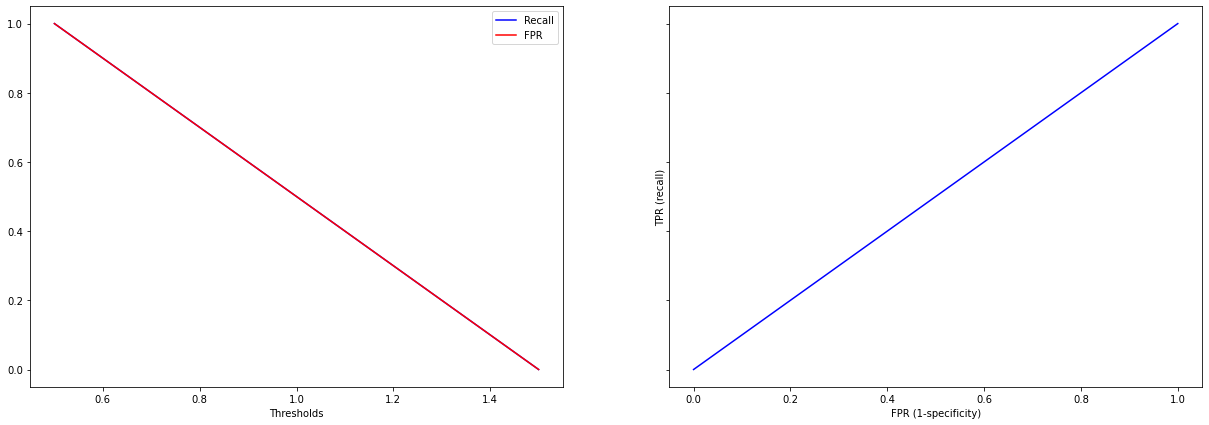

feature_importances


Permutation Importance


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500045     0.0        0.0          1.0  0.0      0.5
Validation  0.499592     0.0        0.0          1.0  0.0      0.5


MultinomialNB
╠■■■■■■■■■╣


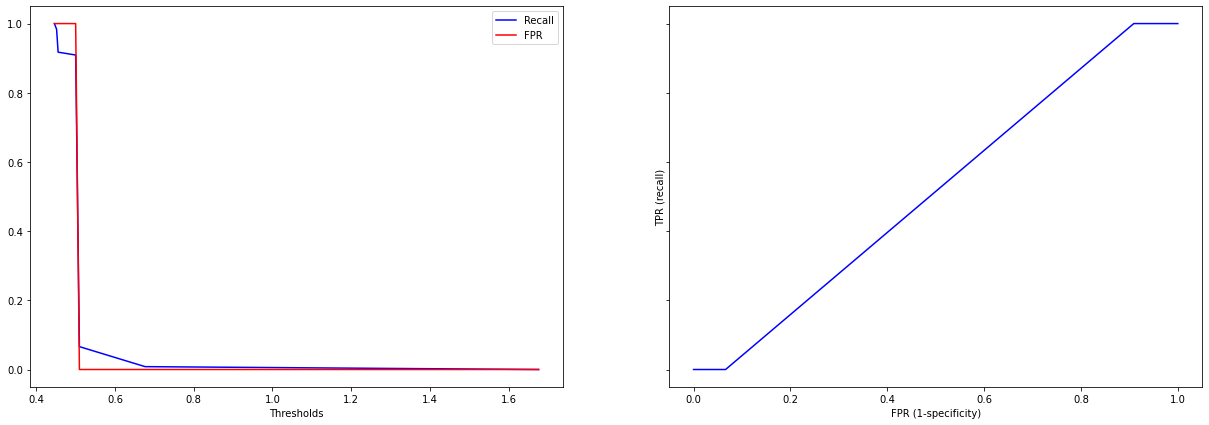

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.505864  0.068192   0.568099     0.943455  0.119454  0.516356
Validation  0.496725  0.062995   0.464879     0.931148  0.108504  0.512573


Random Forest (100 estimators)
╠■■■■■■■■■╣


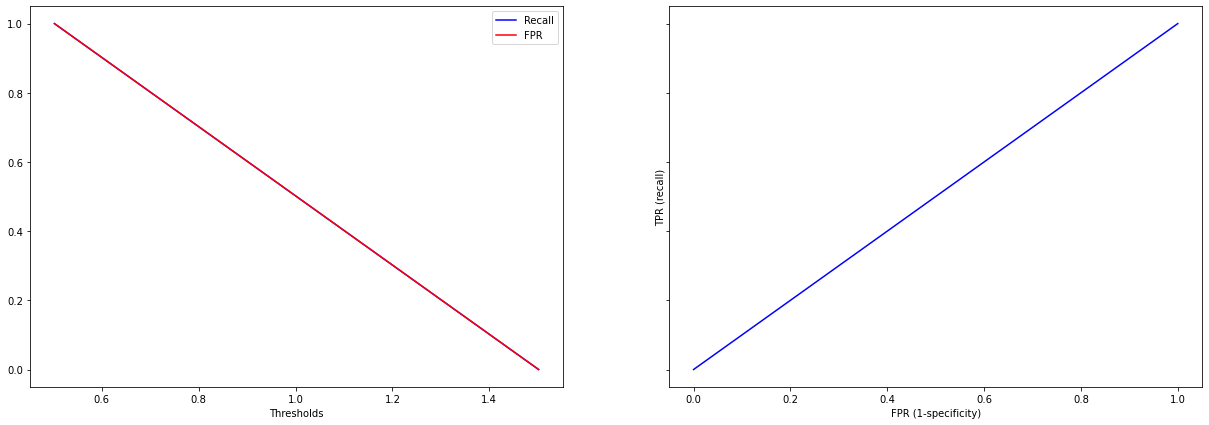

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.501545  0.572273   0.300808     0.430727  0.394223  0.502585
Validation  0.500002  0.574590   0.300145     0.426230  0.394213  0.498017


XGBoost Classifier
╠■■■■■■■■■╣


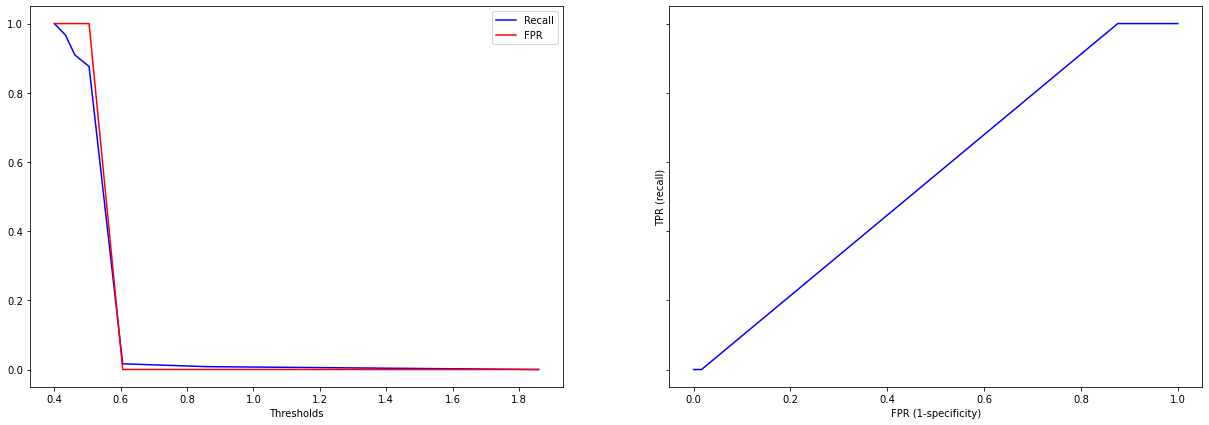

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.515138  0.819071   0.511978     0.211273  0.605191  0.523679
Validation  0.513101  0.810836   0.504037     0.214754  0.598534  0.512223


SVM
╠■■■■■■■■■╣


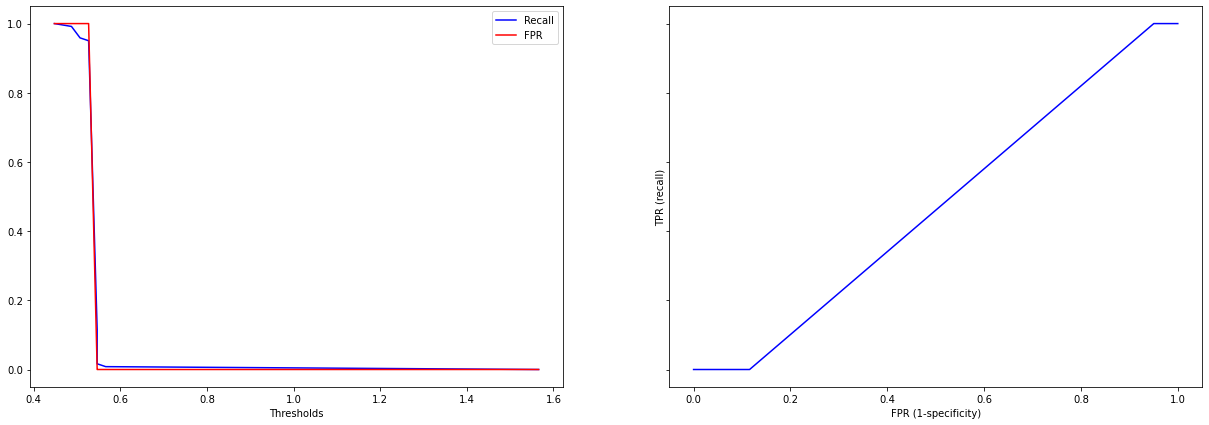

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.497681  0.303189   0.308948     0.692091  0.230167  0.494755
Validation  0.482389  0.281934   0.208338     0.683607  0.208378  0.478924


KNN
╠■■■■■■■■■╣


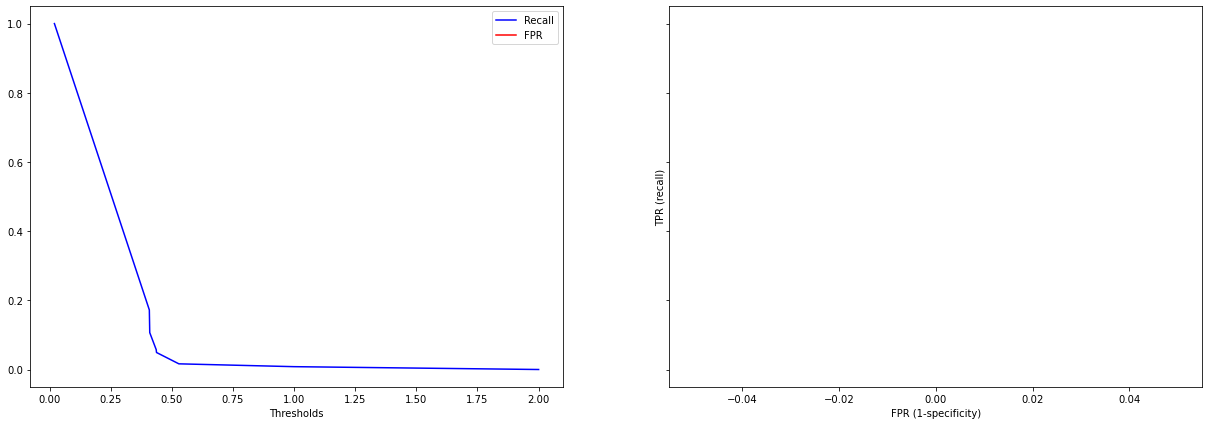

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.510046  0.047646   0.681818     0.972364  0.087007  0.501248
Validation  0.504510  0.035999   0.673506     0.973770  0.067119  0.504309


Logistic Regression
╠■■■■■■■■■╣


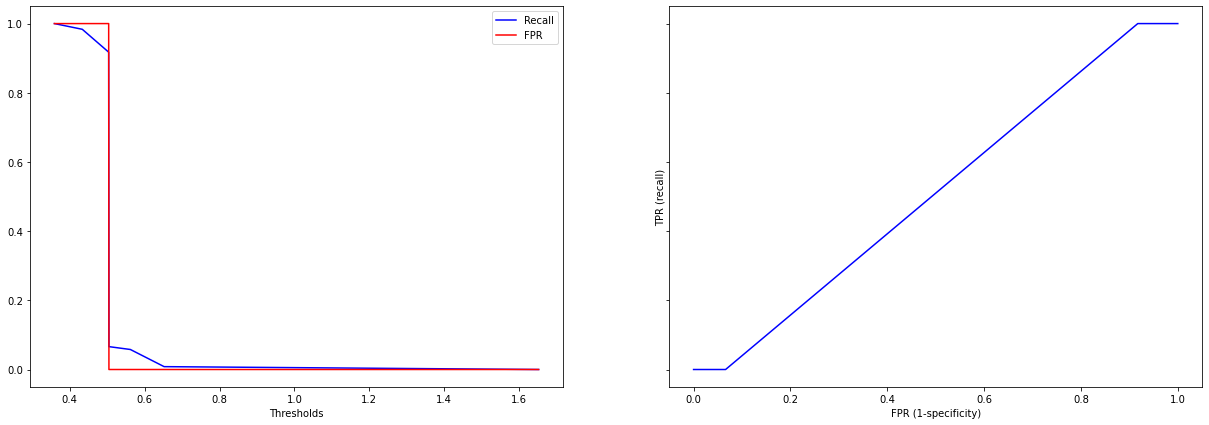

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.516320  0.887793   0.509341     0.144909  0.647155  0.522015
Validation  0.501624  0.886272   0.501122     0.116393  0.639950  0.501952

In [24]:
run_models(comorb, y[comorb.index], models, ratio_negatives_to_positives = 1)

Most of the models don't do better than random guessing (the metric we want to optimize is recall; however, since the data is being undersampled to combat the class imbalance, Accuracy is a good metric to keep an eye on as well). <b>Asthma</b>, <b>Smoker</b> and <b>Diabetes</b> seem to be the most prominent features, although they don't seem to be consistent (they change every time I run the cell again).

Dummy Random
╠■■■■■■■■■╣


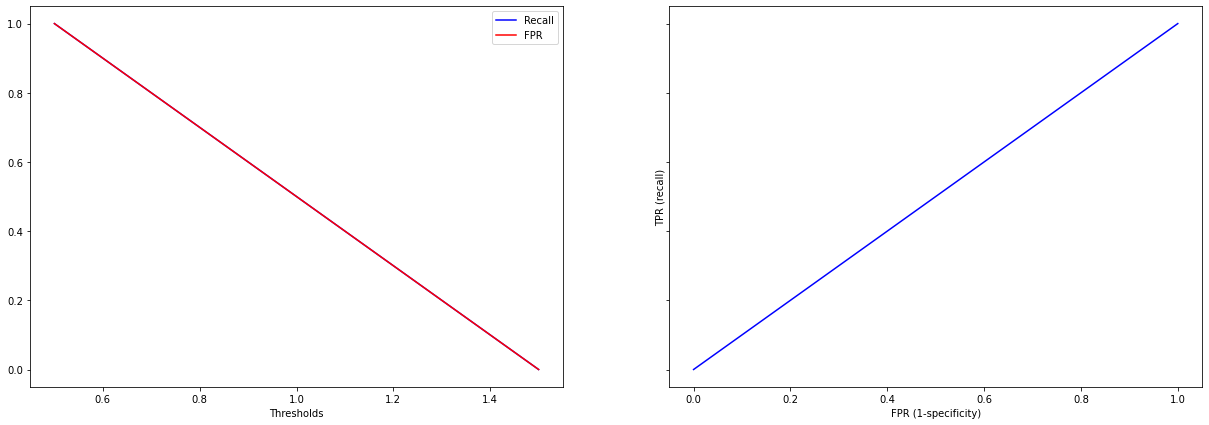

feature_importances


Permutation Importance


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500045     0.0        0.0          1.0  0.0      0.5
Validation  0.499592     0.0        0.0          1.0  0.0      0.5


MultinomialNB
╠■■■■■■■■■╣


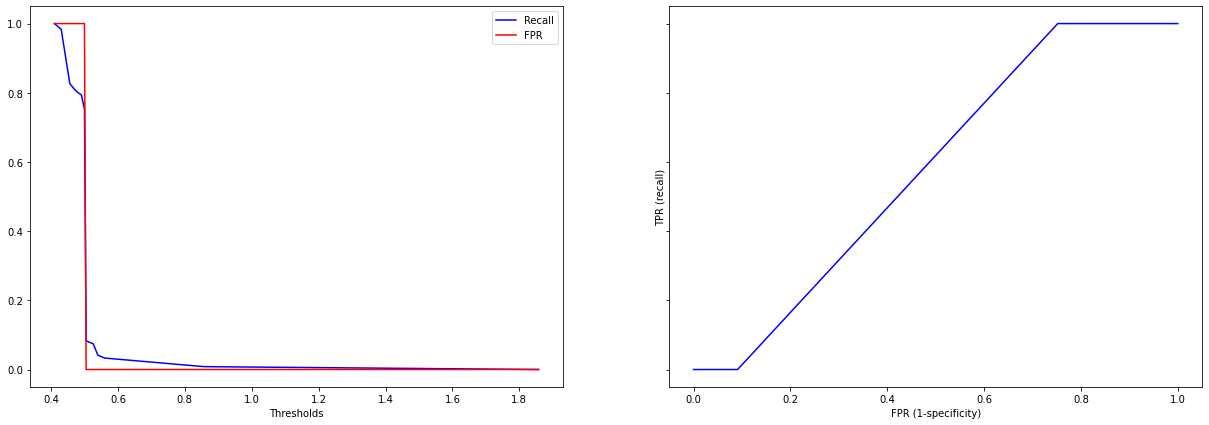

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.526002  0.191489   0.580012     0.860455  0.287138  0.558291
Validation  0.519192  0.193769   0.542550     0.845082  0.282413  0.547295


Random Forest (100 estimators)
╠■■■■■■■■■╣


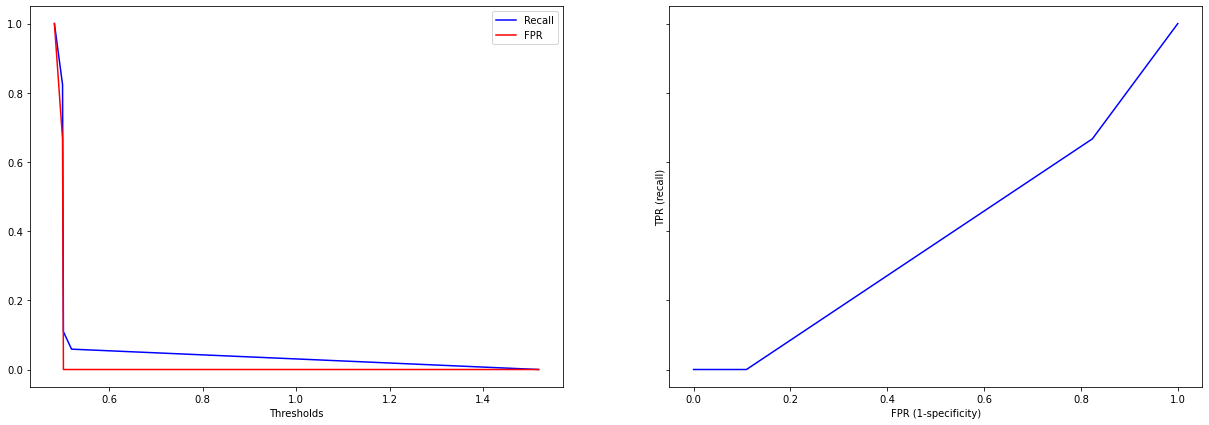

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.530320  0.445114    0.56799     0.615455  0.416407  0.552186
Validation  0.510217  0.425943    0.52846     0.595082  0.389850  0.521335


XGBoost Classifier
╠■■■■■■■■■╣


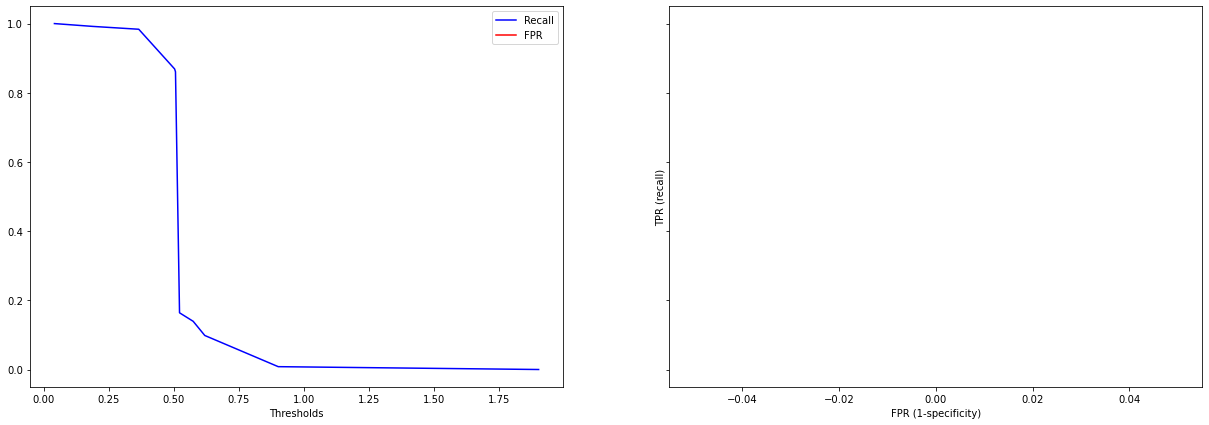

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.548186  0.790067   0.537202     0.306364  0.622768  0.572278
Validation  0.519647  0.767460   0.505332     0.271311  0.597488  0.536050


SVM
╠■■■■■■■■■╣


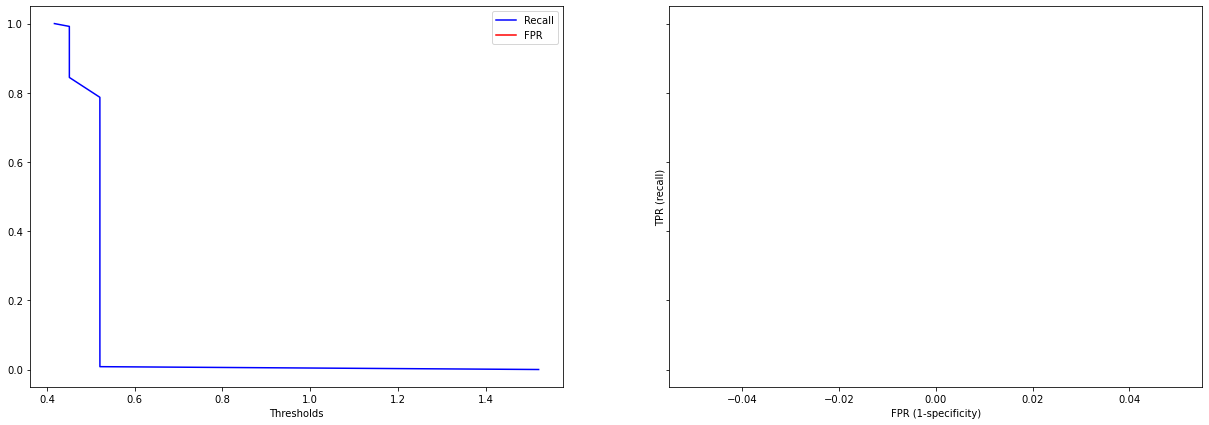

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.532139  0.310547   0.591111     0.753727  0.351188  0.556215
Validation  0.511074  0.273877   0.561578     0.748361  0.310115  0.527020


KNN
╠■■■■■■■■■╣


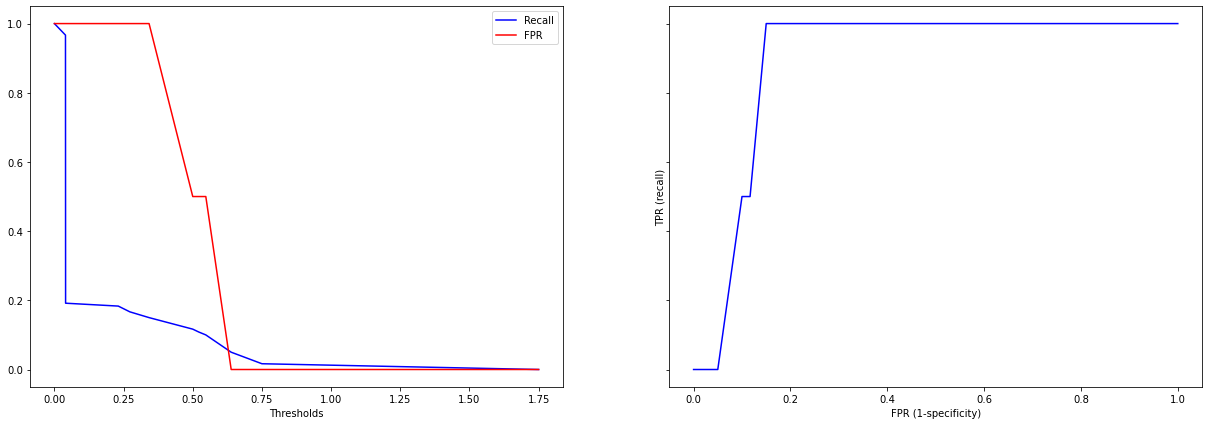

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.520547  0.072194   0.725746     0.968818  0.126360  0.549805
Validation  0.504503  0.052346   0.549246     0.957377  0.092284  0.530863


Logistic Regression
╠■■■■■■■■■╣


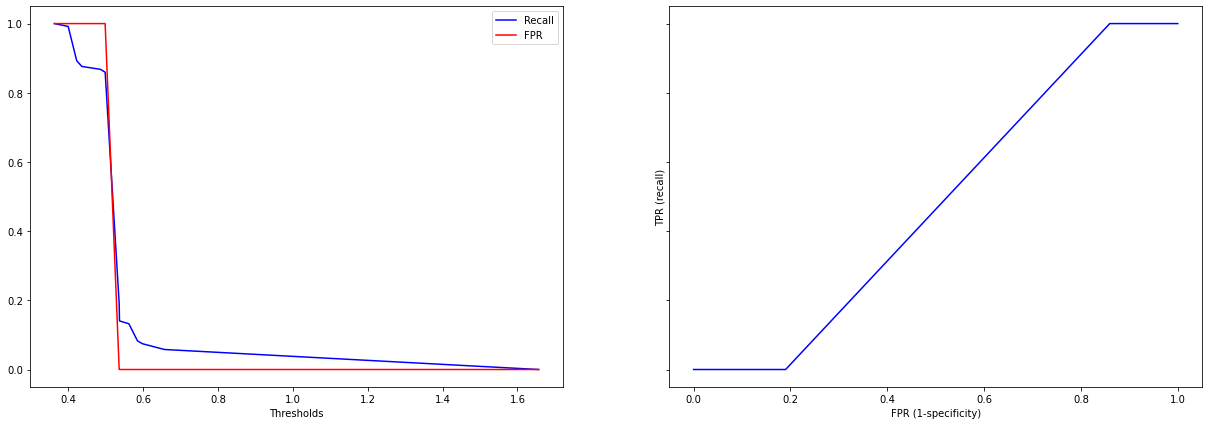

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.540913  0.597881   0.555172     0.484000  0.517846  0.561449
Validation  0.527002  0.561722   0.520215     0.491803  0.479863  0.561707

In [25]:
comorb_ef = pd.concat([comorb.drop(columns="smoker"), e_factors.drop(columns="age")], axis=1)
run_models(comorb_ef, y[comorb_ef.index], models, ratio_negatives_to_positives = 1)

We definetley need another set, even though using the cross validation for data imbalancing helped a lot. <b>High risk exposure occupation</b> seems to be the mosto important feature from epidemiological factors

### Vitals

$ PAM = DIA + \frac{SIS-DIA}{3}$<br>
where PAM = Presión arterial media
SIS = Sístole
DIA = Diástole

In [16]:
def calculate_pam(data_x):
    return vitals["dia"] + ((vitals["sys"] - vitals["dia"])/3)

In [17]:
pam = vitals["dia"] + ((vitals["sys"] - vitals["dia"])/3)
vitals = pd.concat([vitals, pam], axis=1)
vitals.rename({ 0 : "pam"}, axis=1,inplace =True) #To rename the column that was appended (which has a value of 0 that is not a string)
i = vitals[vitals.iloc[:,-1] >145].iloc[:,-1].index
pd.concat([vitals.loc[i, ["sys", "dia"]], e_factors.loc[i,"age"]], axis=1)

sys    dia  age
5135   195.0  135.0    4
6106   215.0  115.0    4
9058   200.0  120.0    3
11792  190.0  130.0    3
14314  205.0  125.0    4
19137  215.0  117.0    4
20168  190.0  130.0    4
20379  220.0  140.0    4
20582  200.0  118.0    4
28579  180.0  130.0    3
31555  185.0  130.0    3
31880  180.0  135.0    2
33497  210.0  120.0    4
36197  190.0  135.0    3
36239  185.0  135.0    3
45860  220.0  115.0    3
48067  190.0  130.0    4
50607  220.0  108.0    4
75219  195.0  130.0    2
76797  195.0  130.0    1
77724  190.0  135.0    2
91625  210.0  125.0    3
93508  200.0  118.0    4

As expected, all pressure variables (including pam) are correlated between each other

In [18]:
#Drop all values that are Nan
vitals.dropna(how="all",inplace=True)
vitals.drop(columns=["sys", "dia"], inplace=True) #Because we have 'pam' we don't need it anymore (I ran some experiments and it is sligthly better with 'pam')
vitals.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48705 entries, 0 to 93994
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  46961 non-null  float64
 1   pulse        47666 non-null  float64
 2   rr           40972 non-null  float64
 3   sats         46959 non-null  float64
 4   pam          45990 non-null  float64
dtypes: float64(5)
memory usage: 2.2 MB


<AxesSubplot:>

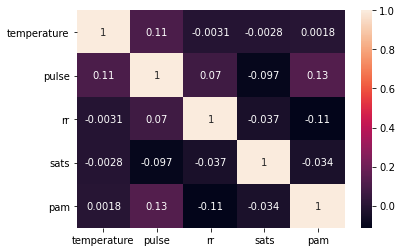

In [19]:
sns.heatmap(vitals.corr(), annot=True)

In [20]:
s_vitals = vitals.copy()
s_vitals = s_vitals.apply(lambda x: (x - x.mean()) / x.std())
n_vitals = vitals.copy()
n_vitals = s_vitals.apply(lambda x: (x - x.min()) / (x.max() - x.min()))

Dummy Random
╠■■■■■■■■■╣


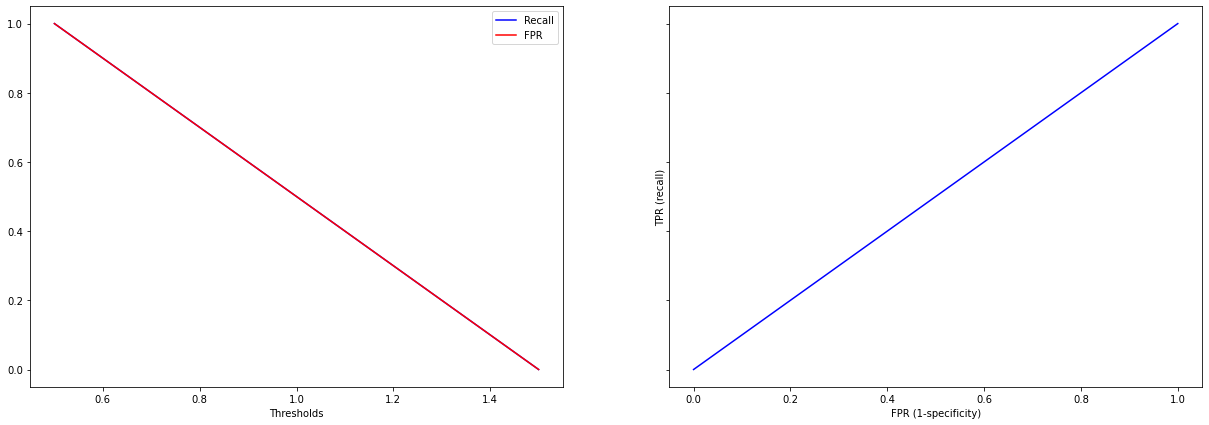

feature_importances


Permutation Importance


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500227     0.0        0.0          1.0  0.0      0.5
Validation  0.497945     0.0        0.0          1.0  0.0      0.5


MultinomialNB
╠■■■■■■■■■╣


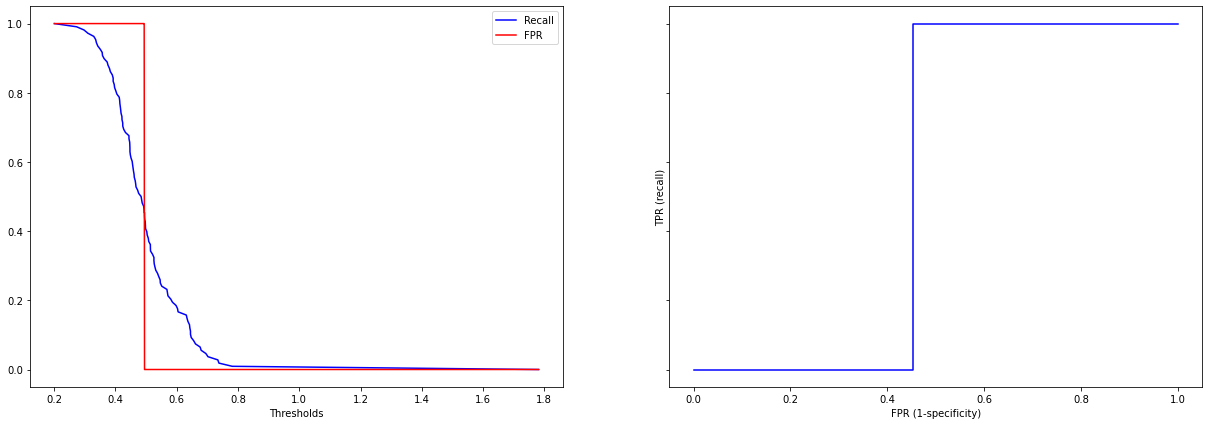

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.565762  0.533919   0.570030     0.597576  0.551366  0.596486
Validation  0.566928  0.527773   0.573739     0.606422  0.547886  0.598528


Random Forest (100 estimators)
╠■■■■■■■■■╣


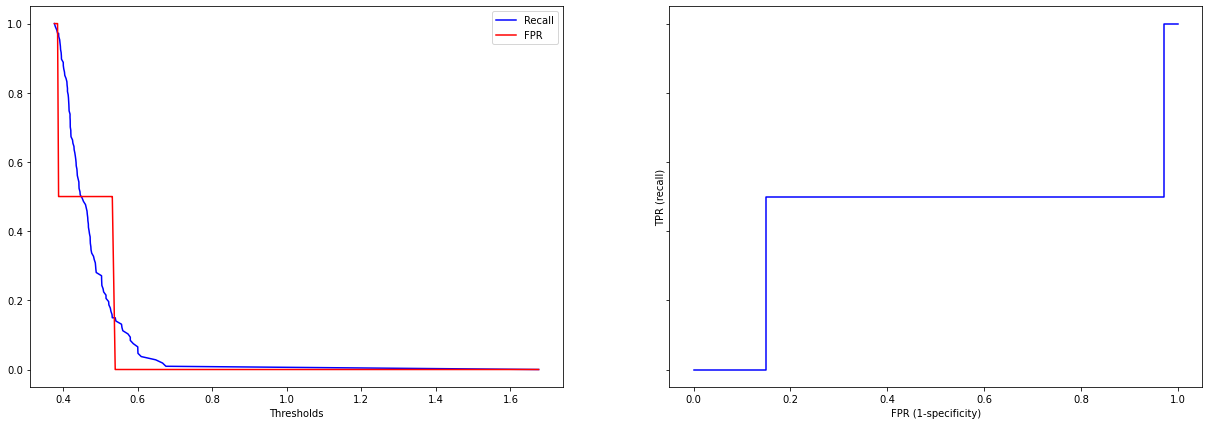

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.610024  0.580019   0.617322     0.640000  0.597561  0.663418
Validation  0.588385  0.549650   0.596353     0.627523  0.568904  0.636730


XGBoost Classifier
╠■■■■■■■■■╣


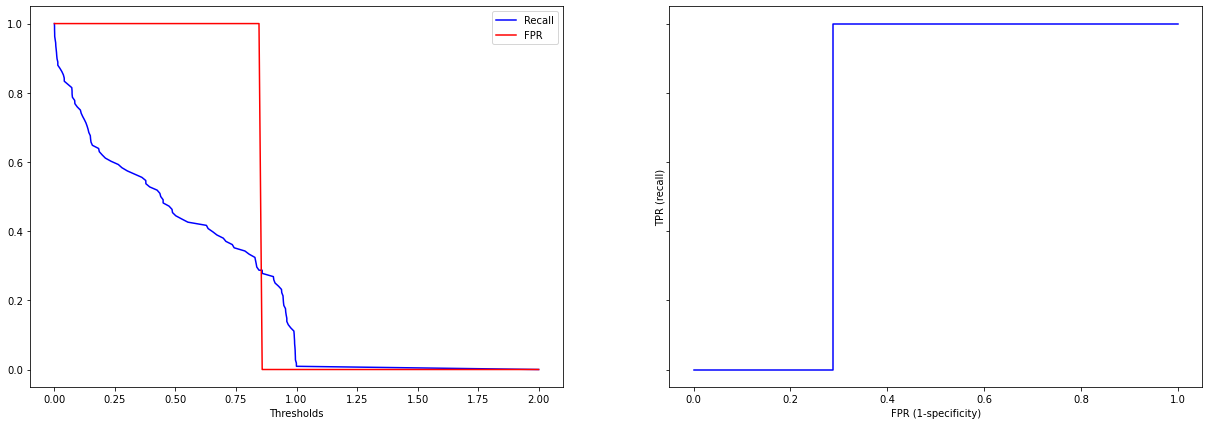

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.997878  0.997675   0.998079     0.998081  0.997876  0.999985
Validation  0.562364  0.569625   0.563950     0.555046  0.565946  0.590461


SVM
╠■■■■■■■■■╣


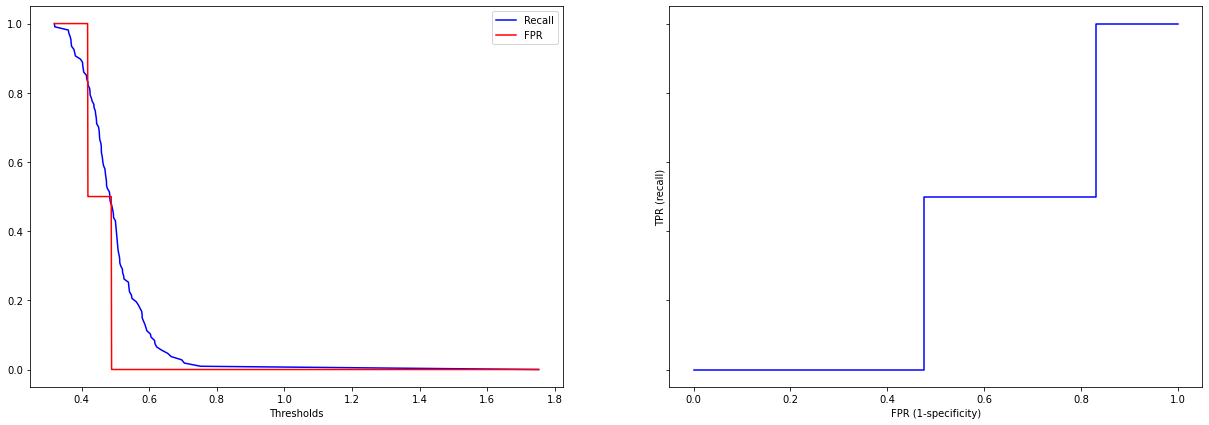

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.591379  0.533918   0.602991     0.648788  0.566327  0.636904
Validation  0.580661  0.522402   0.589009     0.639450  0.551538  0.629635


KNN
╠■■■■■■■■■╣


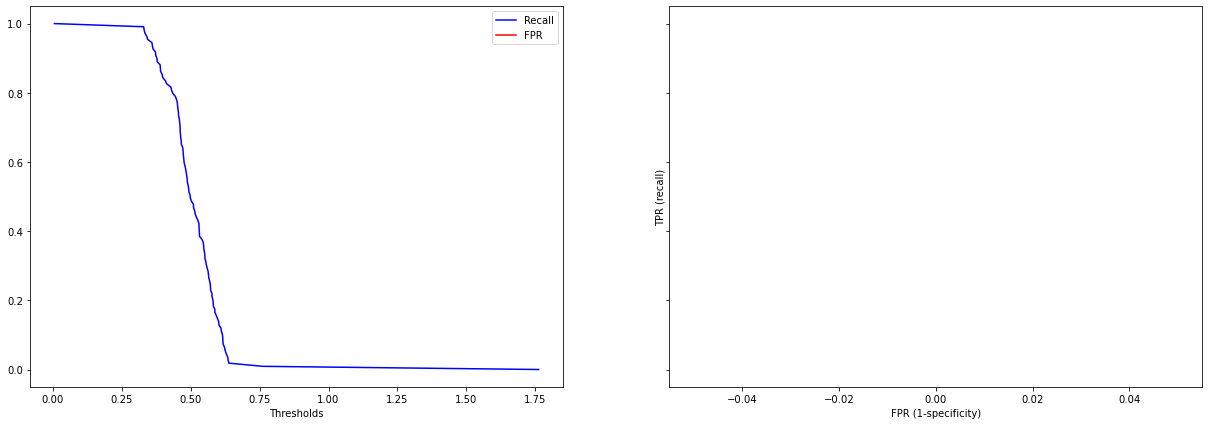

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.998434  0.997169   0.999696     0.999697  0.998430  0.999993
Validation  0.552319  0.571418   0.552003     0.533028  0.560447  0.590073


Logistic Regression
╠■■■■■■■■■╣


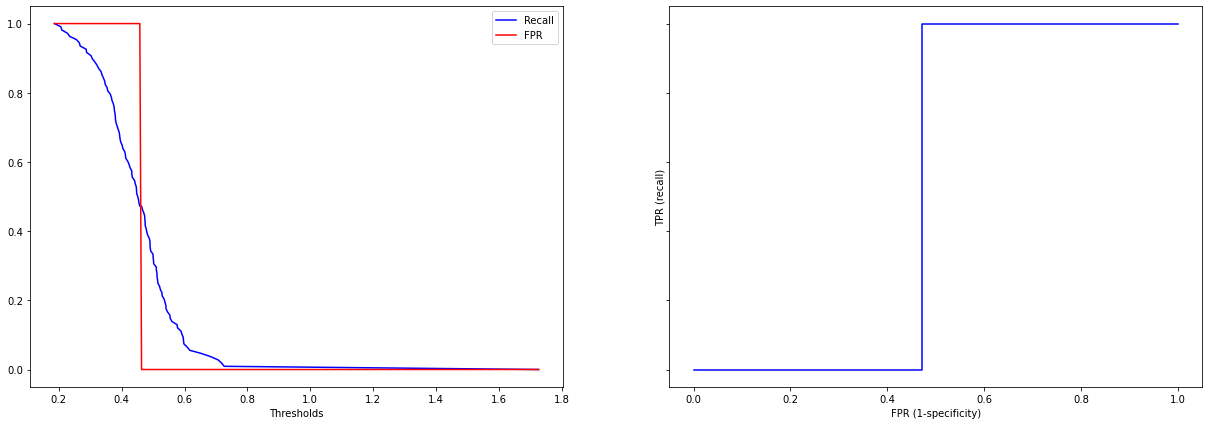

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.592139  0.559400   0.598347     0.624848  0.578206  0.636858
Validation  0.578373  0.554212   0.580842     0.602752  0.564948  0.614636

In [21]:
run_models(vitals, y[vitals.index], models, ratio_negatives_to_positives=1)

Dummy Random
╠■■■■■■■■■╣


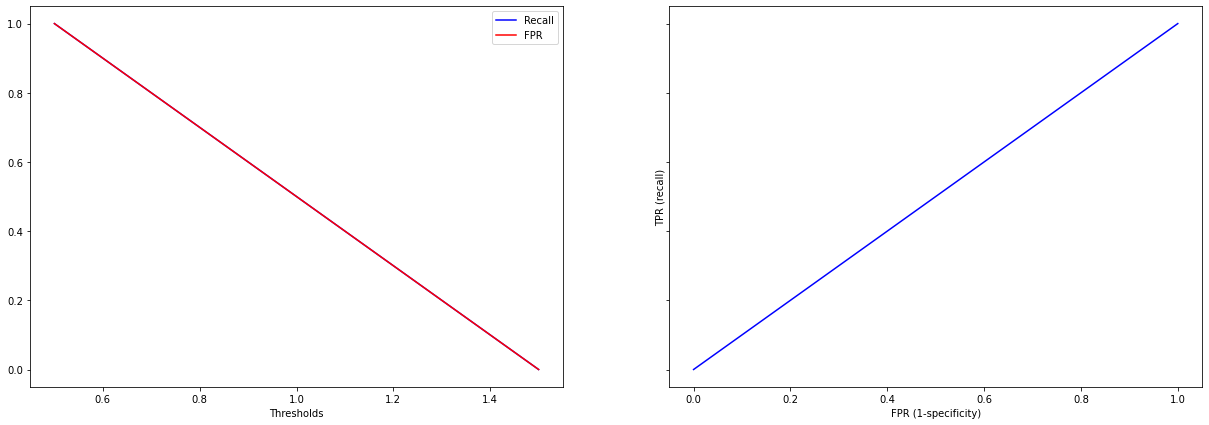

feature_importances


Permutation Importance


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500227     0.0        0.0          1.0  0.0      0.5
Validation  0.497945     0.0        0.0          1.0  0.0      0.5


MultinomialNB
Negative values in data passed to MultinomialNB (input X)
Random Forest (100 estimators)
╠■■■■■■■■■╣


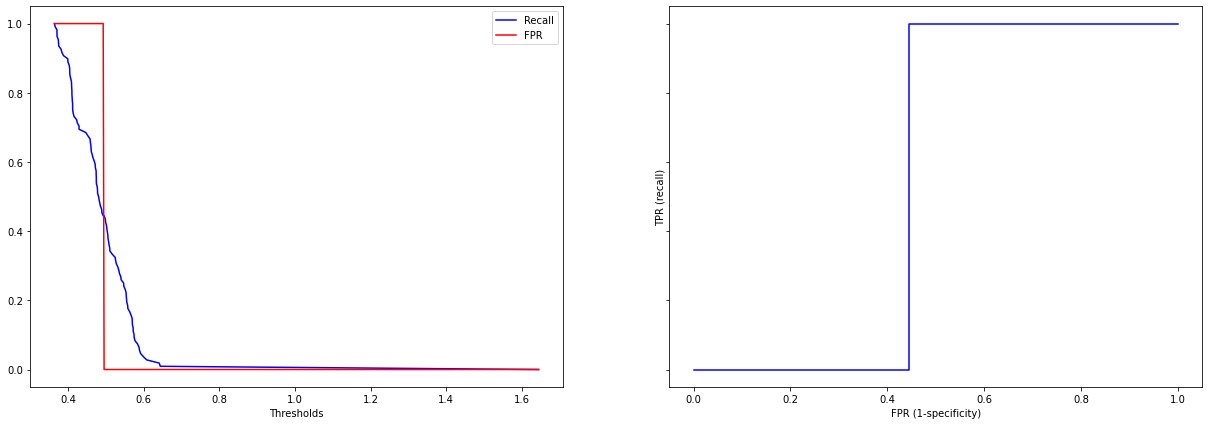

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.615280  0.594383   0.620360     0.636162  0.606854  0.665993
Validation  0.583826  0.564145   0.586989     0.603670  0.572703  0.627853


XGBoost Classifier
╠■■■■■■■■■╣


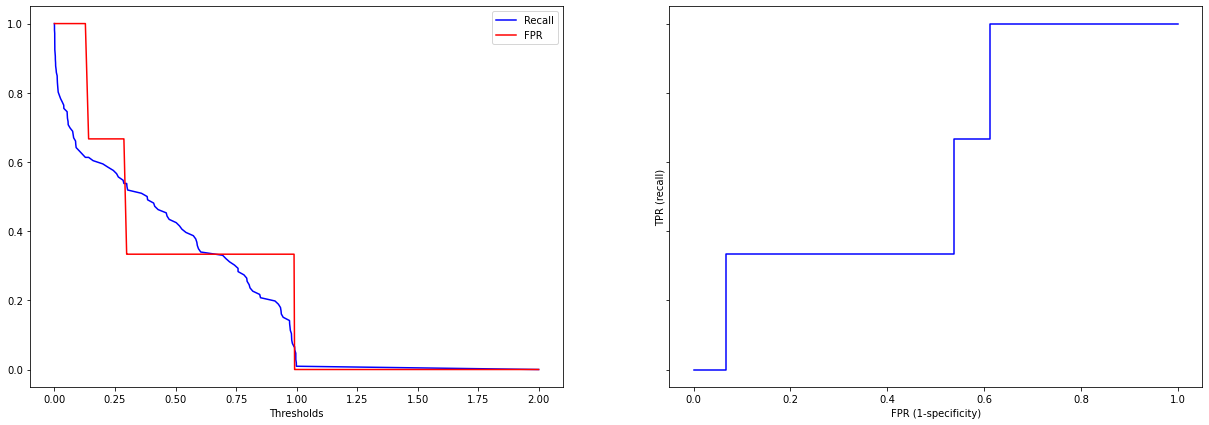

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.997878  0.997776   0.997979     0.997980  0.997877  0.999982
Validation  0.553217  0.540517   0.556495     0.566055  0.547956  0.574083


SVM
╠■■■■■■■■■╣


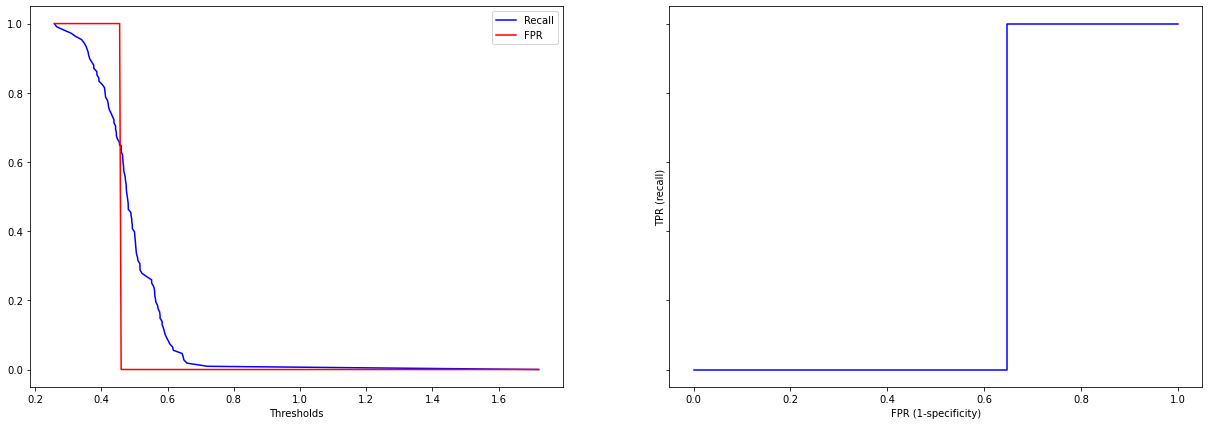

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.599162  0.540088   0.612224     0.658182  0.573851  0.641458
Validation  0.580194  0.532394   0.586478     0.628440  0.555347  0.628949


KNN
╠■■■■■■■■■╣


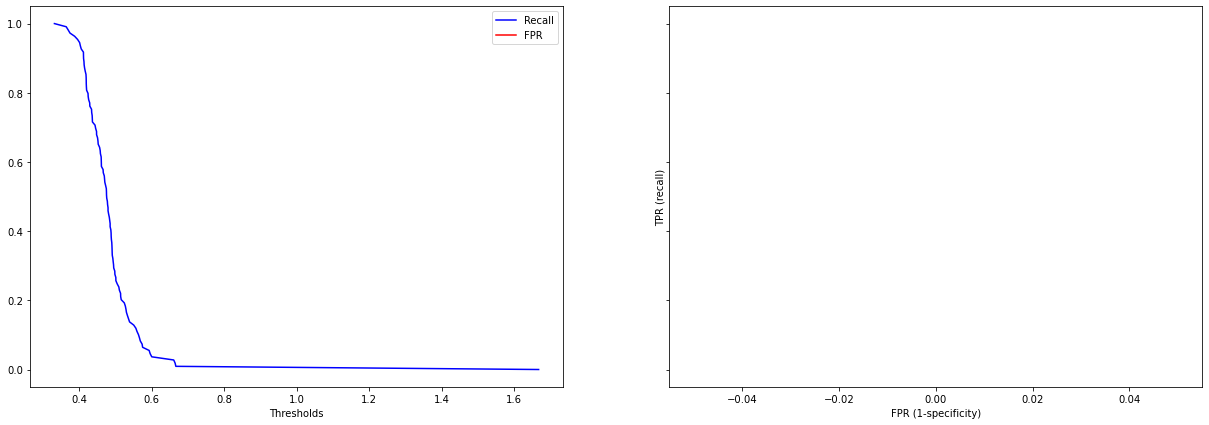

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.998737  0.997675   0.999797     0.999798  0.998734  0.999995
Validation  0.580648  0.517765   0.591850     0.644037  0.548917  0.617839


Logistic Regression
╠■■■■■■■■■╣


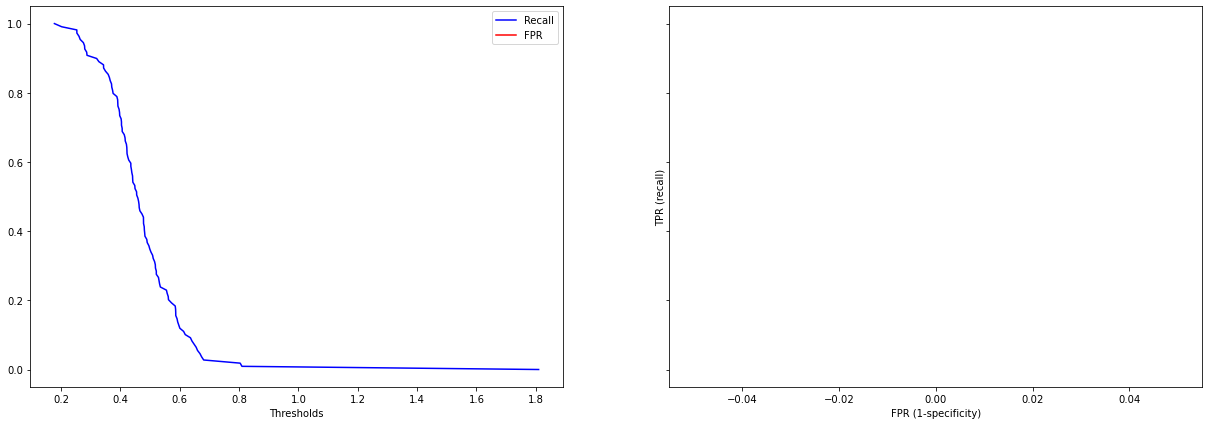

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.597140  0.564857   0.603663     0.629394  0.583607  0.639875
Validation  0.587039  0.547865   0.593678     0.626606  0.566897  0.630166

In [22]:
run_models(s_vitals, y[s_vitals.index], models, ratio_negatives_to_positives=1)

Dummy Random
╠■■■■■■■■■╣


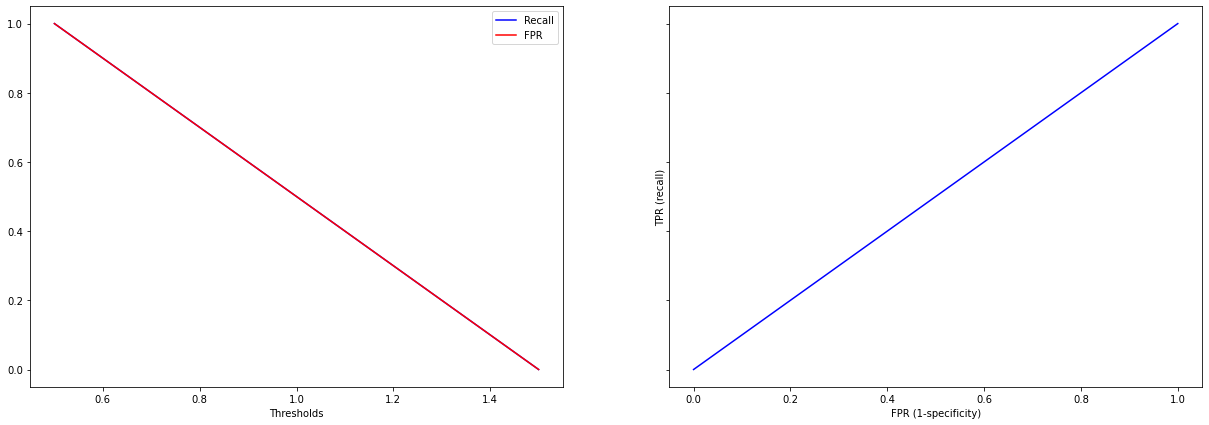

feature_importances


Permutation Importance


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500227     0.0        0.0          1.0  0.0      0.5
Validation  0.497945     0.0        0.0          1.0  0.0      0.5


MultinomialNB
╠■■■■■■■■■╣


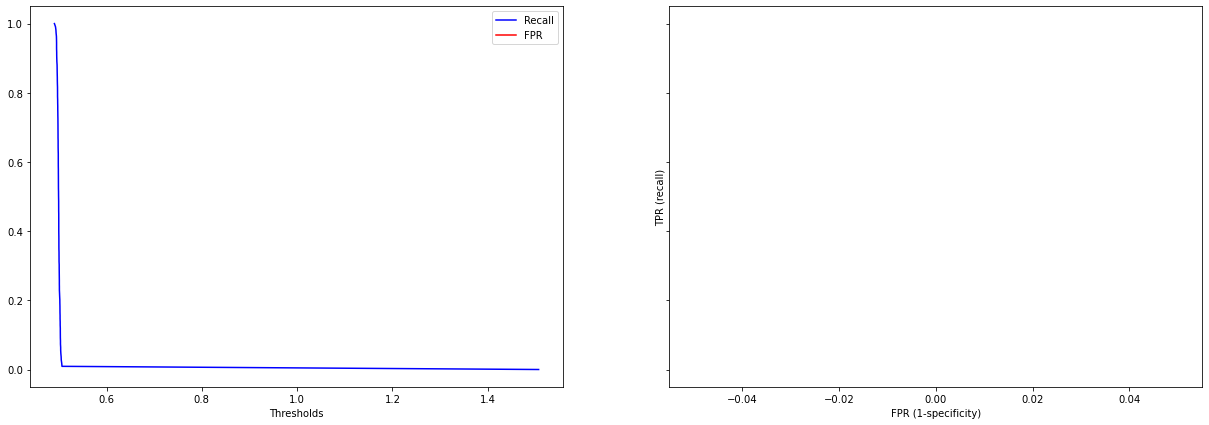

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.578141  0.540491   0.584314     0.615758  0.561533  0.608631
Validation  0.570119  0.533228   0.576641     0.607339  0.552174  0.599939


Random Forest (100 estimators)
╠■■■■■■■■■╣


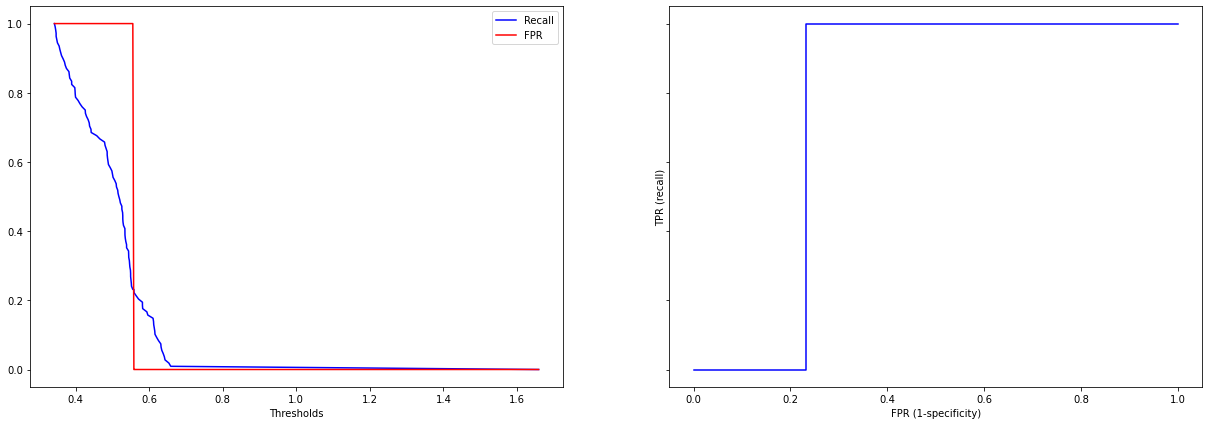

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.610278  0.565163   0.621338     0.655354  0.591409  0.661408
Validation  0.583832  0.544178   0.590115     0.623853  0.562491  0.637031


XGBoost Classifier
╠■■■■■■■■■╣


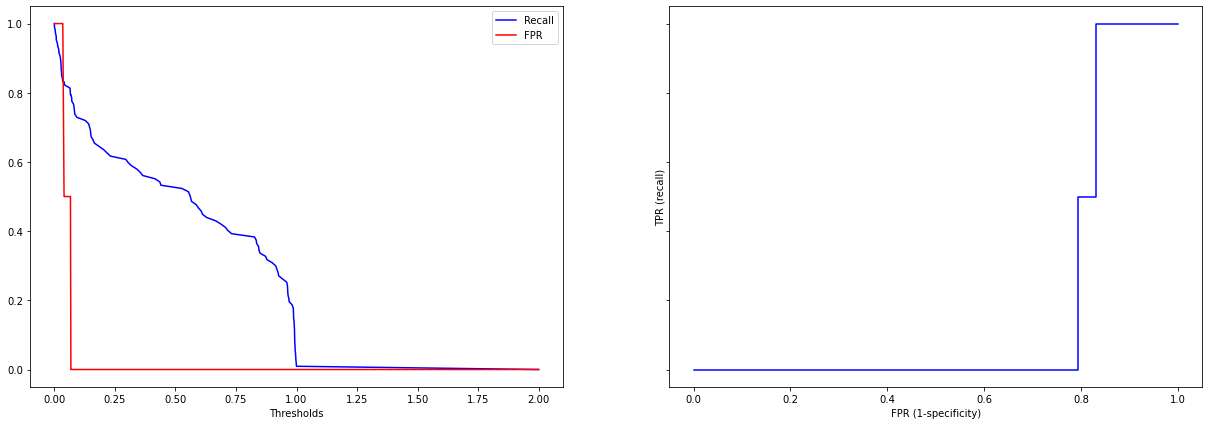

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.998029  0.997270   0.998785     0.998788  0.998026  0.999982
Validation  0.560056  0.534062   0.565822     0.586239  0.548924  0.586426


SVM
╠■■■■■■■■■╣


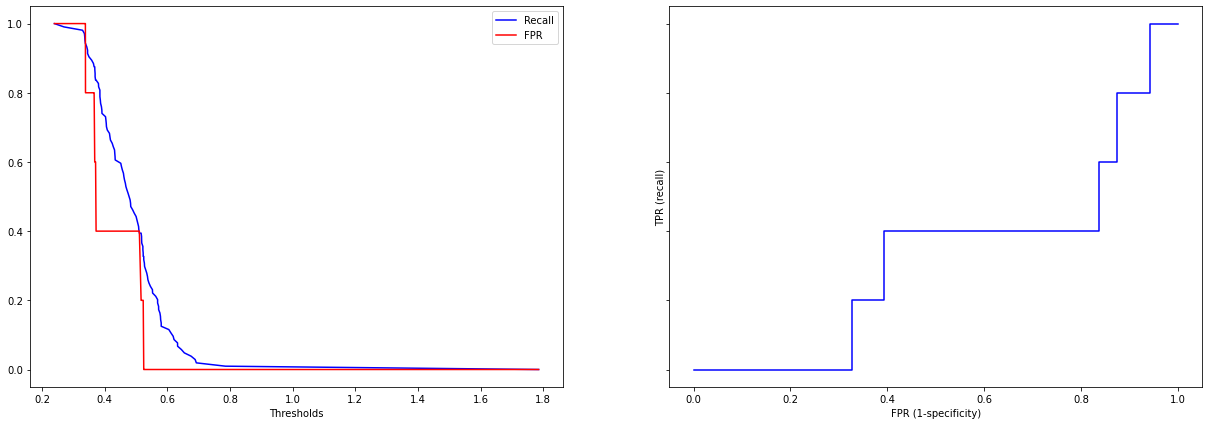

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.589006  0.534327   0.599604     0.643636  0.565044  0.637010
Validation  0.582925  0.533244   0.590491     0.633028  0.559298  0.626208


KNN
╠■■■■■■■■■╣


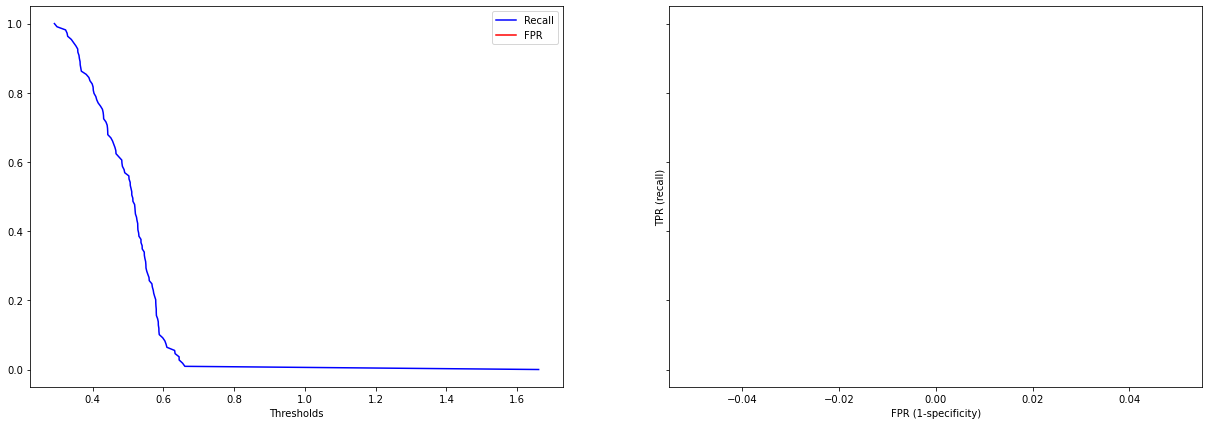

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.998535  0.997068   1.000000      1.00000  0.998531  0.999995
Validation  0.577437  0.519533   0.590319      0.63578  0.549480  0.618986


Logistic Regression
╠■■■■■■■■■╣


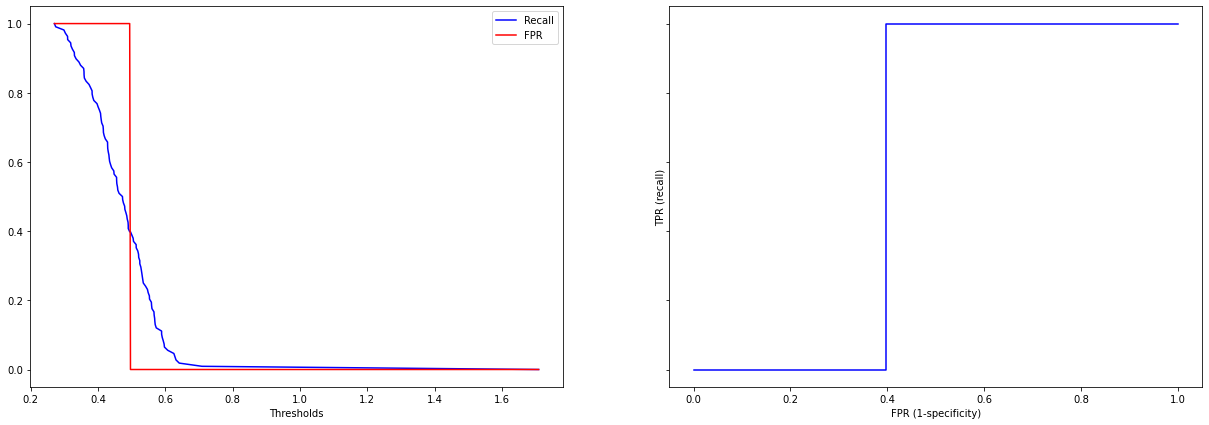

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.591936  0.551916   0.599702     0.631919  0.574793  0.637079
Validation  0.590683  0.556022   0.596212     0.625688  0.573418  0.626577

In [23]:
run_models(n_vitals, y[n_vitals.index], models, ratio_negatives_to_positives=1)

Dummy Random
╠■■■■■■■■■╣


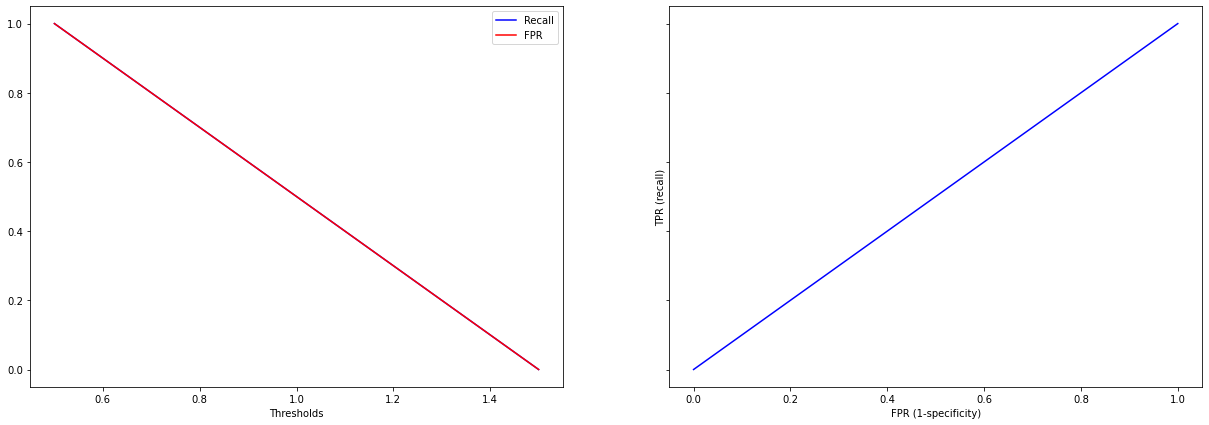

feature_importances


Permutation Importance


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500227     0.0        0.0          1.0  0.0      0.5
Validation  0.497945     0.0        0.0          1.0  0.0      0.5


MultinomialNB
╠■■■■■■■■■╣


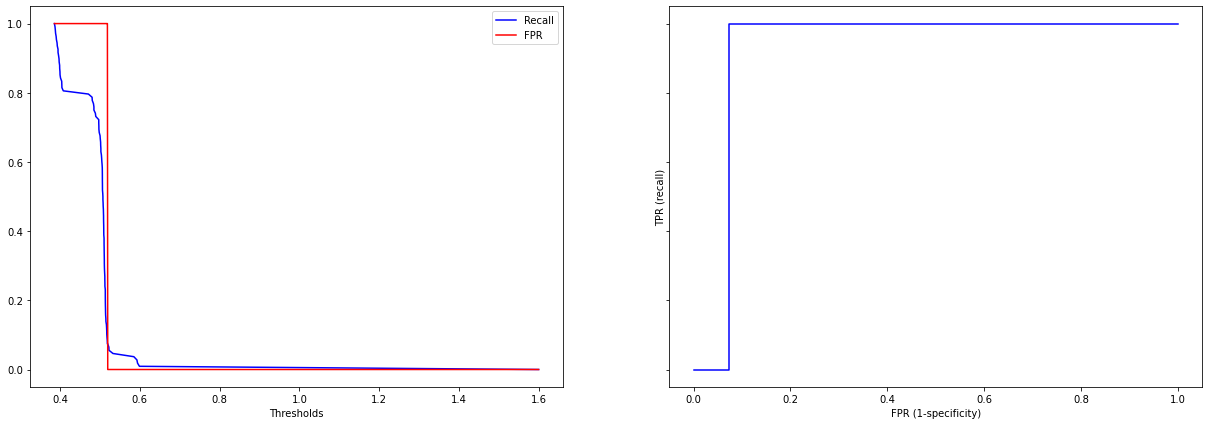

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.559345  0.487825   0.573087     0.630808  0.520373  0.584312
Validation  0.523973  0.466656   0.530258     0.581651  0.491092  0.552235


Random Forest (100 estimators)
╠■■■■■■■■■╣


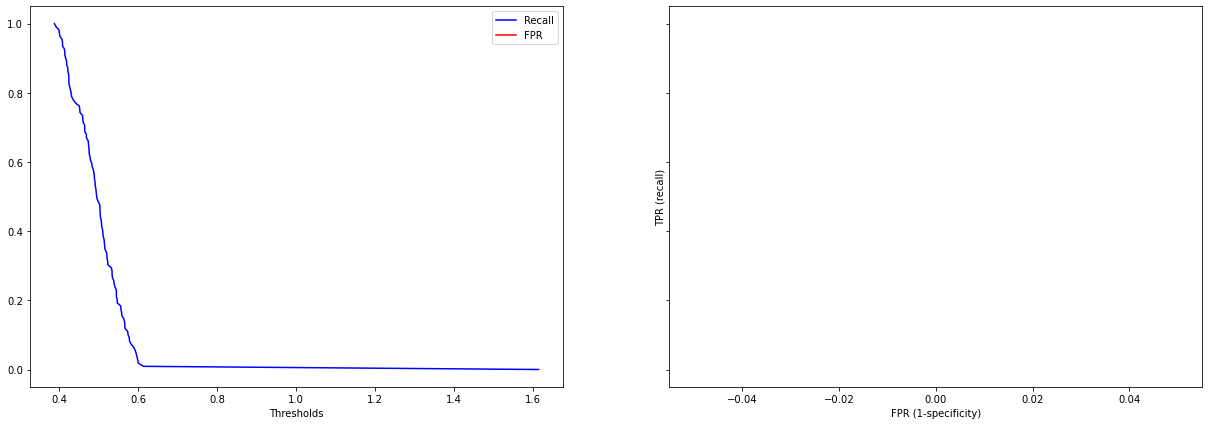

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.617149  0.585380   0.625043     0.648889  0.604329  0.669642
Validation  0.613074  0.567823   0.622958     0.658716  0.592980  0.649490


XGBoost Classifier
╠■■■■■■■■■╣


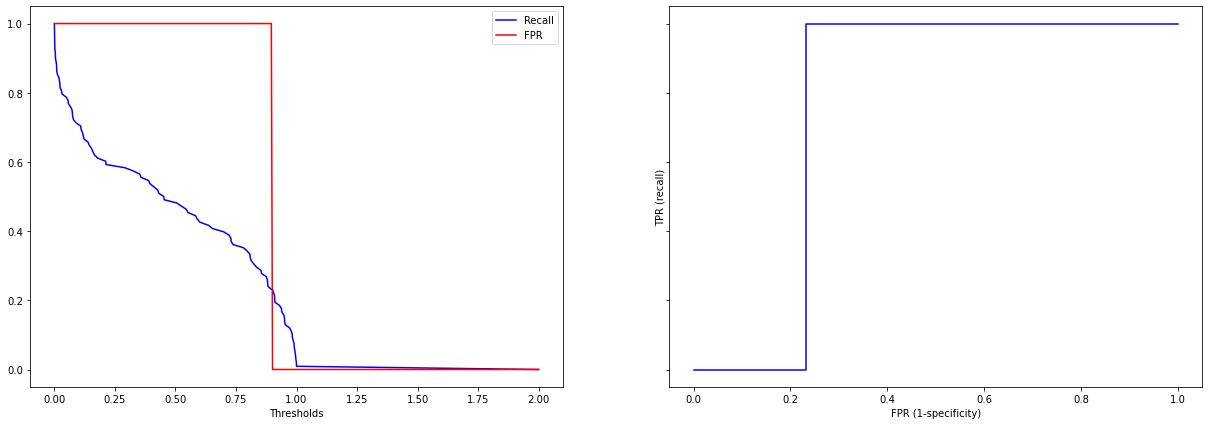

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999495  0.999191   0.999798     0.999798  0.999494  0.999999
Validation  0.552310  0.533219   0.556465     0.571560  0.543386  0.576795


SVM
╠■■■■■■■■■╣


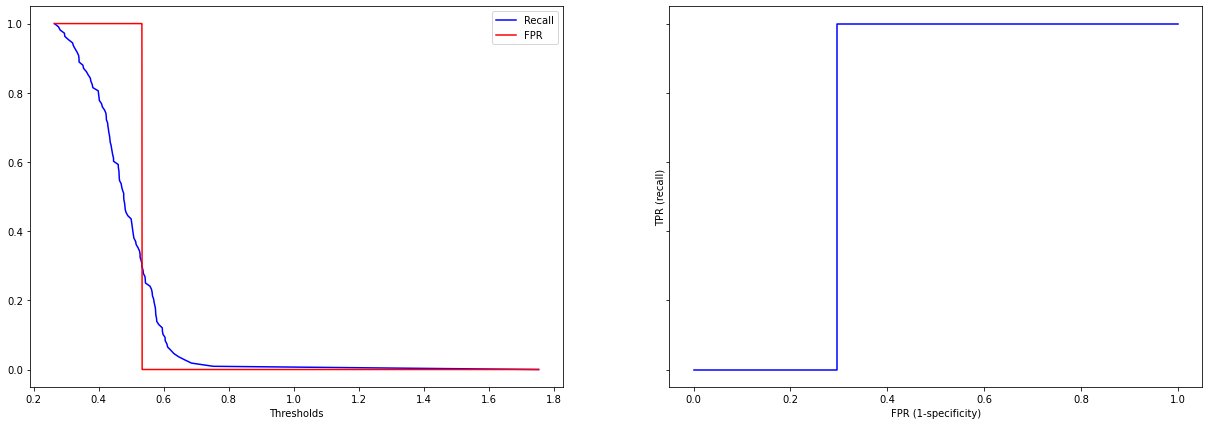

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.597848  0.547267   0.608644     0.648384  0.576286  0.645623
Validation  0.593442  0.532344   0.606597     0.655046  0.565150  0.631714


KNN
╠■■■■■■■■■╣


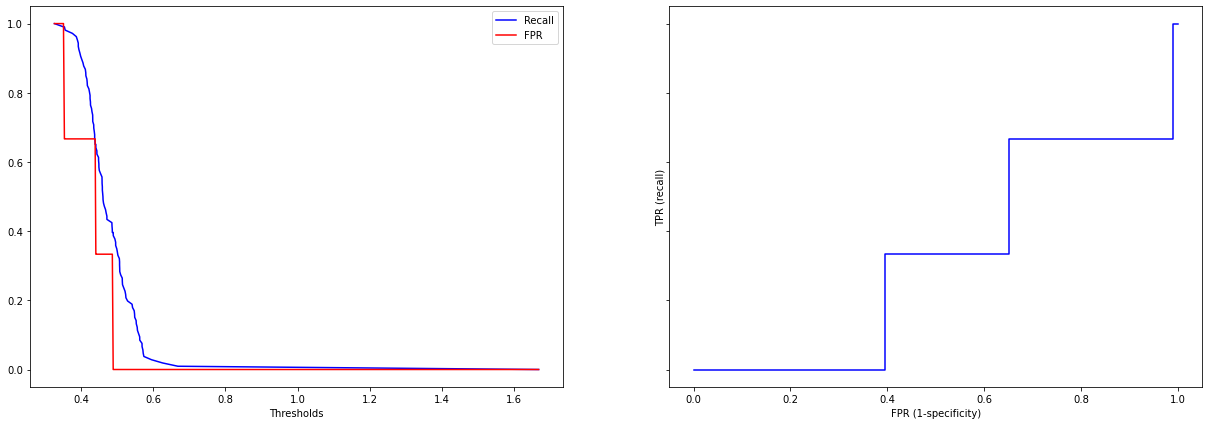

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999646  0.999292   1.000000     1.000000  0.999646  0.999999
Validation  0.571038  0.525863   0.580229     0.616514  0.550035  0.609771


Logistic Regression
╠■■■■■■■■■╣


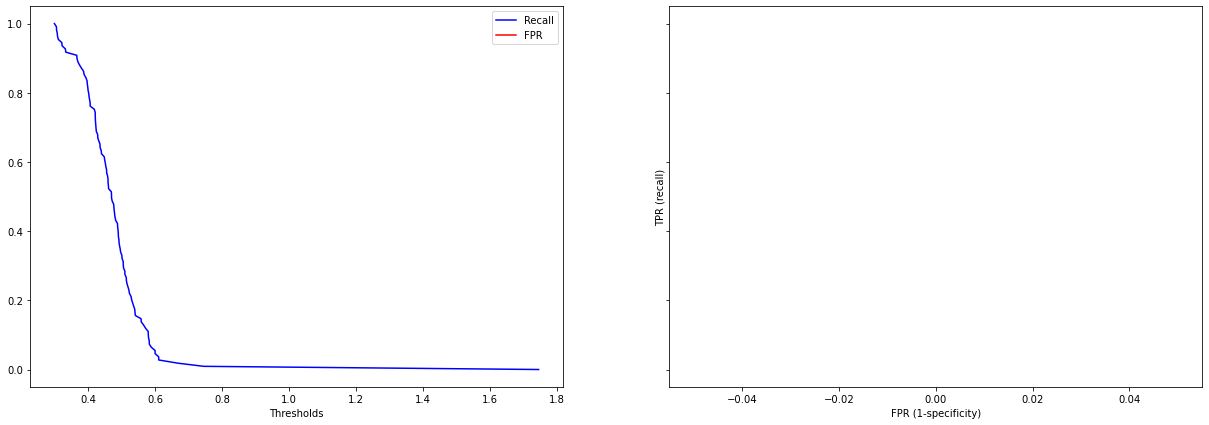

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.600778  0.570116   0.607331     0.631414  0.588069  0.647521
Validation  0.584286  0.557823   0.588040     0.611009  0.570747  0.632244

In [24]:
n_vitals_ex = pd.merge(n_vitals, e_factors, left_index=True, right_index=True)
run_models(n_vitals_ex, y[n_vitals_ex.index], models, ratio_negatives_to_positives=1)

### Assesed Symptoms

In [25]:
a_symptoms.dropna(how="all", inplace=True)

Dummy Random
╠■■■■■■■■■╣


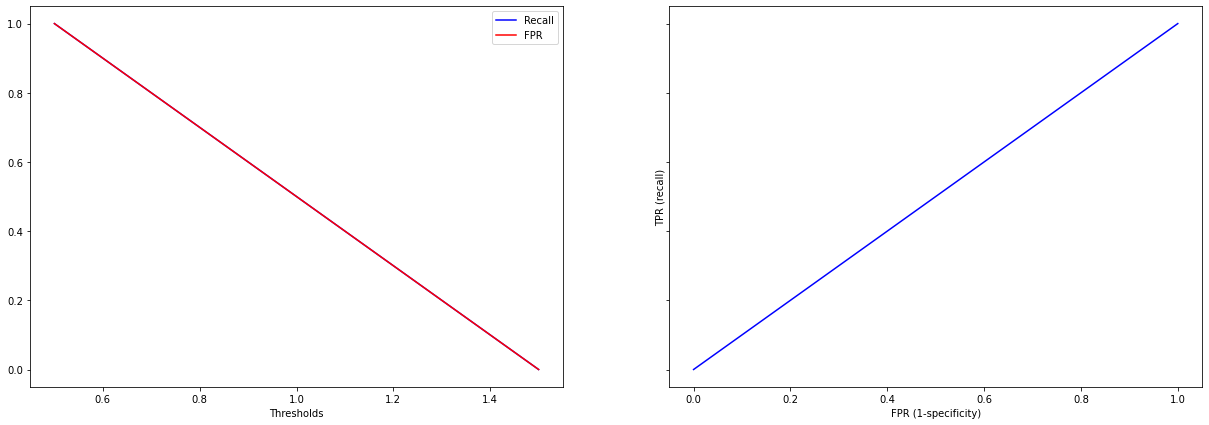

feature_importances


Permutation Importance


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500070     0.0        0.0          1.0  0.0      0.5
Validation  0.499372     0.0        0.0          1.0  0.0      0.5


MultinomialNB
╠■■■■■■■■■╣


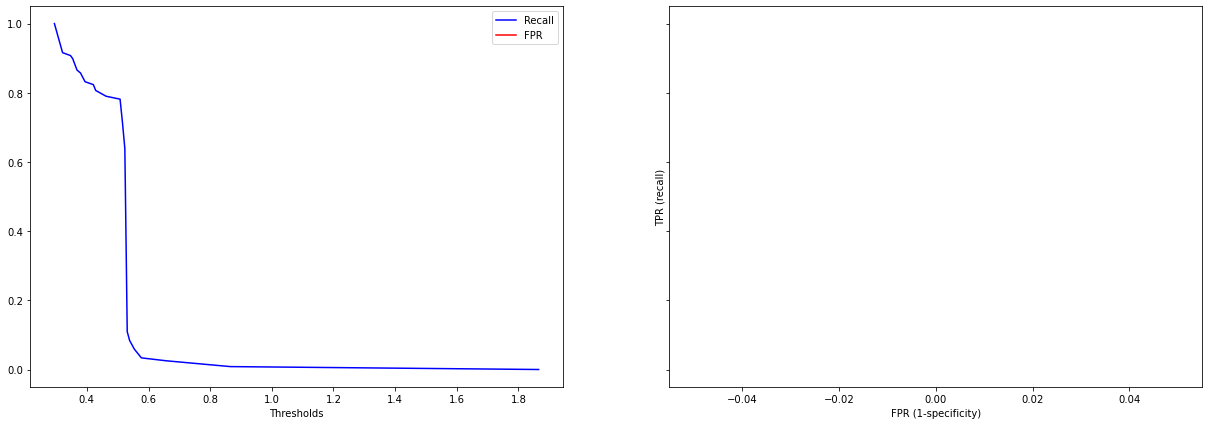

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.540205  0.850610   0.524810     0.229888  0.649104  0.547019
Validation  0.540902  0.848985   0.525383     0.231933  0.648679  0.543375


Random Forest (100 estimators)
╠■■■■■■■■■╣


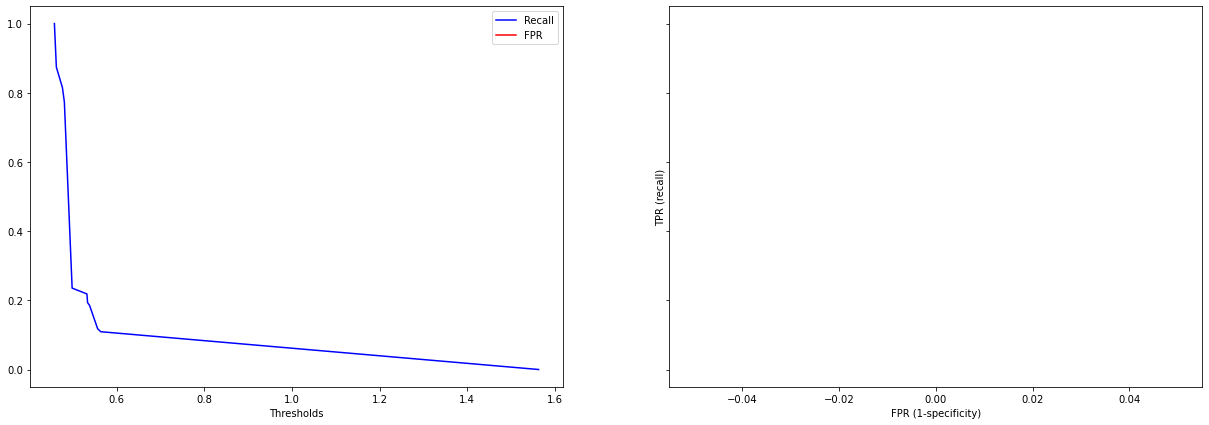

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.590260  0.395551   0.647734     0.784916  0.491062  0.612608
Validation  0.577835  0.392304   0.625830     0.763866  0.478841  0.605110


XGBoost Classifier
╠■■■■■■■■■╣


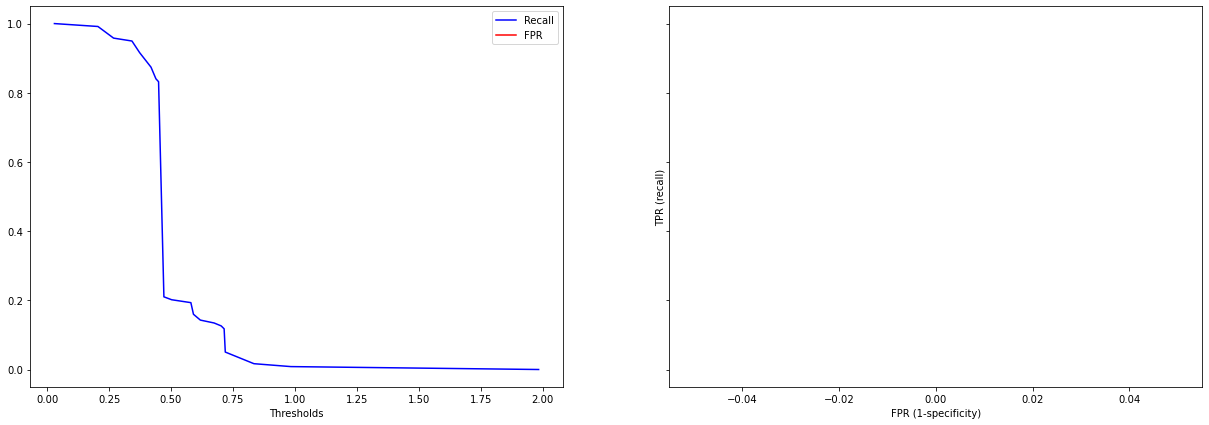

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.605997  0.404862   0.677199     0.807076  0.506740  0.641222
Validation  0.591721  0.381478   0.660112     0.802521  0.482042  0.609243


SVM
╠■■■■■■■■■╣


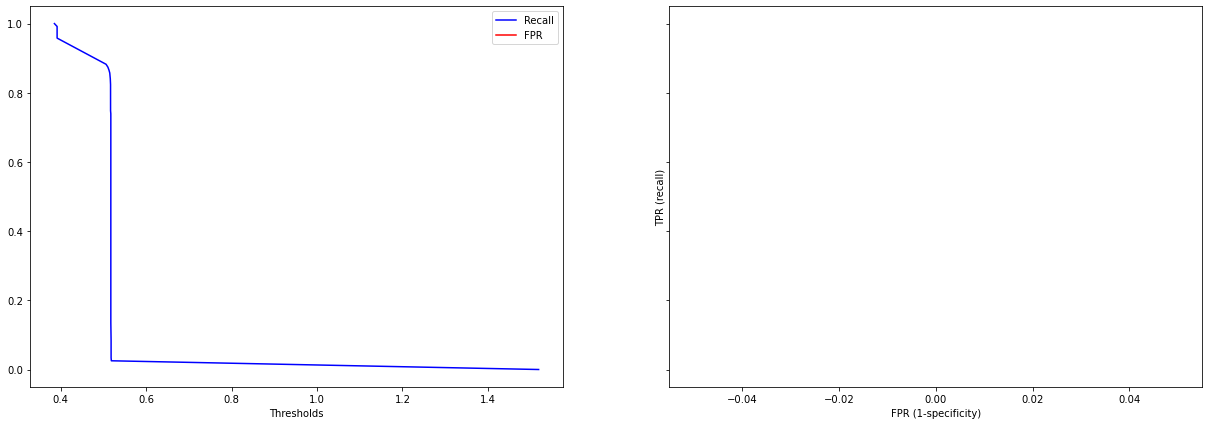

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.533871  0.785923   0.512951     0.281844  0.605591  0.540076
Validation  0.531261  0.779888   0.509492     0.282353  0.602163  0.539972


KNN
╠■■■■■■■■■╣


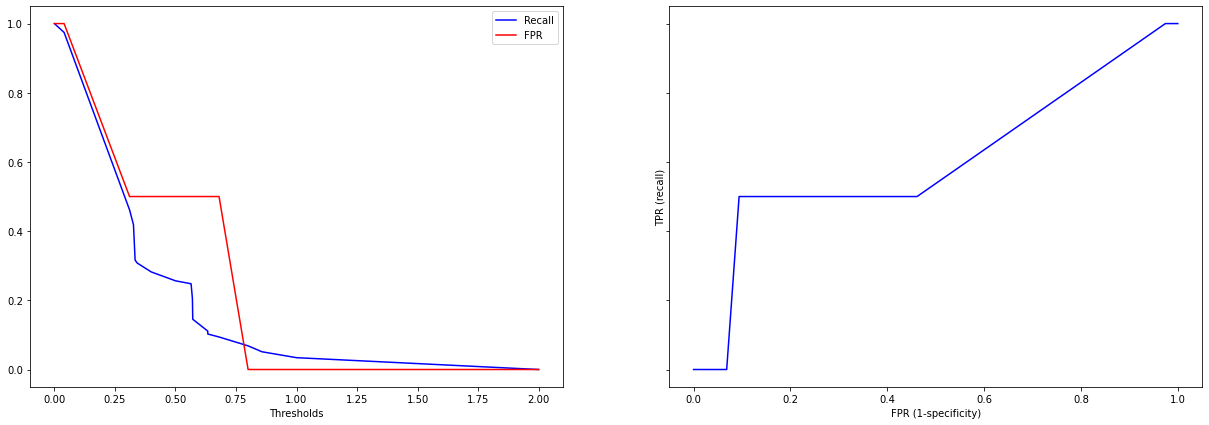

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.602924  0.386140   0.682091     0.819646  0.492506  0.594163
Validation  0.582497  0.375609   0.641926     0.789916  0.472045  0.565917


Logistic Regression
╠■■■■■■■■■╣


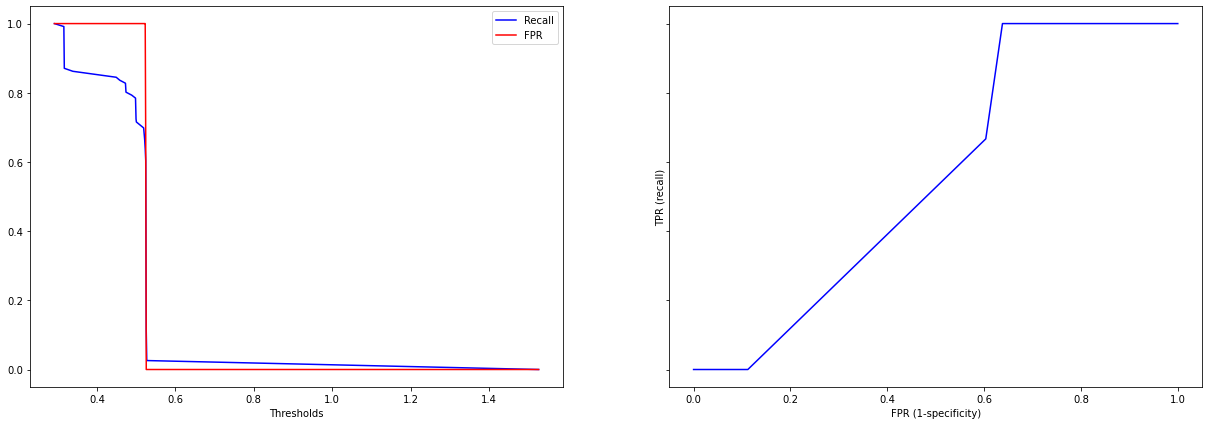

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training     0.54393  0.834217   0.527788     0.253724  0.646506  0.543067
Validation   0.54468  0.833137   0.529210     0.255462  0.647007  0.539719

In [26]:
run_models(a_symptoms, y[a_symptoms.index], models, ratio_negatives_to_positives=1)

Dummy Random
╠■■■■■■■■■╣


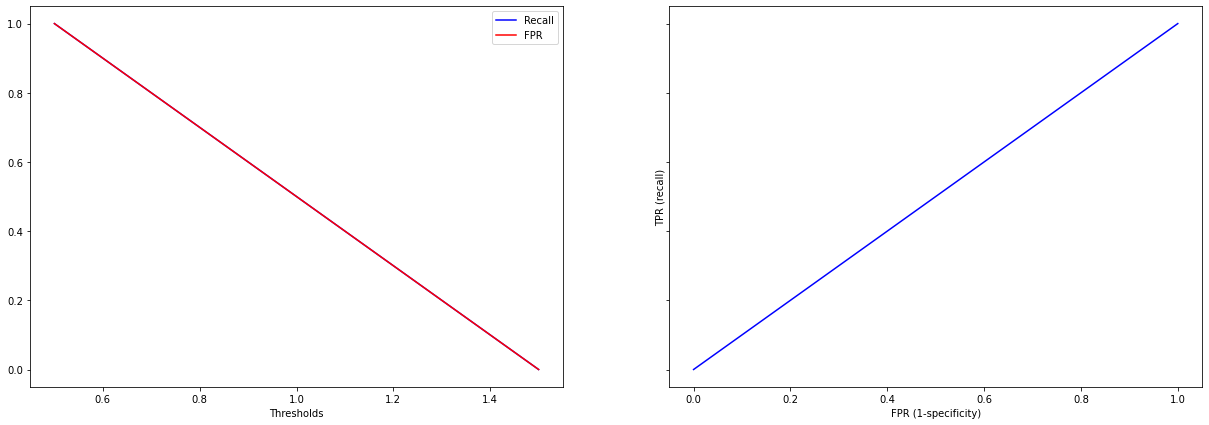

feature_importances


Permutation Importance


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500070     0.0        0.0          1.0  0.0      0.5
Validation  0.499372     0.0        0.0          1.0  0.0      0.5


MultinomialNB
╠■■■■■■■■■╣


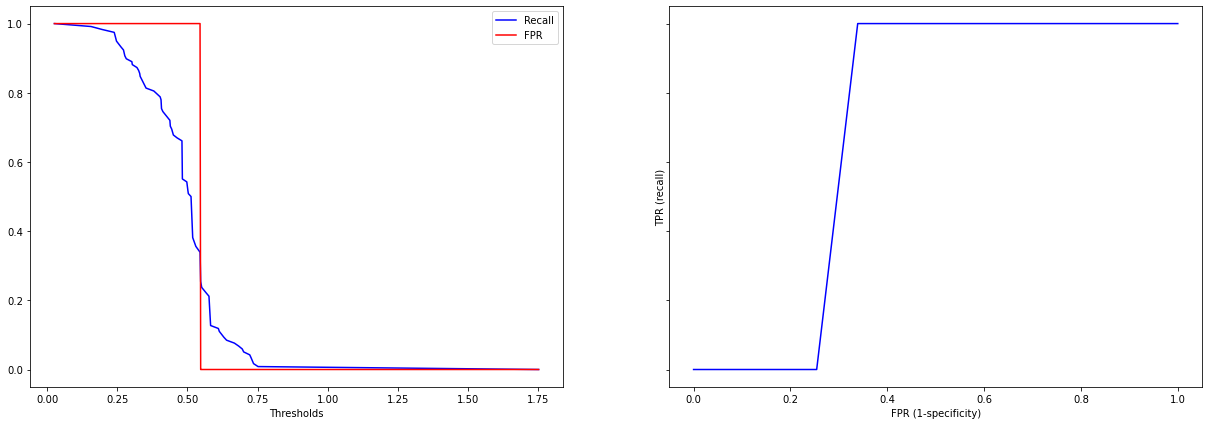

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.554500  0.754019   0.539080     0.355028  0.626238  0.570703
Validation  0.561455  0.754384   0.545004     0.368067  0.631536  0.564704


Random Forest (100 estimators)
╠■■■■■■■■■╣


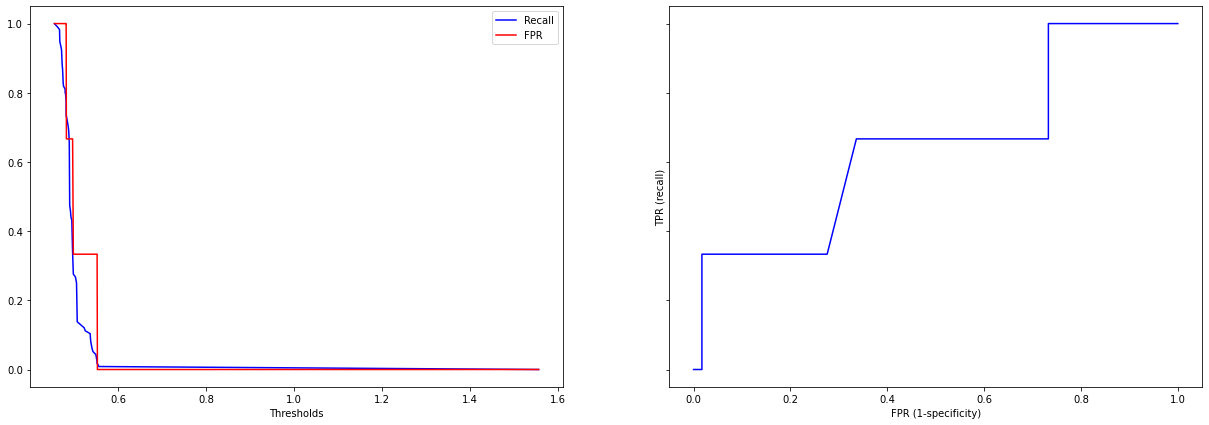

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.594170  0.534688   0.608587     0.653631  0.566970  0.633264
Validation  0.576564  0.512969   0.589129     0.640336  0.545623  0.614057


XGBoost Classifier
╠■■■■■■■■■╣


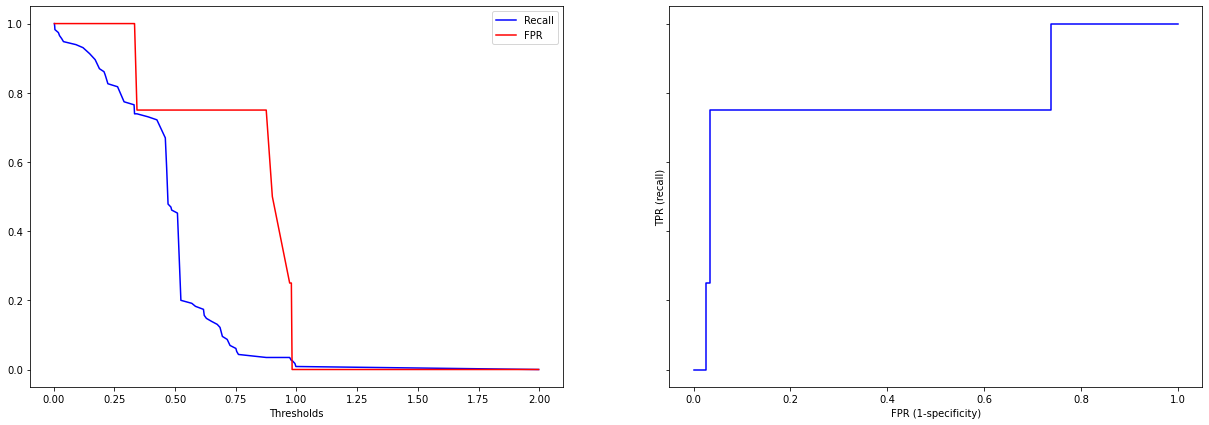

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.644643  0.526674   0.695258      0.76257  0.594396  0.720830
Validation  0.558516  0.441779   0.580502      0.67563  0.496519  0.587829


SVM
╠■■■■■■■■■╣


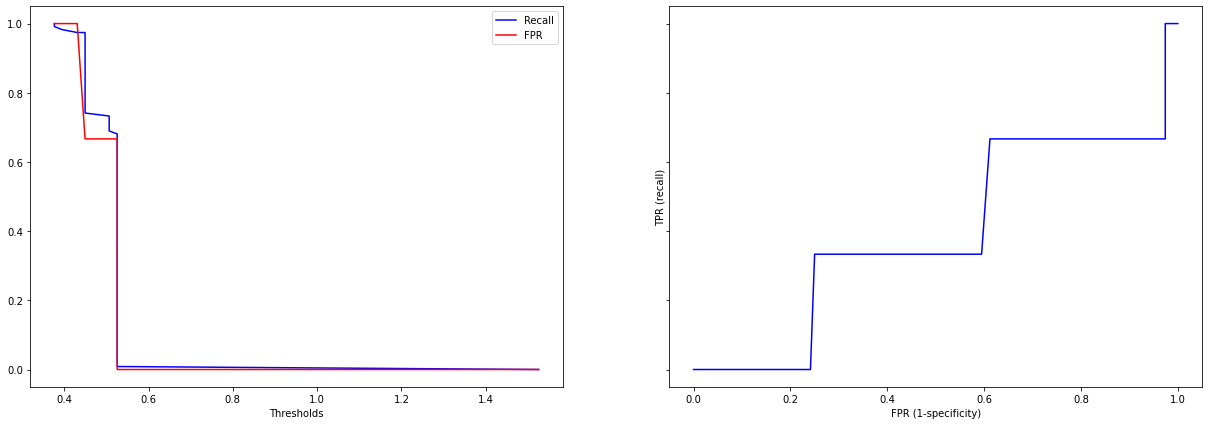

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.542349  0.639480   0.548590     0.445251  0.544702  0.572346
Validation  0.524547  0.617724   0.523308     0.431092  0.523305  0.534696


KNN
╠■■■■■■■■■╣


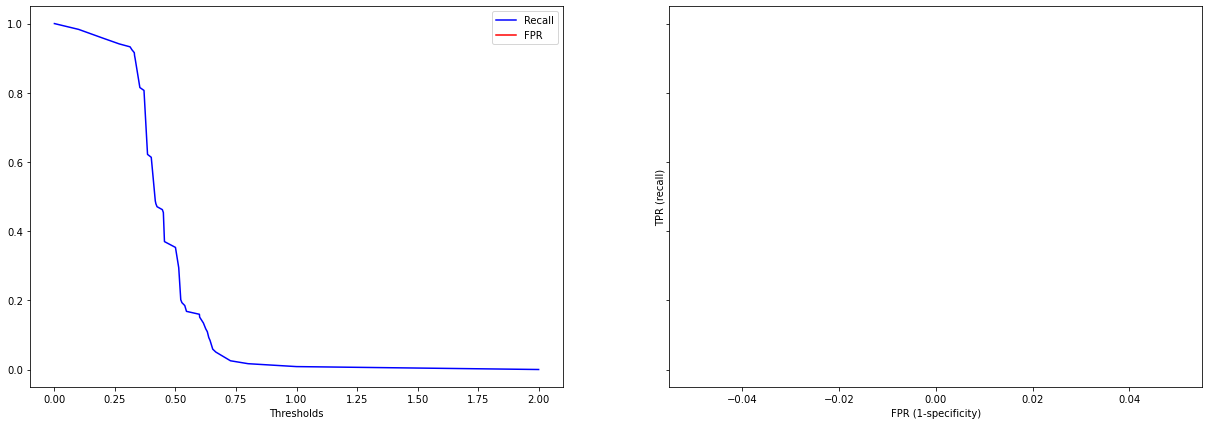

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.643759  0.441279   0.741730     0.846182  0.553132  0.678647
Validation  0.569440  0.371275   0.617001     0.768067  0.462755  0.568848


Logistic Regression
╠■■■■■■■■■╣


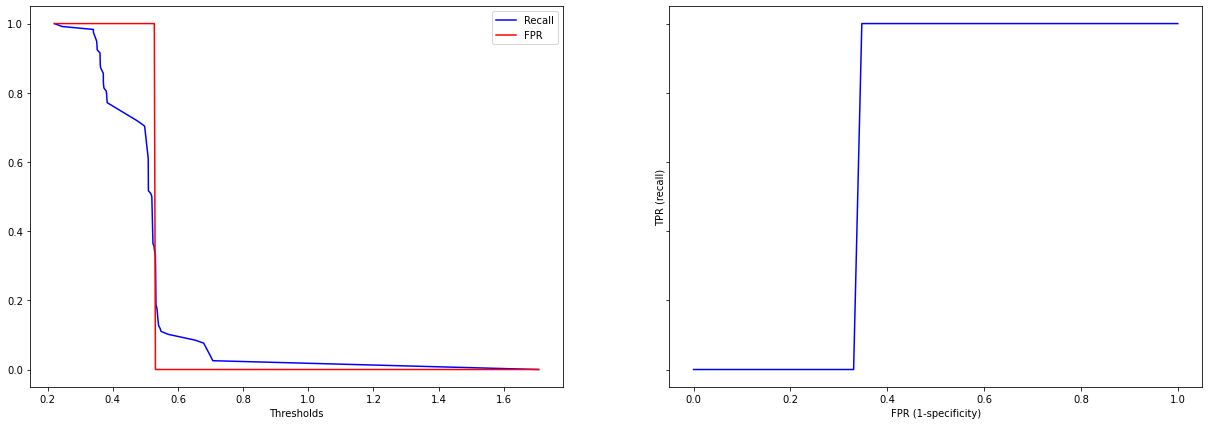

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.566140  0.697302   0.552366     0.435009  0.614717  0.587191
Validation  0.554748  0.683964   0.544691     0.425210  0.604704  0.576547

In [27]:
a_symptoms_ef = pd.merge(a_symptoms, e_factors, left_index=True, right_index=True)
run_models(a_symptoms_ef, y[a_symptoms_ef.index], models, ratio_negatives_to_positives=1)

### Reported symptoms

In [28]:
r_symptoms

cough  cough_severity  fever    sob  sob_severity diarrhea fatigue  \
0       True             3.0    NaN  False           0.0    False   False   
1       True             1.0  False  False           0.0    False   False   
2      False             0.0    NaN    NaN           NaN      NaN     NaN   
3       True             2.0  False   True           2.0    False    True   
4       True             1.0  False  False           0.0    False   False   
...      ...             ...    ...    ...           ...      ...     ...   
93989  False             0.0  False  False           0.0    False   False   
93990   True             2.0  False  False           0.0    False   False   
93991  False             0.0   True  False           0.0    False   False   
93993  False             0.0  False  False           0.0    False   False   
93994  False             0.0  False  False           0.0    False   False   

      headache loss_of_smell loss_of_taste runny_nose muscle_sore sore_throat  
0        False         False         False      False       False       False  
1        False         False         False      False       False       False  
2          NaN           NaN           NaN        NaN         NaN         NaN  
3        False         False         False      False       False        True  
4        False         False         False      False       False       False  
...        ...           ...           ...        ...         ...         ...  
93989    False         False         False      False       False       False  
93990    False         False         False       True       False        True  
93991    False         False         False      False       False       False  
93993    False         False         False      False       False       False  
93994    False         False         False      False       False       False  

[51695 rows x 13 columns]

In [29]:
r_symptoms.dropna(how="all", inplace=True)

Dummy Random
╠■■■■■■■■■╣


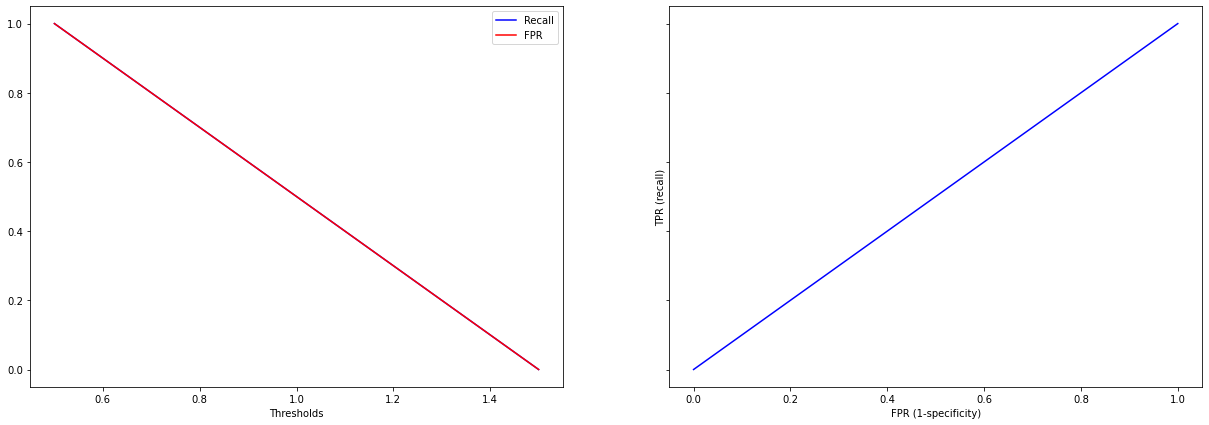

feature_importances


Permutation Importance


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500045     0.0        0.0          1.0  0.0      0.5
Validation  0.499592     0.0        0.0          1.0  0.0      0.5


MultinomialNB
╠■■■■■■■■■╣


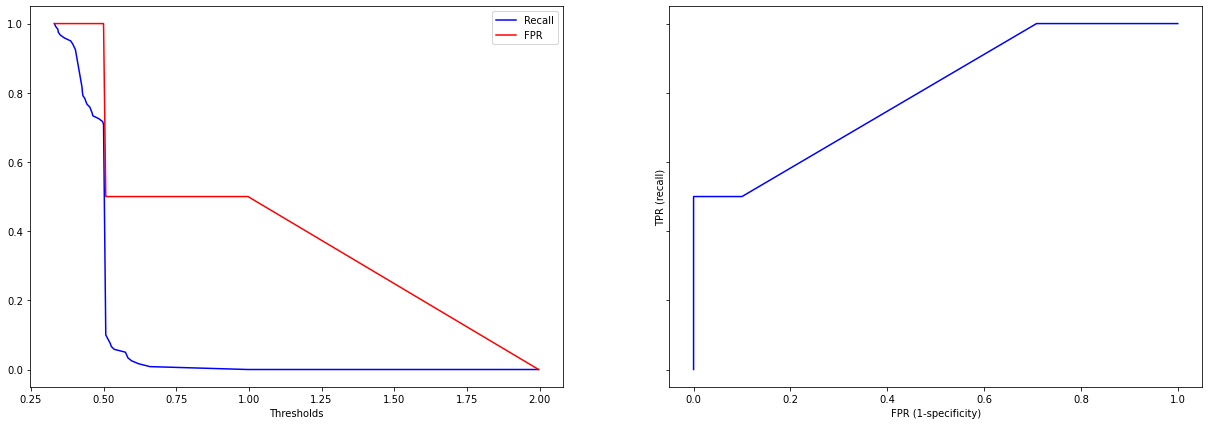

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.628012  0.362157   0.773238     0.893818  0.493158  0.608278
Validation  0.622419  0.356697   0.758417     0.888525  0.480747  0.603478


Random Forest (100 estimators)
╠■■■■■■■■■╣


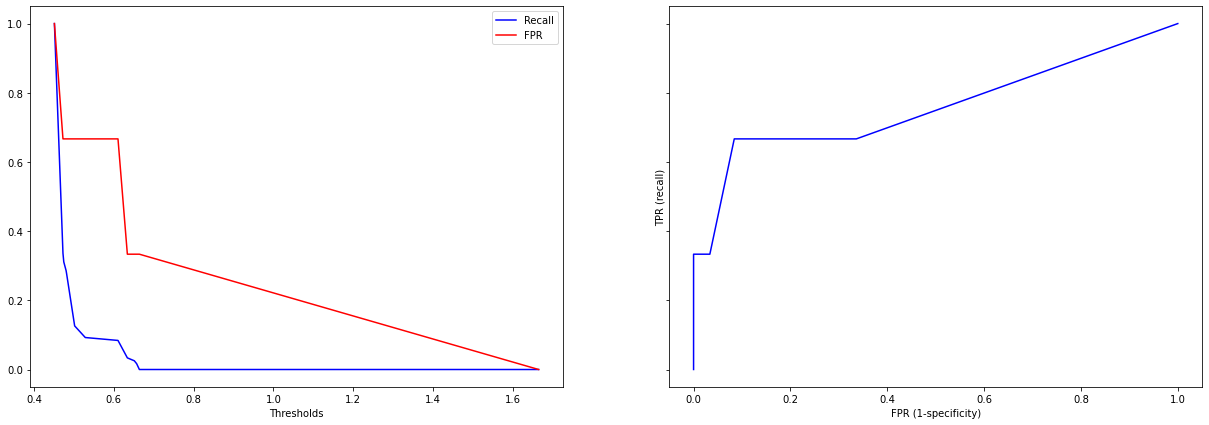

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.635512  0.435622   0.725867     0.835364  0.544194  0.667327
Validation  0.638801  0.431208   0.735907     0.846721  0.539638  0.665686


XGBoost Classifier
╠■■■■■■■■■╣


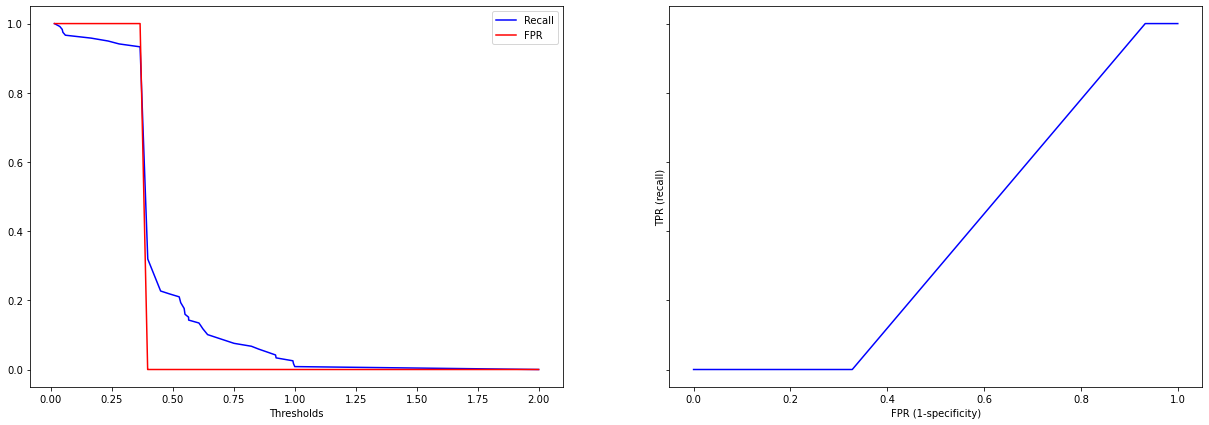

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.701427  0.502727   0.835101     0.900091  0.627193  0.754247
Validation  0.651501  0.452479   0.749081     0.850820  0.562424  0.659339


SVM
╠■■■■■■■■■╣


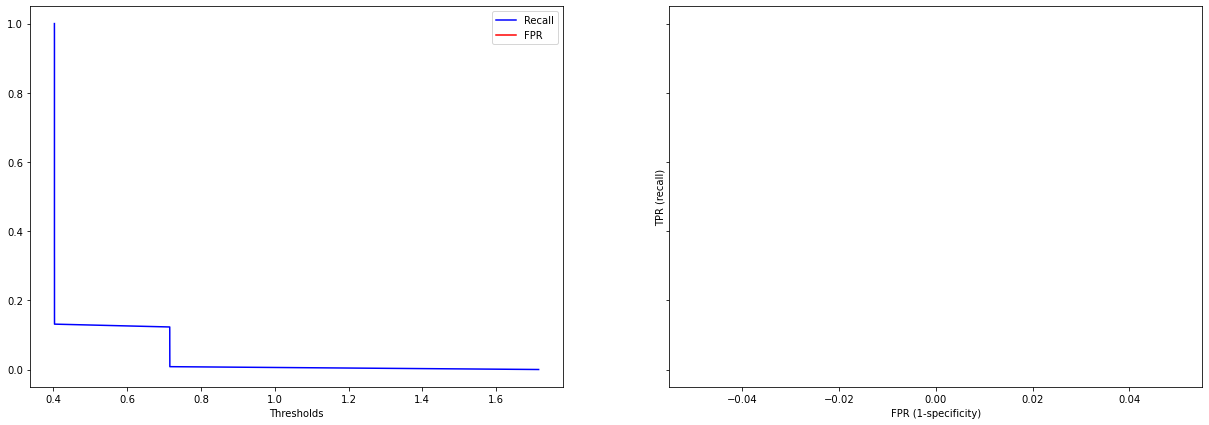

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.649377  0.437722   0.759414     0.861000  0.554670  0.685168
Validation  0.642894  0.422158   0.752265     0.863934  0.537911  0.674596


KNN
╠■■■■■■■■■╣


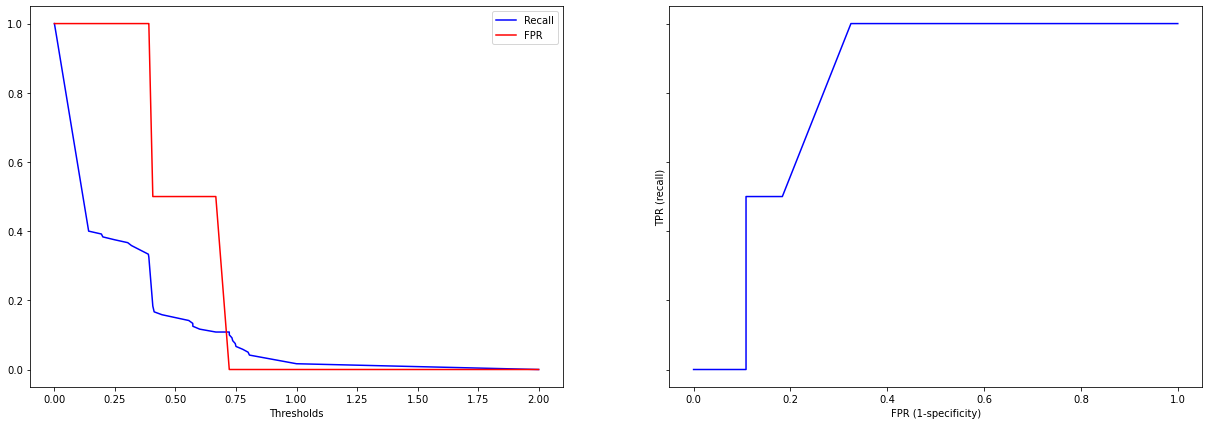

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.706155  0.491088   0.861752     0.921182  0.625452  0.740600
Validation  0.642462  0.445049   0.732663     0.840164  0.551021  0.647812


Logistic Regression
╠■■■■■■■■■╣


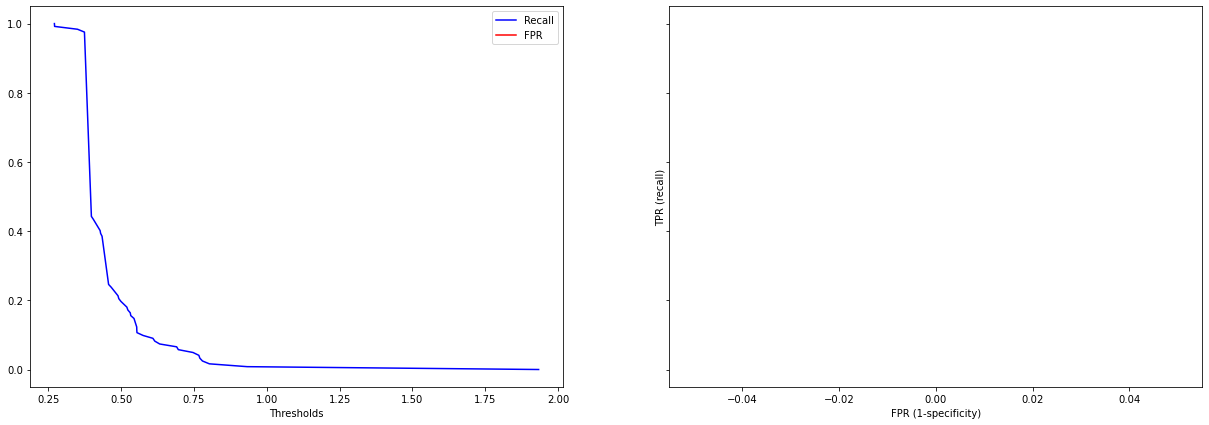

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.664833  0.483180   0.759036     0.846455  0.590379  0.689752
Validation  0.658461  0.472911   0.754279     0.844262  0.575712  0.689162

In [30]:
run_models(r_symptoms, y[r_symptoms.index], models, ratio_negatives_to_positives=1)

Dummy Random
╠■■■■■■■■■╣


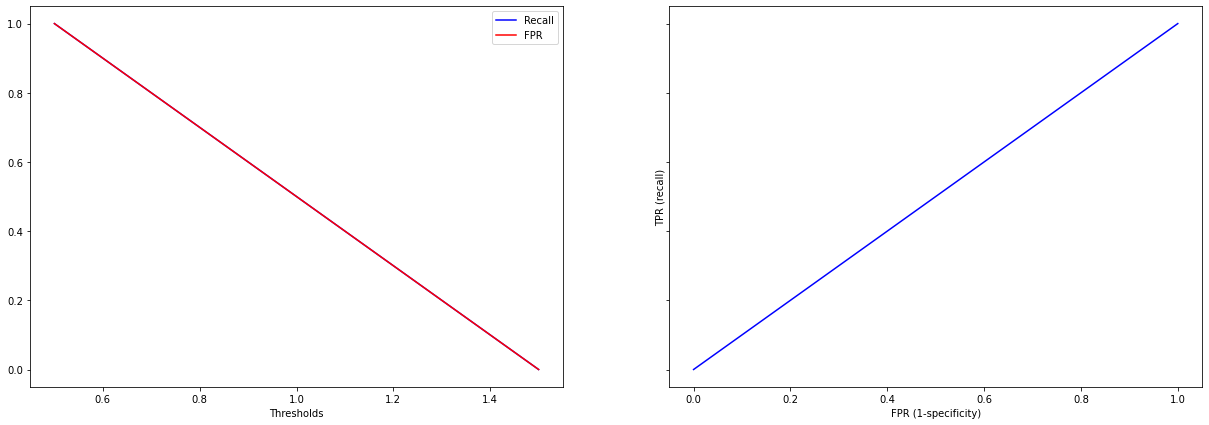

feature_importances


Permutation Importance


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500045     0.0        0.0          1.0  0.0      0.5
Validation  0.499592     0.0        0.0          1.0  0.0      0.5


MultinomialNB
╠■■■■■■■■■╣


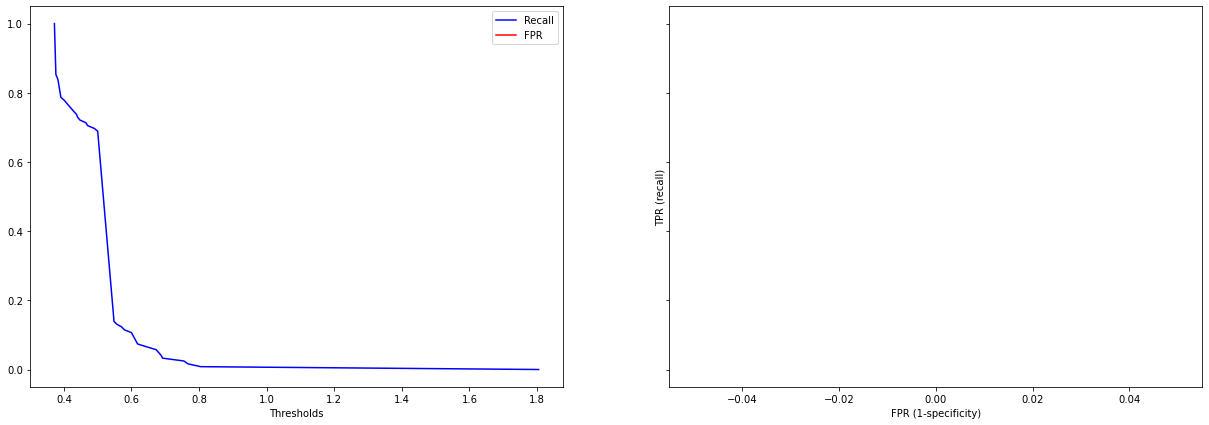

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.623421  0.344792   0.778475     0.902000  0.477854  0.603761
Validation  0.616674  0.340297   0.758036     0.893443  0.465524  0.588596


Random Forest (100 estimators)
╠■■■■■■■■■╣


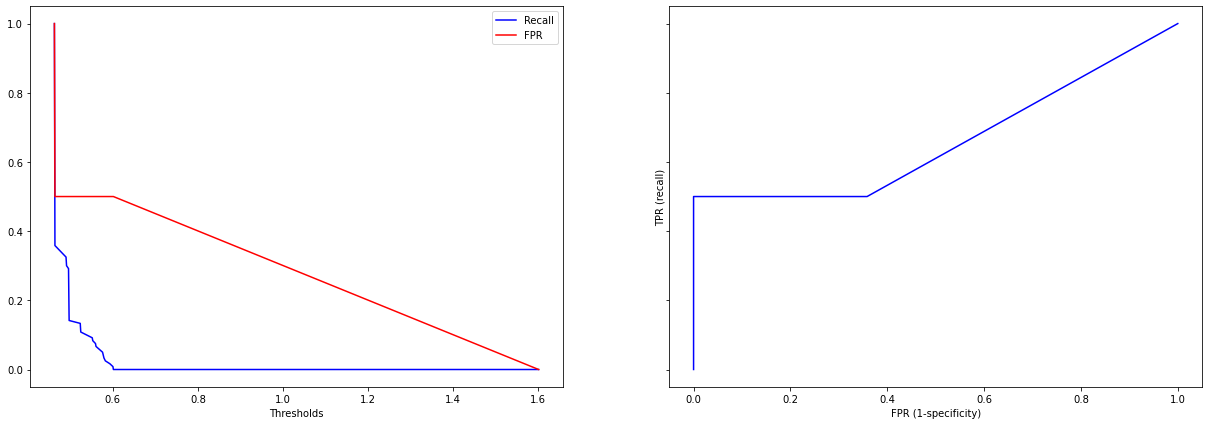

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.634785  0.473632   0.698932     0.795909  0.564554  0.666207
Validation  0.635125  0.471278   0.699624     0.799180  0.560025  0.659294


XGBoost Classifier
╠■■■■■■■■■╣


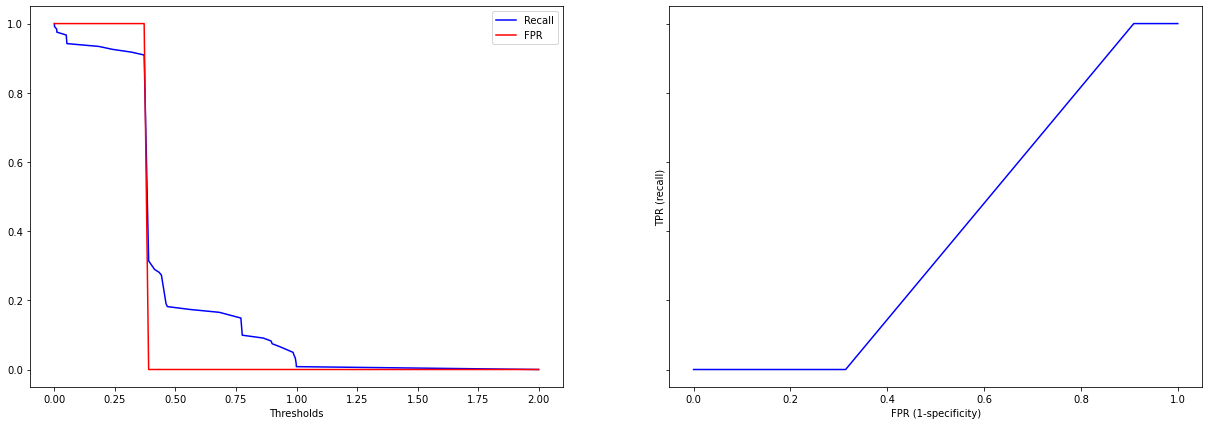

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.704837  0.506454   0.839711     0.903182  0.631606  0.755671
Validation  0.641664  0.450800   0.726904     0.832787  0.553598  0.655885


SVM
╠■■■■■■■■■╣


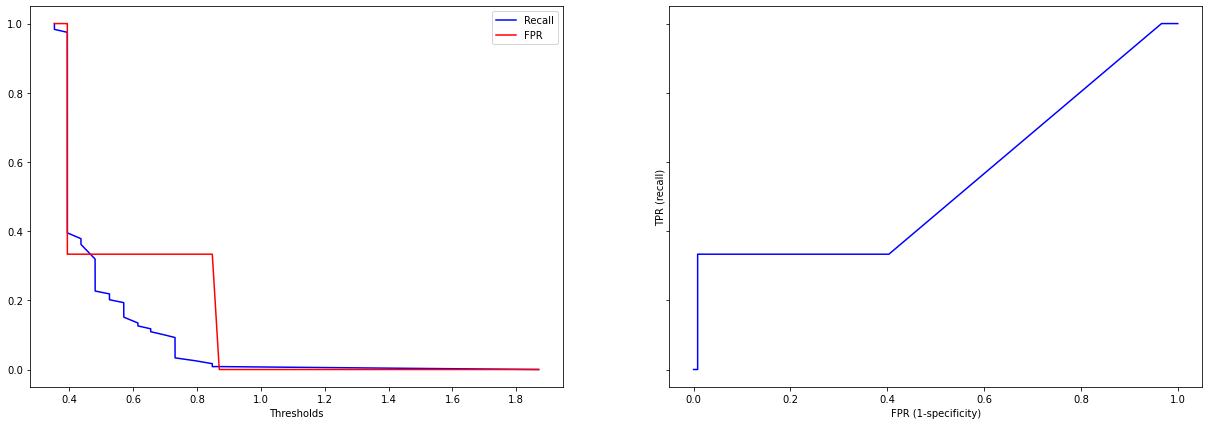

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.661560  0.489360   0.747844     0.833727  0.590964  0.688460
Validation  0.659287  0.485199   0.740529     0.833607  0.582137  0.675767


KNN
╠■■■■■■■■■╣


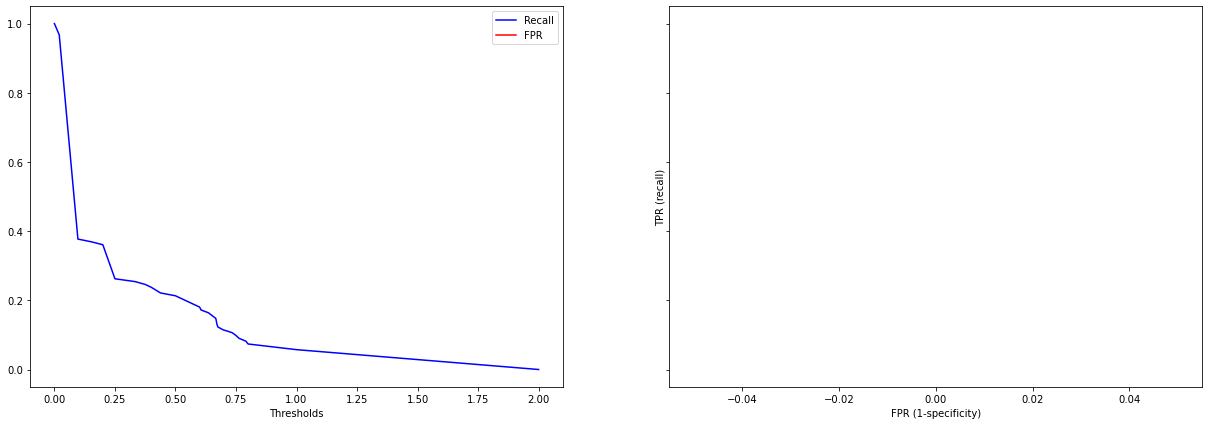

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.705837  0.485360   0.868556     0.926273  0.622514  0.742204
Validation  0.641241  0.449953   0.726644     0.832787  0.552675  0.657162


Logistic Regression
╠■■■■■■■■■╣


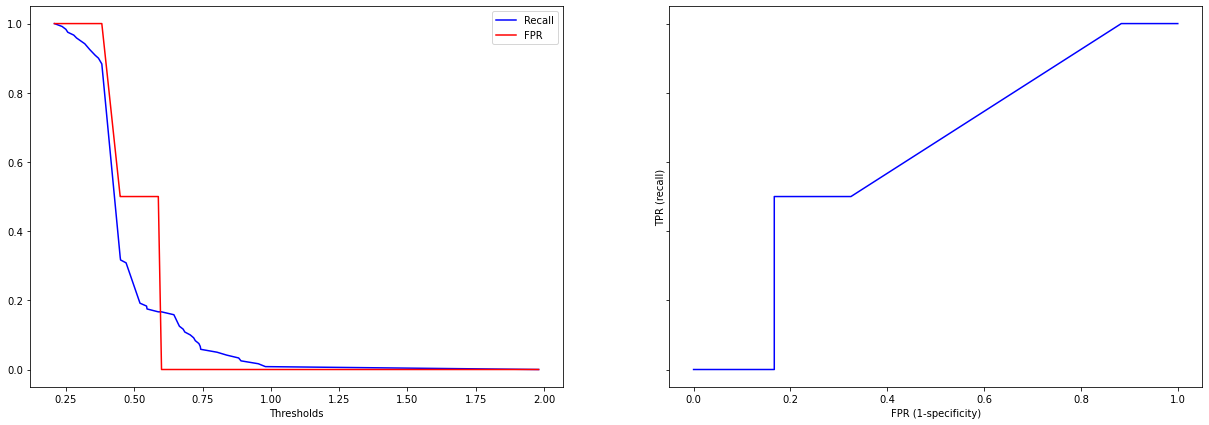

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.659378  0.482912   0.749409     0.835818  0.586082  0.688575
Validation  0.641276  0.463108   0.720535     0.819672  0.559337  0.677686

In [31]:
run_models(r_symptoms.drop(columns=["sob", "cough"]), y[r_symptoms.index], models, ratio_negatives_to_positives=1)

Dummy Random
╠■■■■■■■■■╣


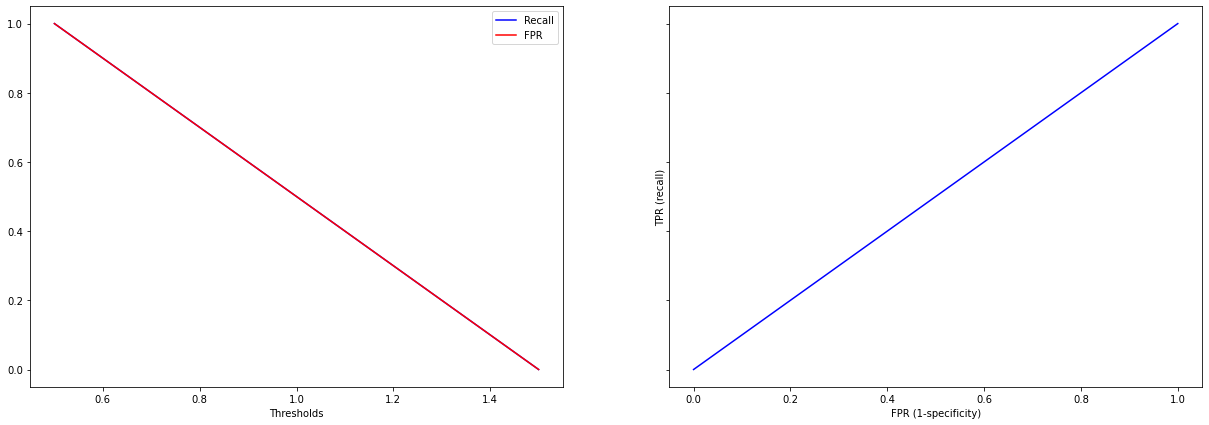

feature_importances


Permutation Importance


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500045     0.0        0.0          1.0  0.0      0.5
Validation  0.499592     0.0        0.0          1.0  0.0      0.5


MultinomialNB
╠■■■■■■■■■╣


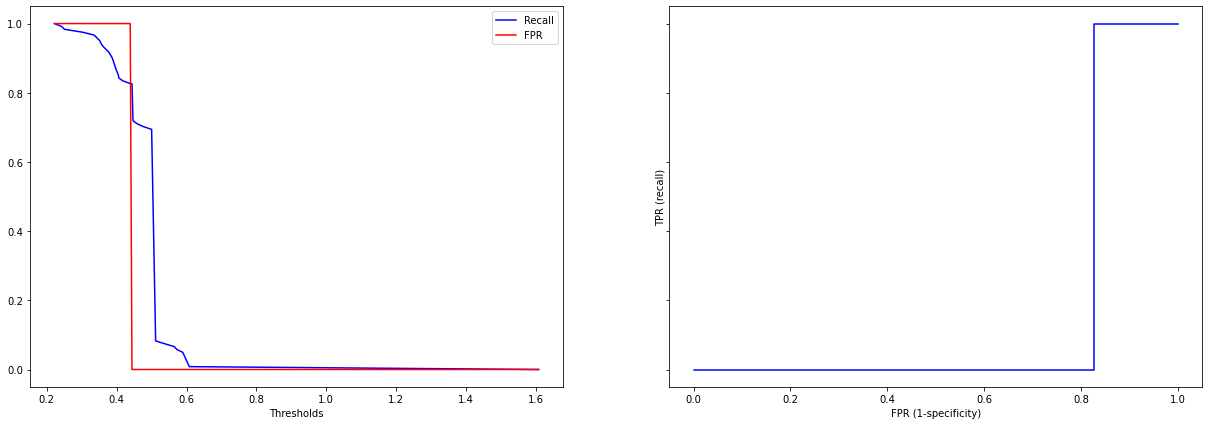

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.622465  0.339698   0.782185     0.905182  0.473100  0.596933
Validation  0.613396  0.323937   0.768046     0.903279  0.450693  0.583347


Random Forest (100 estimators)
╠■■■■■■■■■╣


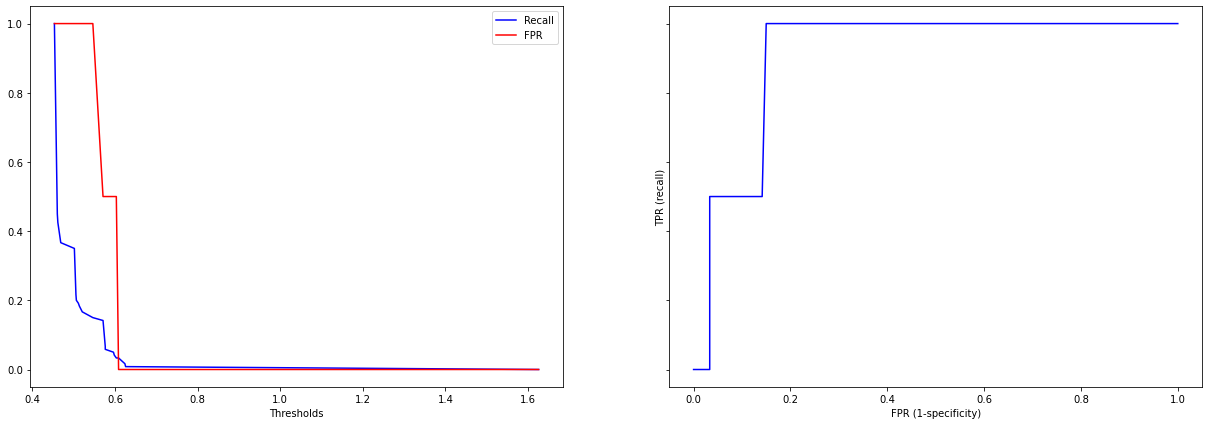

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.636921  0.475360   0.702375     0.798455  0.566841  0.666674
Validation  0.642482  0.473737   0.711952     0.811475  0.566236  0.672140


XGBoost Classifier
╠■■■■■■■■■╣


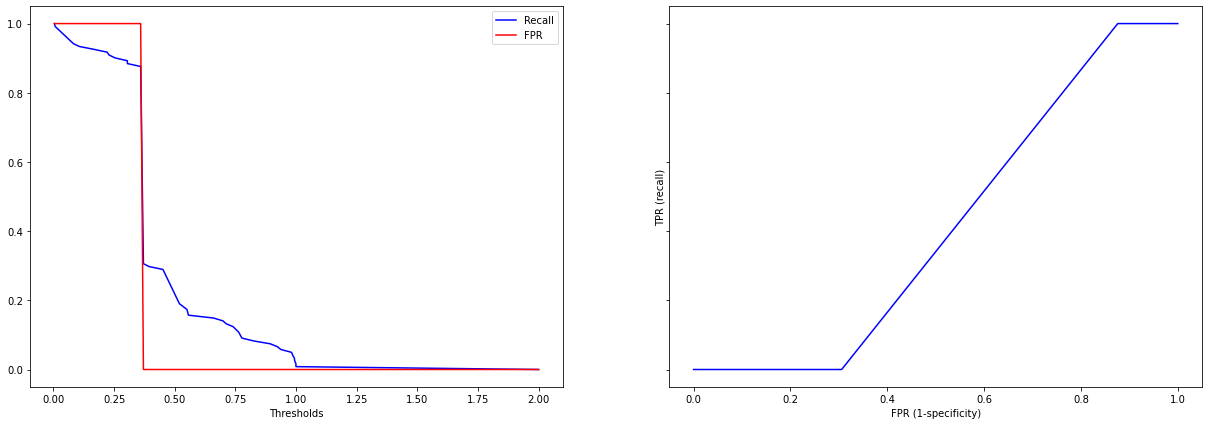

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.700336  0.505090   0.828636     0.895545  0.627488  0.748389
Validation  0.617103  0.430388   0.685030     0.804098  0.527158  0.629187


SVM
╠■■■■■■■■■╣


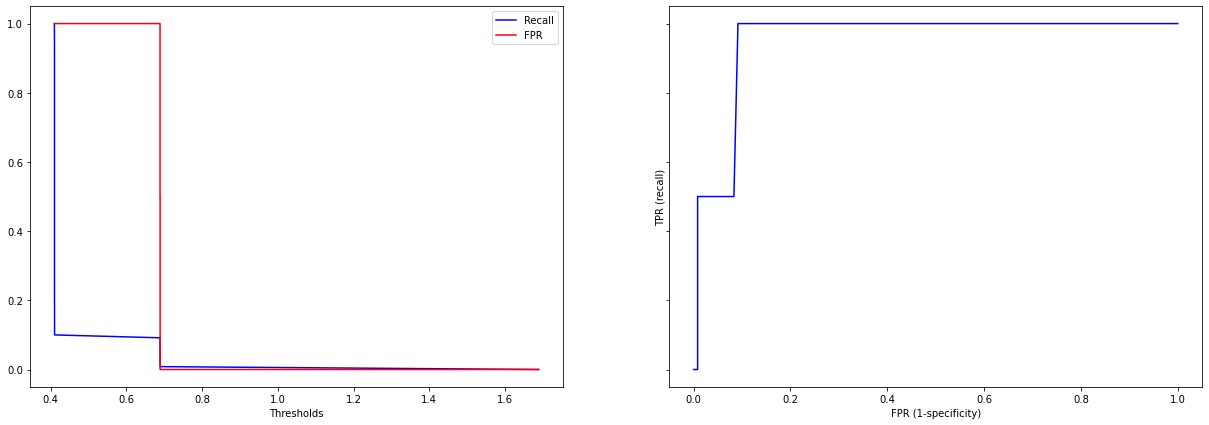

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.653378  0.449716   0.759197     0.857000  0.564276  0.679780
Validation  0.653121  0.446715   0.757197     0.859836  0.556329  0.677884


KNN
╠■■■■■■■■■╣


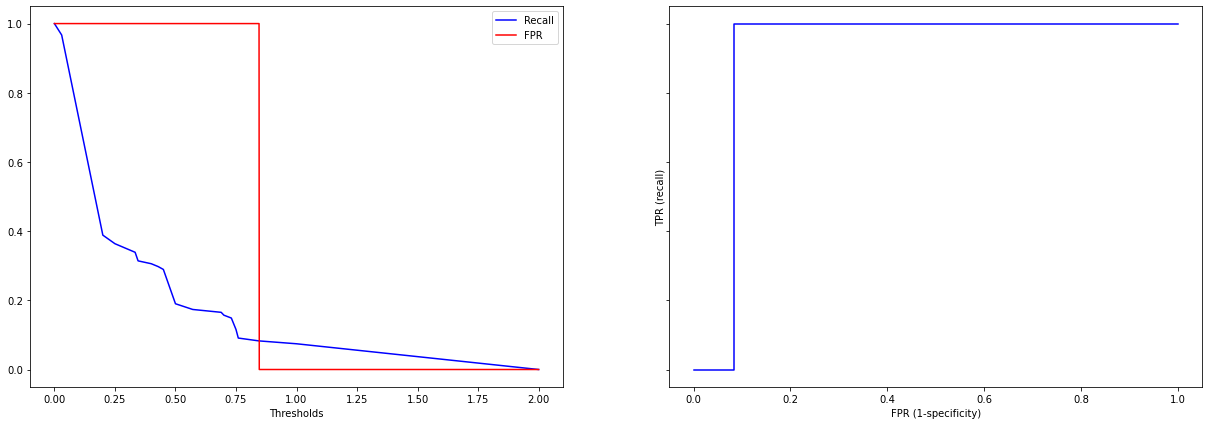

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.698791  0.488543   0.843109     0.909000  0.618533  0.737676
Validation  0.634712  0.424650   0.730242     0.845082  0.535343  0.657207


Logistic Regression
╠■■■■■■■■■╣


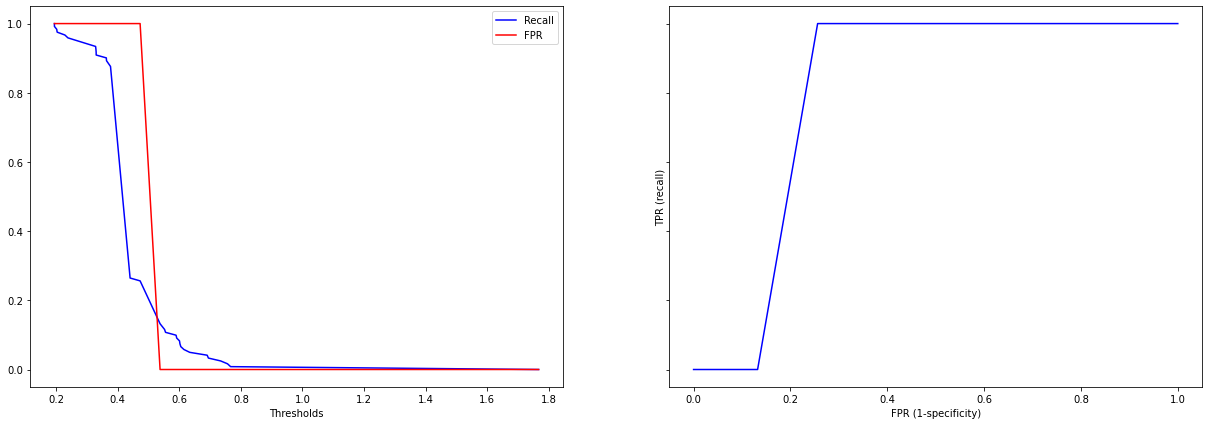

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.665470  0.484816   0.759093     0.846091  0.591573  0.687859
Validation  0.662548  0.476976   0.756400     0.848361  0.580983  0.685719

In [32]:
run_models(r_symptoms.drop(columns=["sob_severity", "cough_severity"]), y[r_symptoms.index], models, ratio_negatives_to_positives=1)

Dummy Random
╠■■■■■■■■■╣


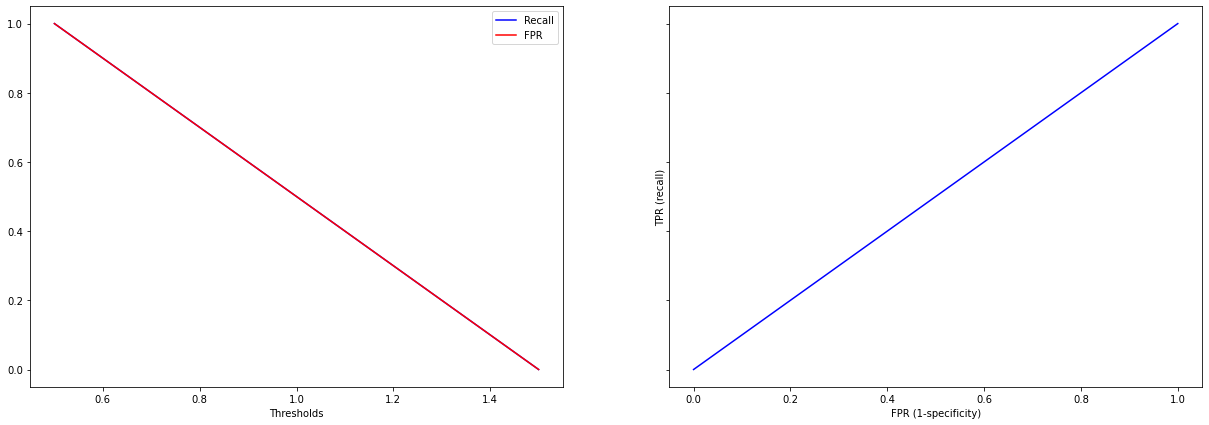

feature_importances


Permutation Importance


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500070     0.0        0.0          1.0  0.0      0.5
Validation  0.499372     0.0        0.0          1.0  0.0      0.5


MultinomialNB
╠■■■■■■■■■╣


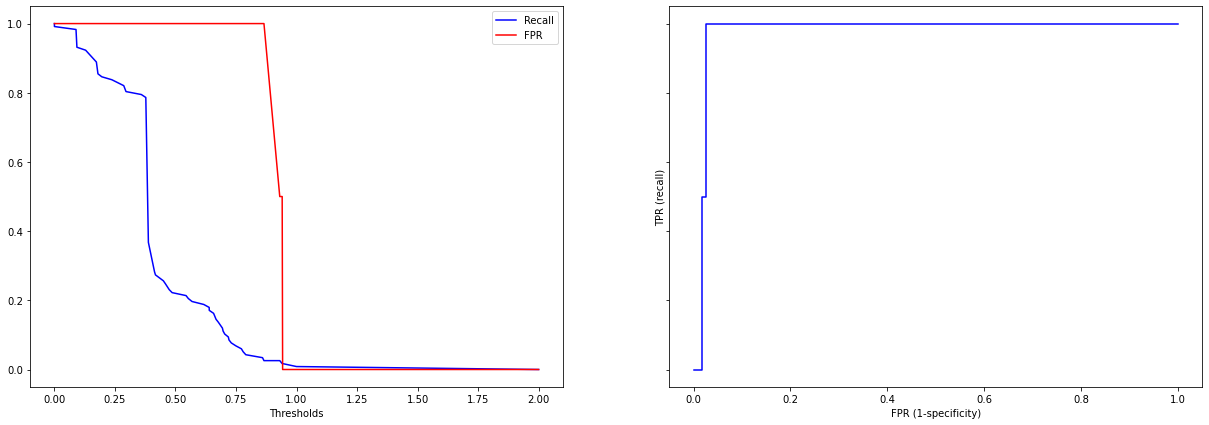

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.641337  0.496881   0.698726     0.785754  0.580733  0.680249
Validation  0.649619  0.491275   0.718243     0.808403  0.580038  0.683732


Random Forest (100 estimators)
╠■■■■■■■■■╣


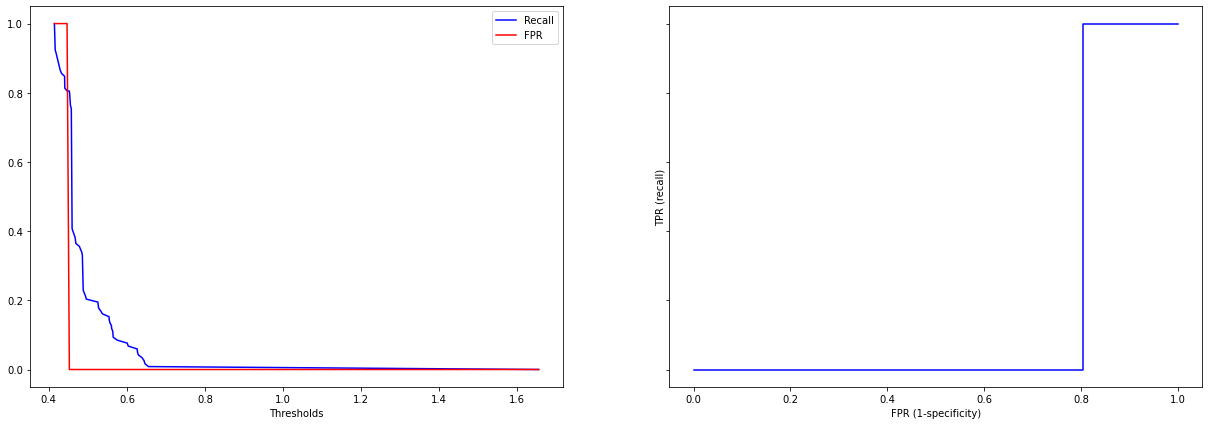

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.646739  0.508801   0.702631     0.784637  0.590042  0.686284
Validation  0.652110  0.511310   0.710140     0.793277  0.592408  0.678483


XGBoost Classifier
╠■■■■■■■■■╣


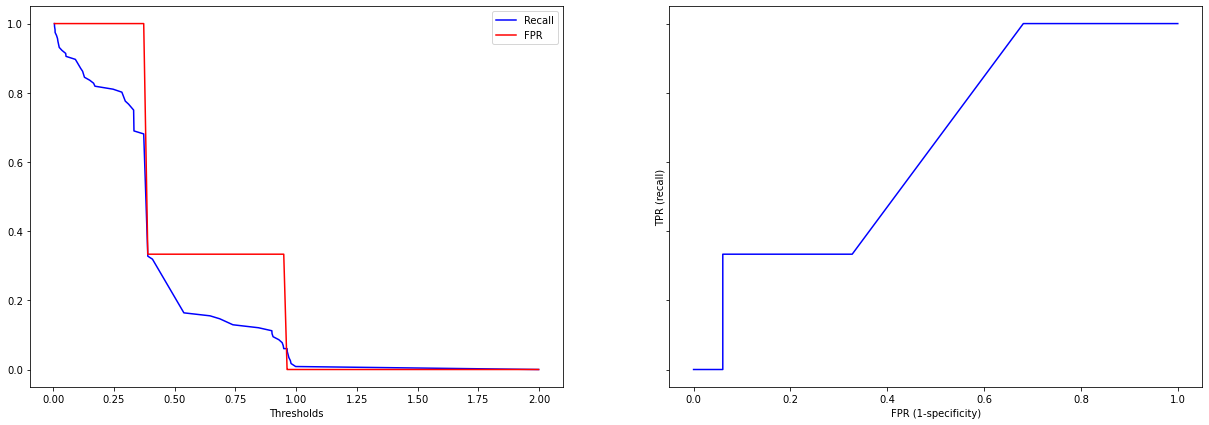

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.760116  0.589179   0.895186     0.931006  0.710553  0.836131
Validation  0.638297  0.454384   0.718078     0.822689  0.554765  0.651368


SVM
╠■■■■■■■■■╣


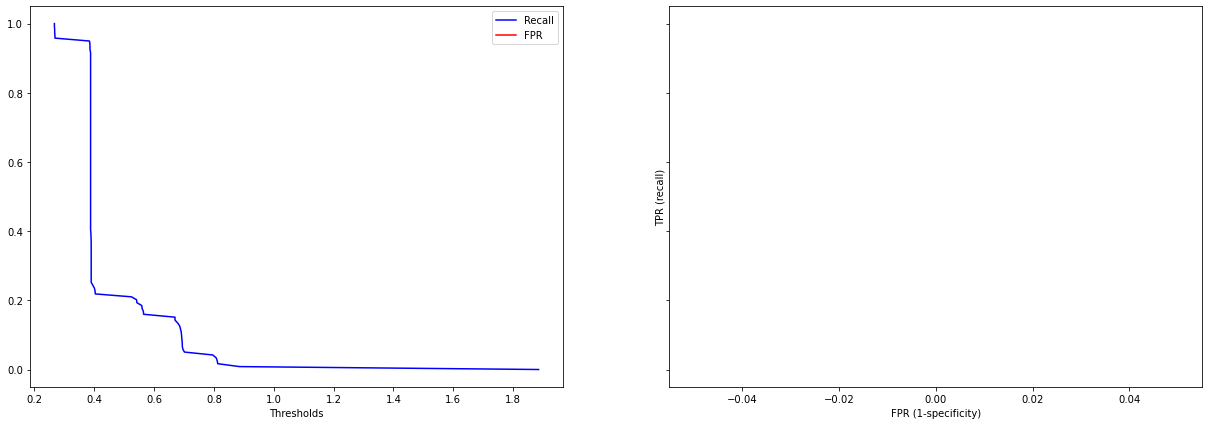

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.656516  0.456921   0.760892     0.856052  0.569986  0.702652
Validation  0.646677  0.461898   0.732479     0.831933  0.563457  0.691410


KNN
╠■■■■■■■■■╣


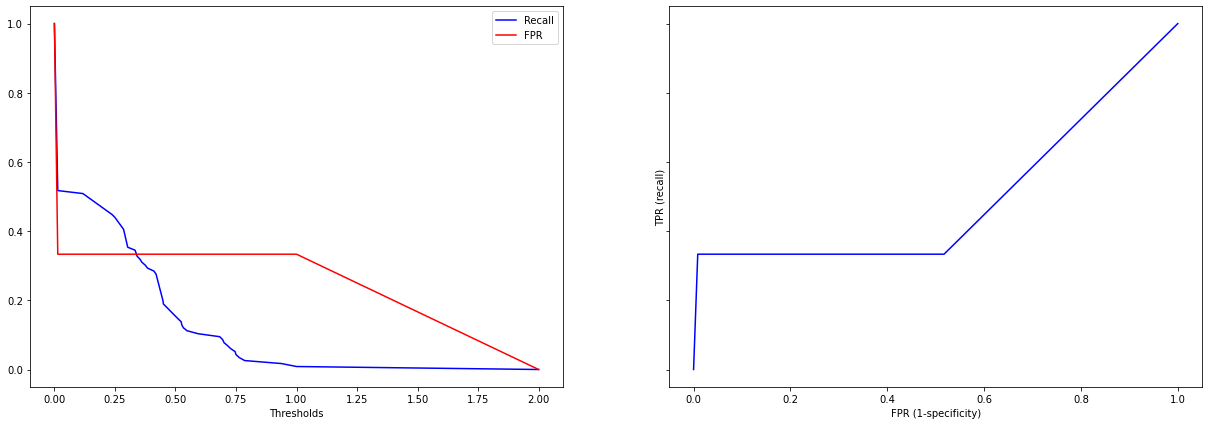

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.761792  0.566732   0.929277     0.956797  0.703934  0.803170
Validation  0.622357  0.456071   0.681299     0.789076  0.545052  0.633561


Logistic Regression
╠■■■■■■■■■╣


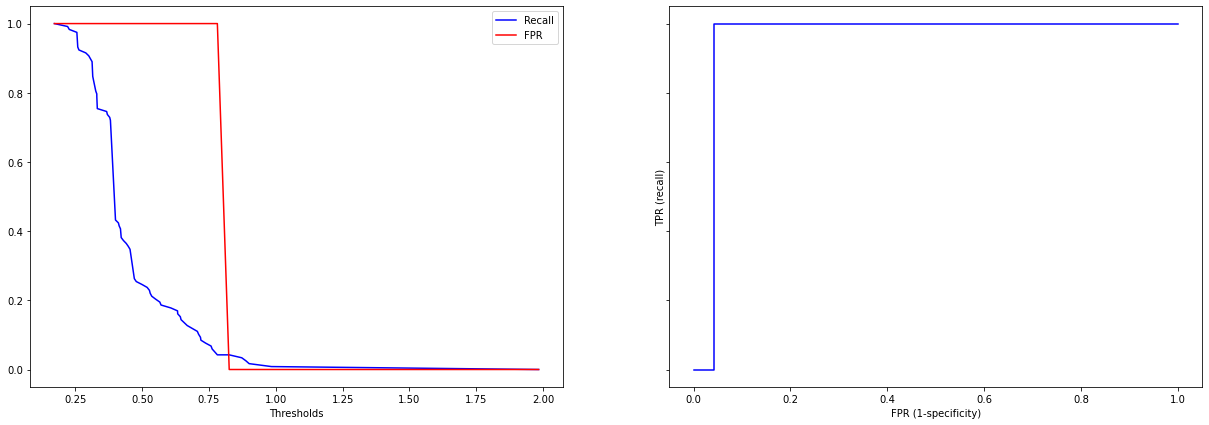

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.670765  0.521937   0.744957     0.819553  0.612751  0.715009
Validation  0.673099  0.508824   0.760364     0.837815  0.602221  0.708748

In [33]:
ra_symptoms = pd.merge(r_symptoms.drop(columns=["sob_severity", "cough_severity"]), a_symptoms, left_index=True, right_index=True)
run_models(ra_symptoms, y[ra_symptoms.index], models, ratio_negatives_to_positives=1)

Dummy Random
╠■■■■■■■■■╣


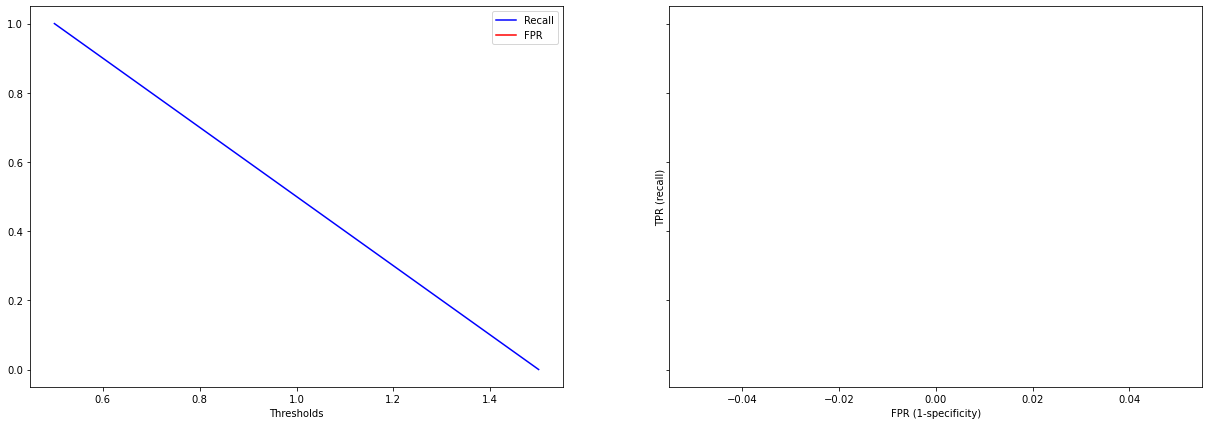

feature_importances


Permutation Importance


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500045     0.0        0.0          1.0  0.0      0.5
Validation  0.499592     0.0        0.0          1.0  0.0      0.5


MultinomialNB
╠■■■■■■■■■╣


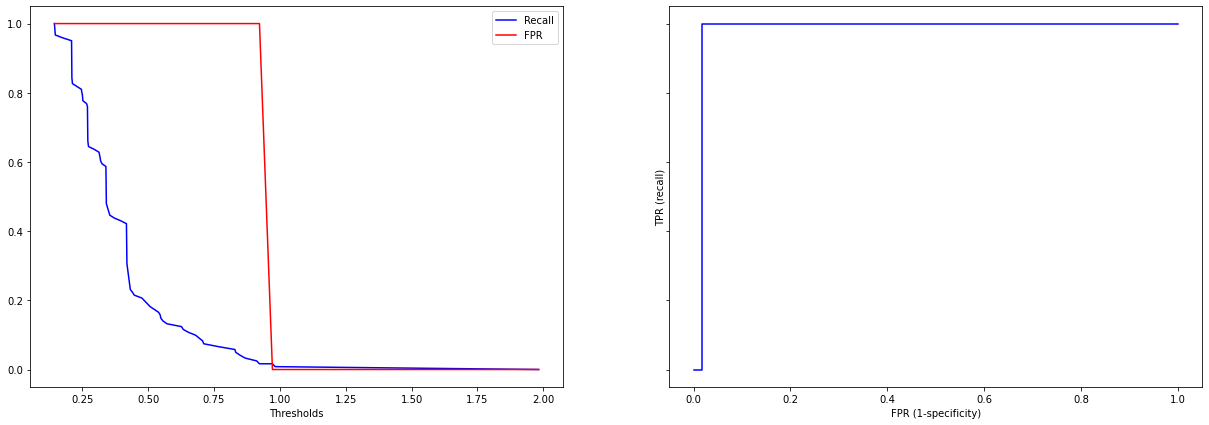

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.644558  0.468721   0.722976     0.820364  0.568656  0.679301
Validation  0.645791  0.468919   0.723046     0.822951  0.566091  0.672967


Random Forest (100 estimators)
╠■■■■■■■■■╣


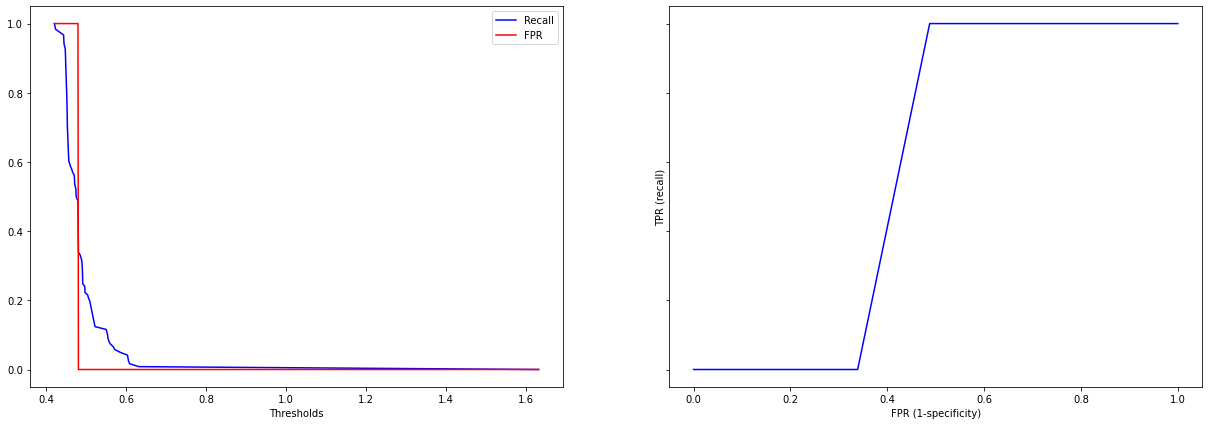

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.636148  0.473994   0.701662     0.798273  0.565658  0.676152
Validation  0.638401  0.472964   0.704379     0.804098  0.562538  0.668238


XGBoost Classifier
╠■■■■■■■■■╣


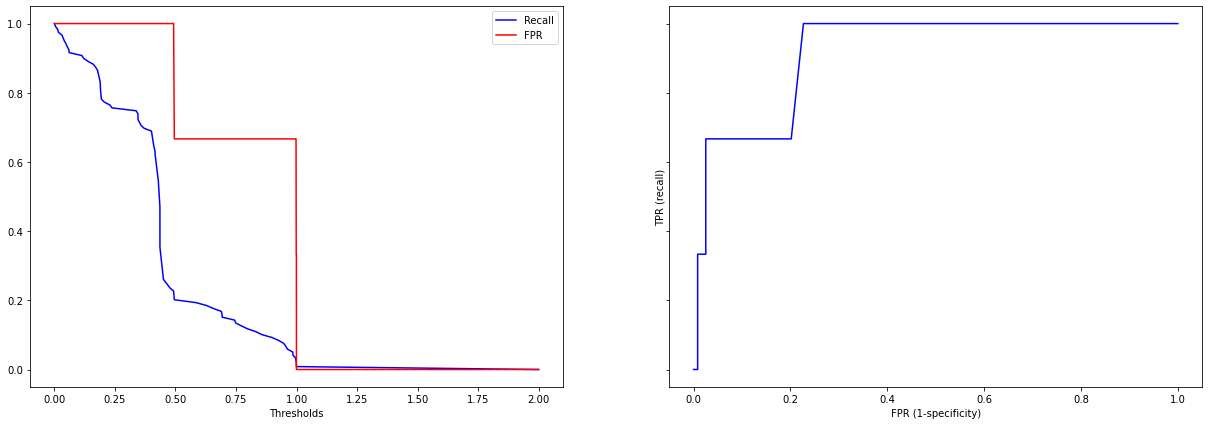

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.750932  0.573923   0.889055     0.927909  0.697349  0.834607
Validation  0.633484  0.462275   0.702022     0.804918  0.555314  0.658614


SVM
╠■■■■■■■■■╣


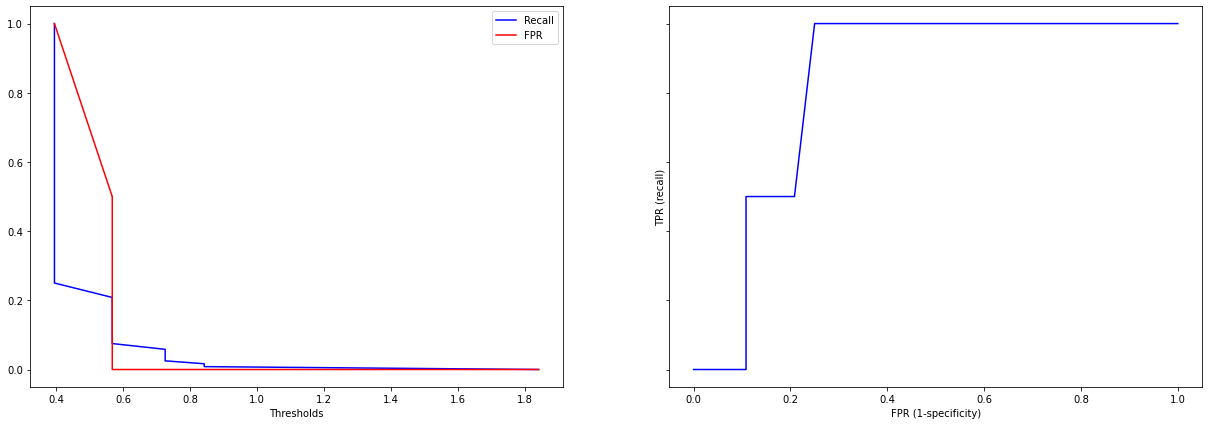

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.661832  0.482915   0.755471     0.840727  0.587439  0.700886
Validation  0.653965  0.472884   0.746627     0.835246  0.571377  0.684049


KNN
╠■■■■■■■■■╣


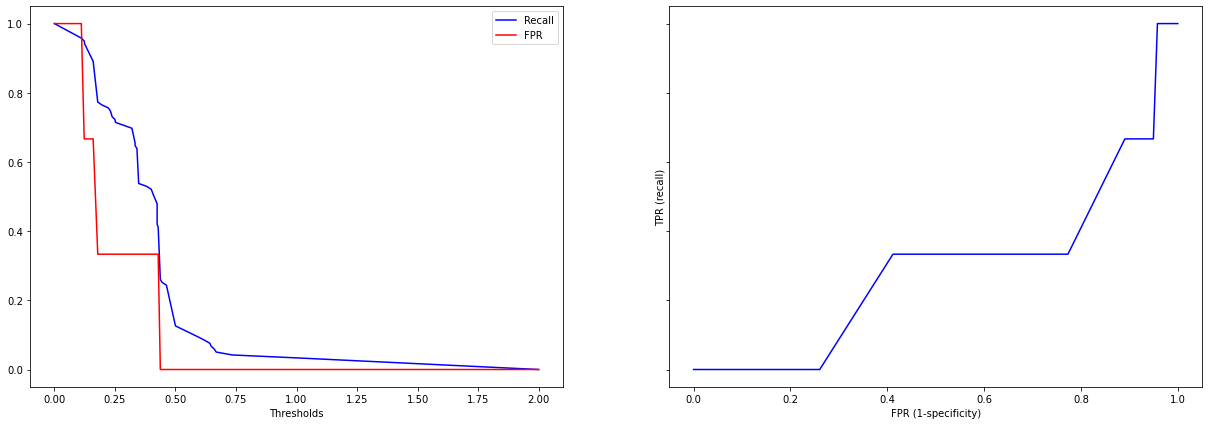

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.752295  0.547917   0.926813     0.956636  0.688552  0.807033
Validation  0.616281  0.392730   0.709630     0.840164  0.503150  0.621577


Logistic Regression
╠■■■■■■■■■╣


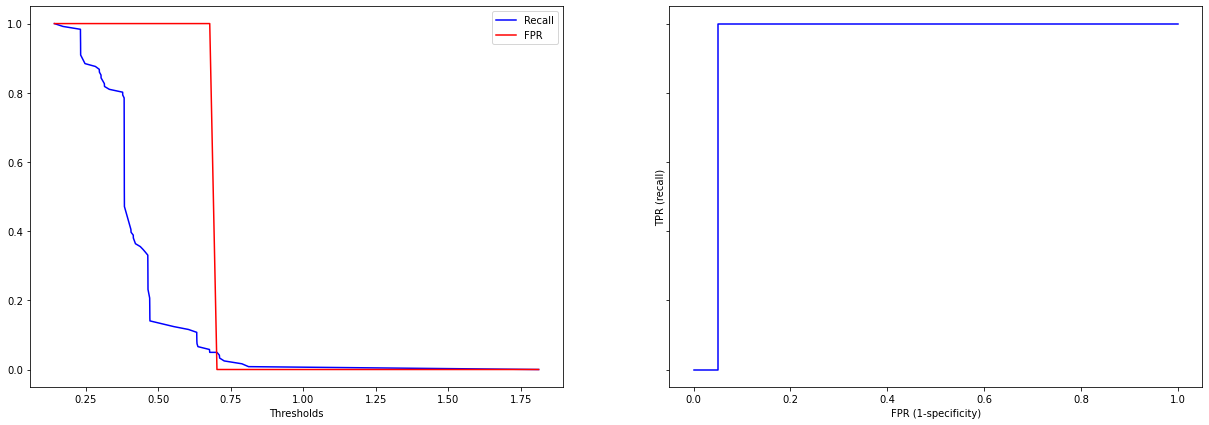

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.660150  0.500454   0.736417     0.819818  0.595332  0.704588
Validation  0.657653  0.485246   0.739964     0.830328  0.583703  0.695369

In [34]:
r_symptoms_ex = pd.merge(r_symptoms.drop(columns=["sob", "cough"]), e_factors, left_index=True, right_index=True)
run_models(r_symptoms_ex, y[r_symptoms_ex.index], models, ratio_negatives_to_positives=1)

Dummy Random
╠■■■■■■■■■╣


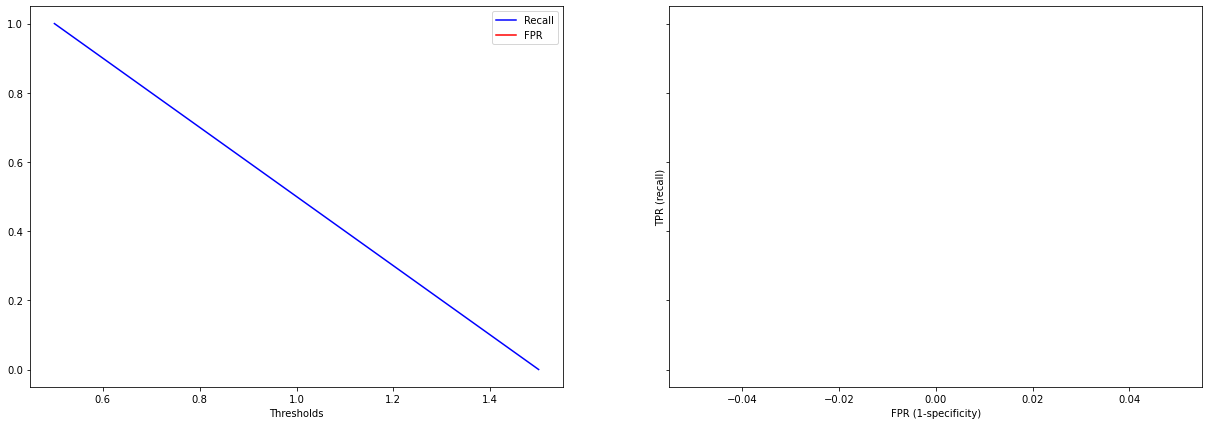

feature_importances


Permutation Importance


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500227     0.0        0.0          1.0  0.0      0.5
Validation  0.497945     0.0        0.0          1.0  0.0      0.5


MultinomialNB
╠■■■■■■■■■╣


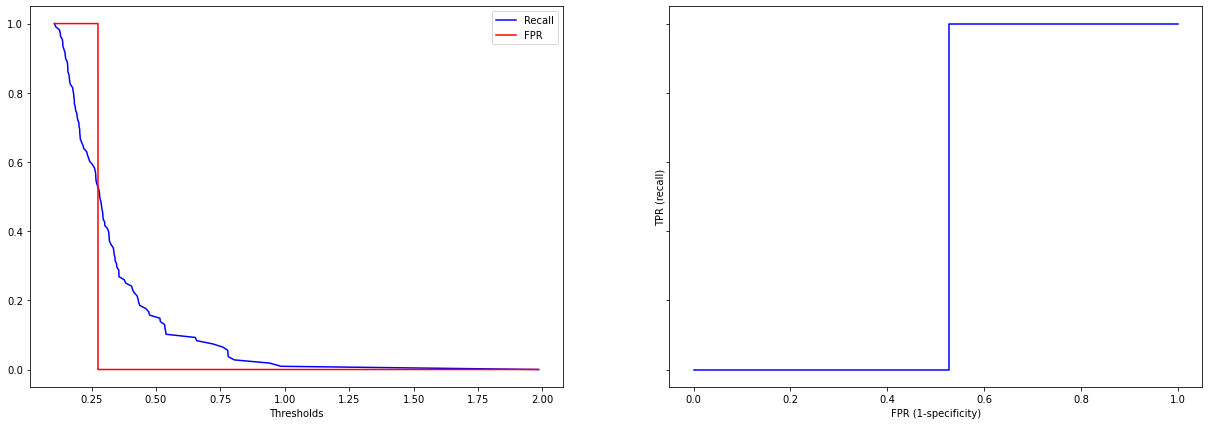

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.657217  0.516226   0.718696     0.798081  0.600826  0.702691
Validation  0.656472  0.511426   0.720789     0.802752  0.595618  0.705771


Random Forest (100 estimators)
╠■■■■■■■■■╣


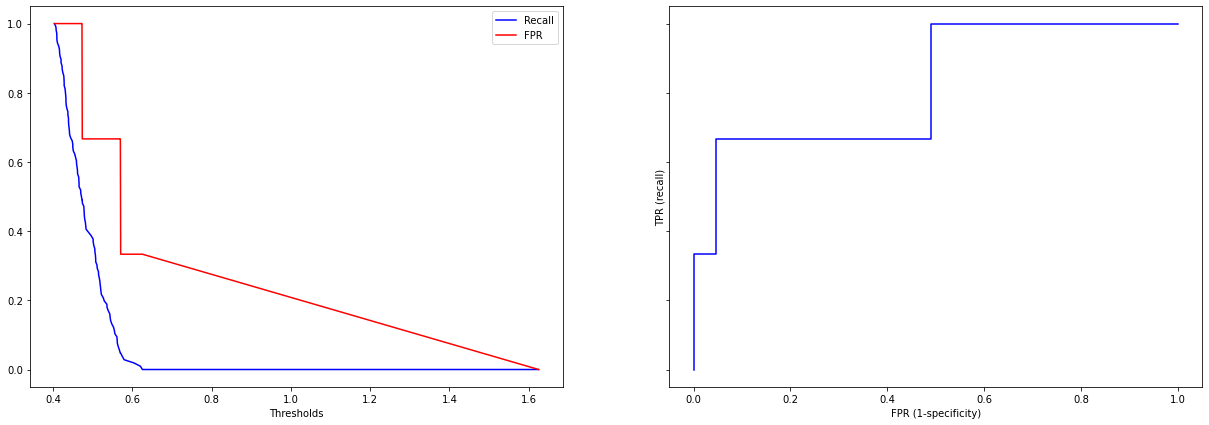

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.660401  0.564657   0.698518     0.756061  0.624178  0.719204
Validation  0.644585  0.546864   0.682190     0.743119  0.602575  0.700130


XGBoost Classifier
╠■■■■■■■■■╣


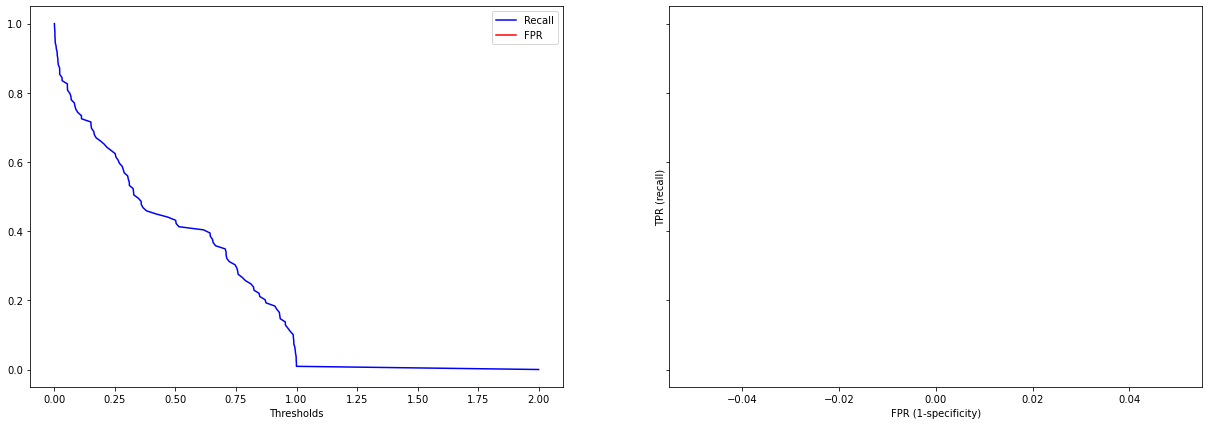

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999141  0.999393   0.998889     0.998889  0.999141  0.999998
Validation  0.622640  0.605947   0.627621     0.639450  0.615779  0.668496


SVM
╠■■■■■■■■■╣


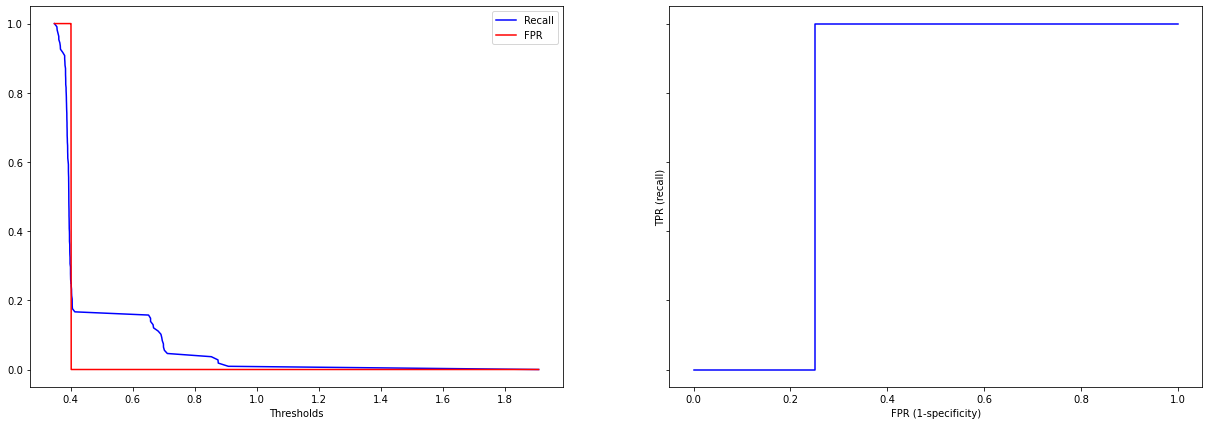

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.664191  0.465069   0.773503     0.863131  0.580070  0.737047
Validation  0.667442  0.455888   0.788723     0.880734  0.573655  0.730201


KNN
╠■■■■■■■■■╣


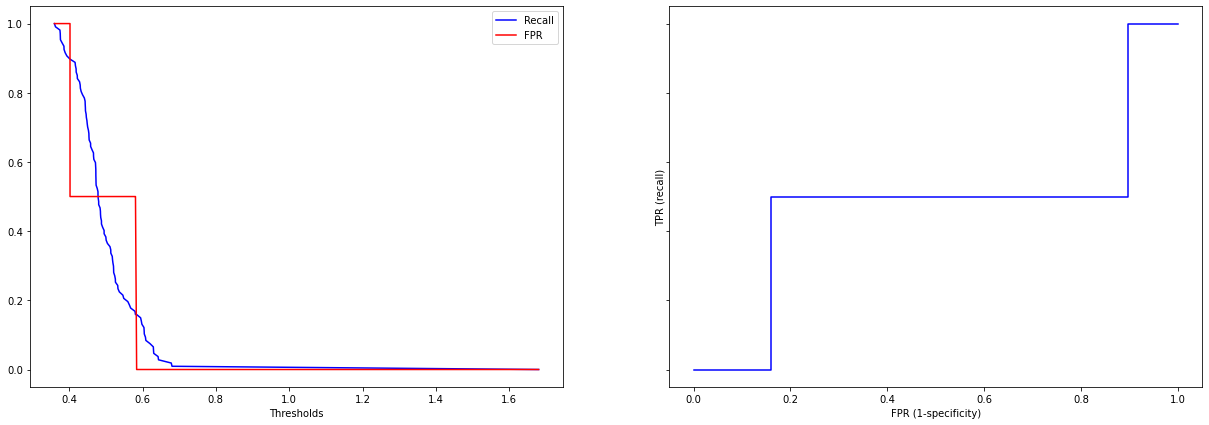

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999596  0.999191   1.000000     1.000000  0.999595  0.999999
Validation  0.559160  0.502219   0.567011     0.616514  0.531068  0.588397


Logistic Regression
╠■■■■■■■■■╣


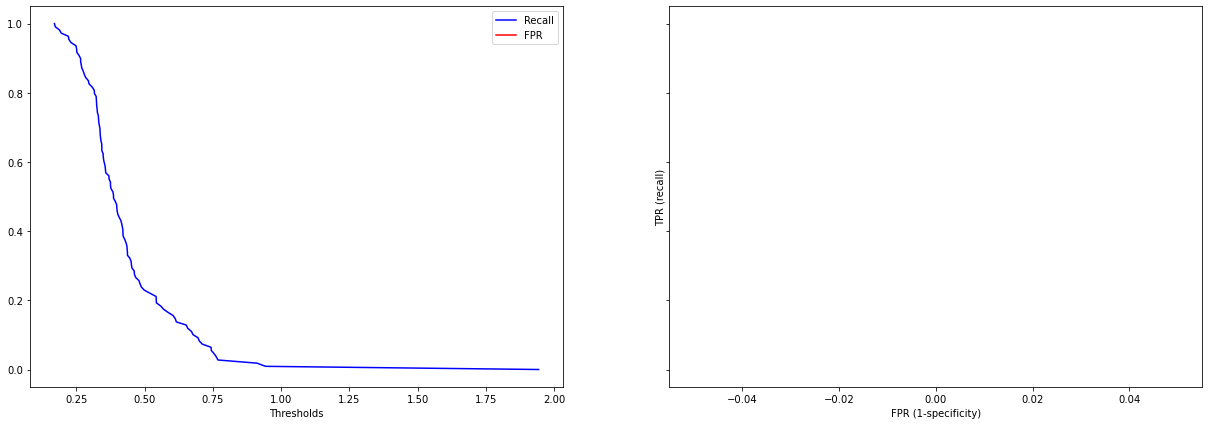

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.667374  0.541300   0.723898     0.793333  0.619273  0.726732
Validation  0.658299  0.525054   0.716616     0.792661  0.603933  0.723771

In [35]:
r_symptoms_vitals = pd.merge(r_symptoms.drop(columns=["sob_severity", "cough_severity"]), vitals, left_index=True, right_index=True)
run_models(r_symptoms_vitals, y[r_symptoms_vitals.index], models, ratio_negatives_to_positives=1)

Dummy Random
╠■■■■■■■■■╣


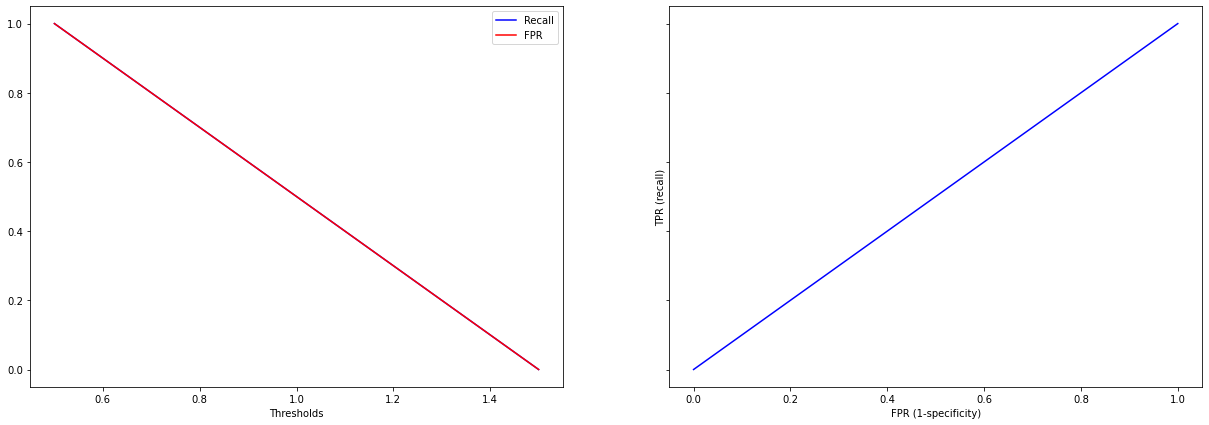

feature_importances


Permutation Importance


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500127     0.0        0.0          1.0  0.0      0.5
Validation  0.498858     0.0        0.0          1.0  0.0      0.5


MultinomialNB
╠■■■■■■■■■╣


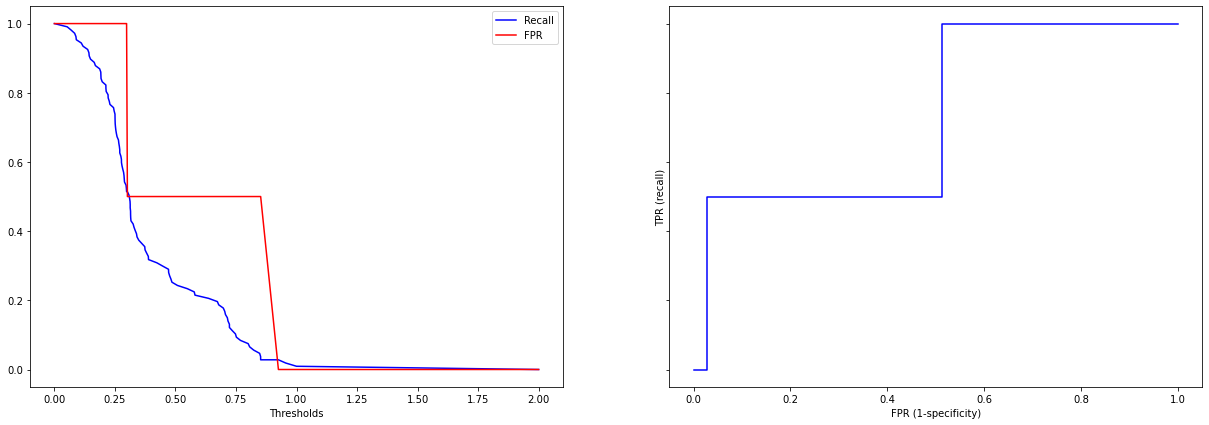

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.656709  0.535767   0.707434     0.777586  0.609352  0.706624
Validation  0.649876  0.529691   0.697988     0.770642  0.600098  0.700076


Random Forest (100 estimators)
╠■■■■■■■■■╣


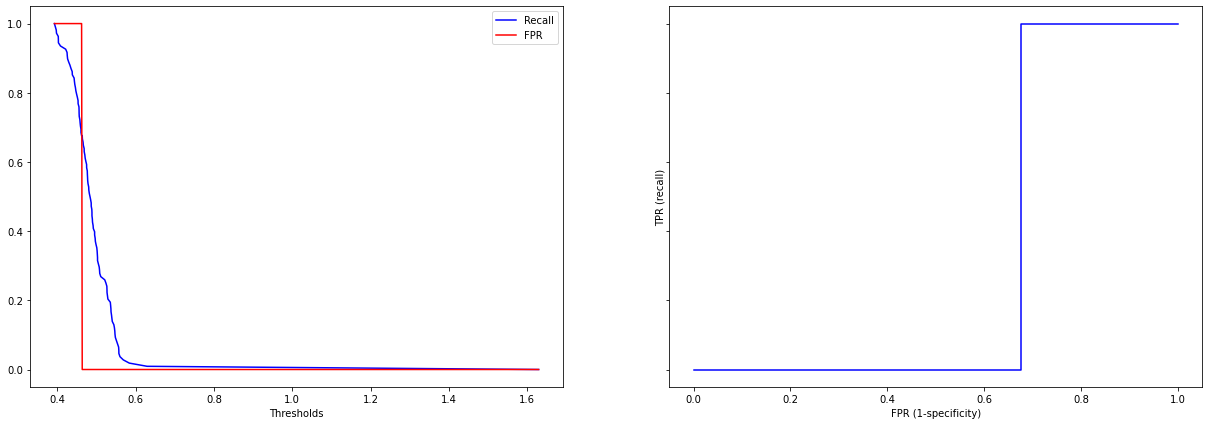

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.666193  0.582037   0.699794     0.750304  0.635367  0.724808
Validation  0.640241  0.566997   0.662765     0.713761  0.608985  0.688333


XGBoost Classifier
╠■■■■■■■■■╣


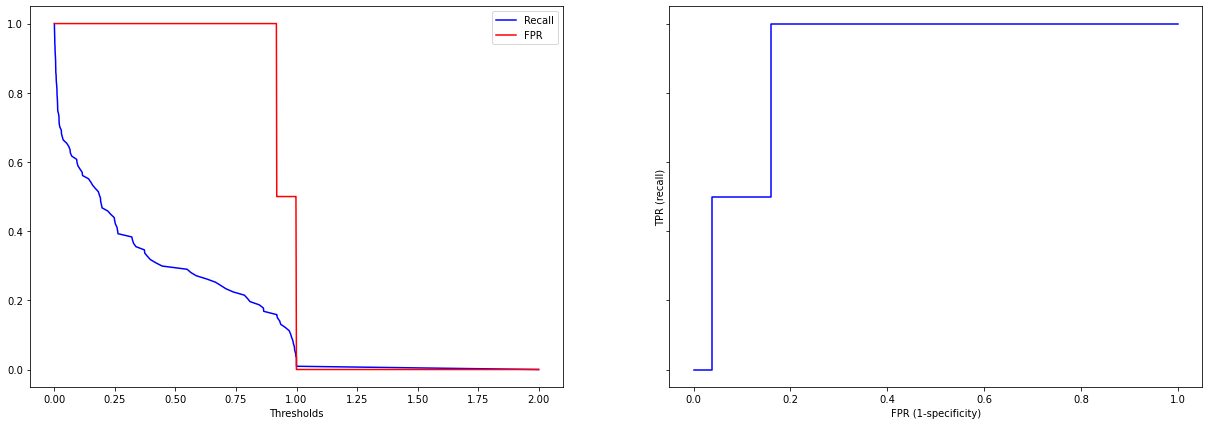

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999899  0.999797   1.000000     1.000000  0.999898  1.000000
Validation  0.627420  0.589900   0.639825     0.665138  0.612683  0.674383


SVM
╠■■■■■■■■■╣


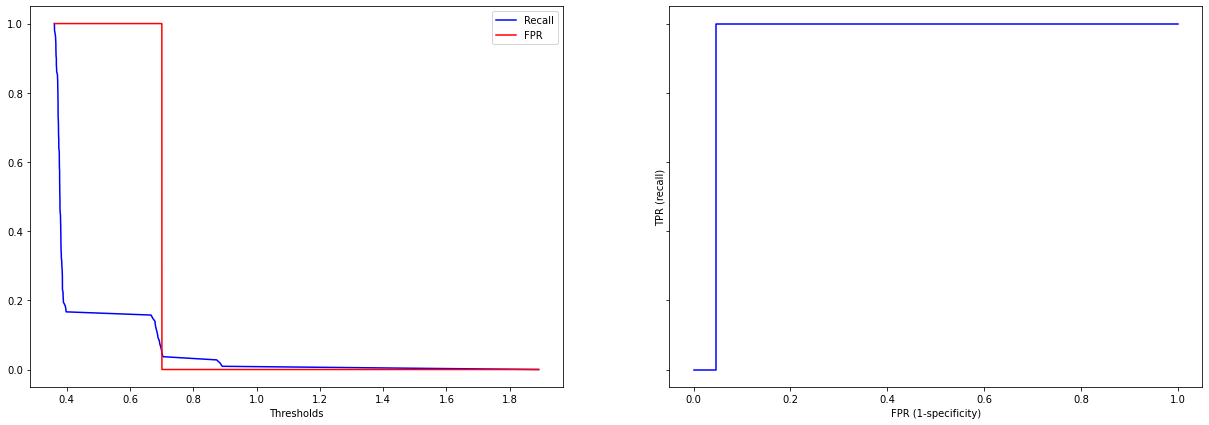

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.668070  0.486862   0.763934     0.849189  0.594232  0.737817
Validation  0.652618  0.470250   0.736059     0.835780  0.569830  0.722247


KNN
╠■■■■■■■■■╣


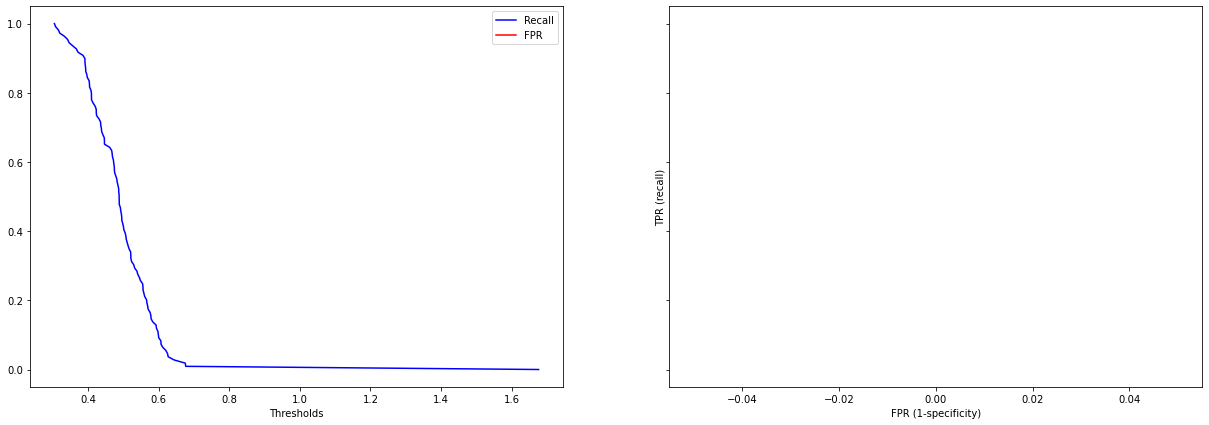

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999493  0.998985   1.000000     1.000000  0.999492  0.999999
Validation  0.572085  0.493028   0.587185     0.651376  0.533514  0.621712


Logistic Regression
╠■■■■■■■■■╣


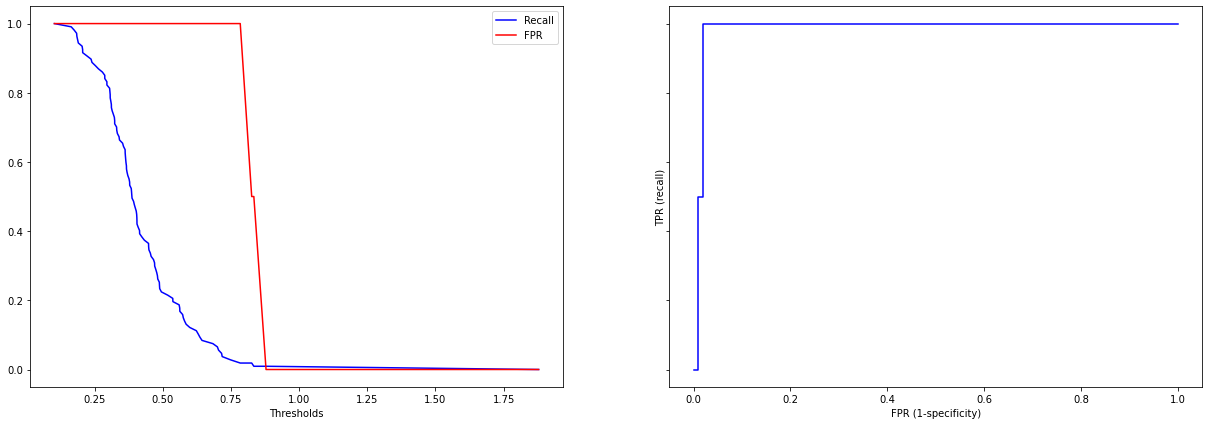

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.675323  0.557787   0.729058     0.792799  0.631950  0.736615
Validation  0.661774  0.546122   0.710063     0.777982  0.615444  0.713937

In [36]:
ra_symptoms_vitals = pd.merge(ra_symptoms, vitals, left_index=True, right_index=True)
run_models(ra_symptoms_vitals, y[ra_symptoms_vitals.index], models, ratio_negatives_to_positives=1)

Dummy Random
╠■■■■■■■■■╣


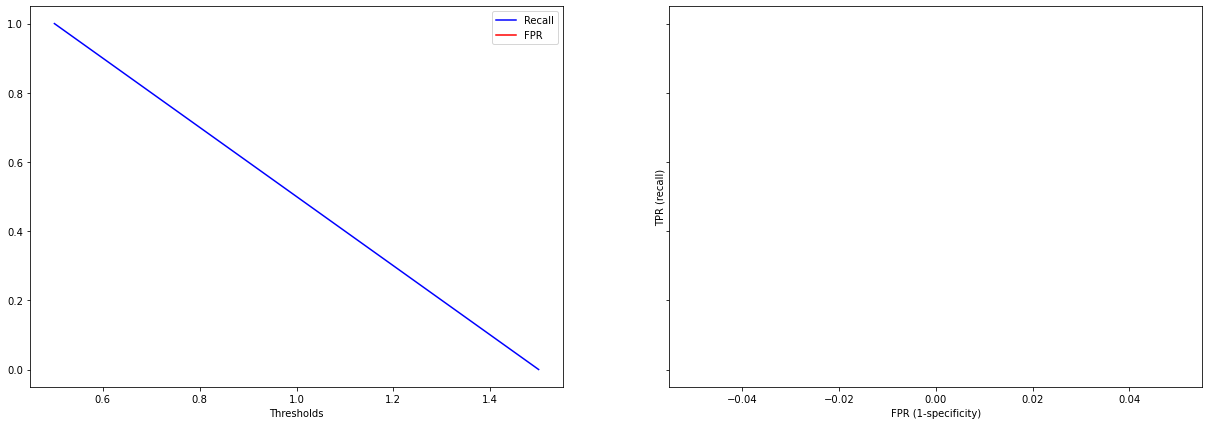

feature_importances


Permutation Importance


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500045     0.0        0.0          1.0  0.0      0.5
Validation  0.499592     0.0        0.0          1.0  0.0      0.5


MultinomialNB
╠■■■■■■■■■╣


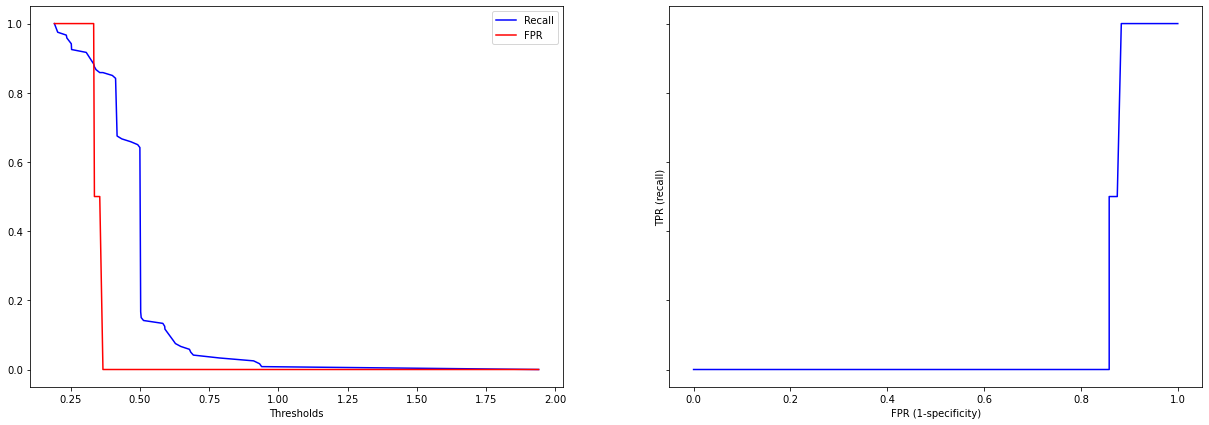

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.640512  0.410436   0.760134     0.870545  0.533023  0.644722
Validation  0.624476  0.403352   0.722422     0.845902  0.514264  0.623903


Random Forest (100 estimators)
╠■■■■■■■■■╣


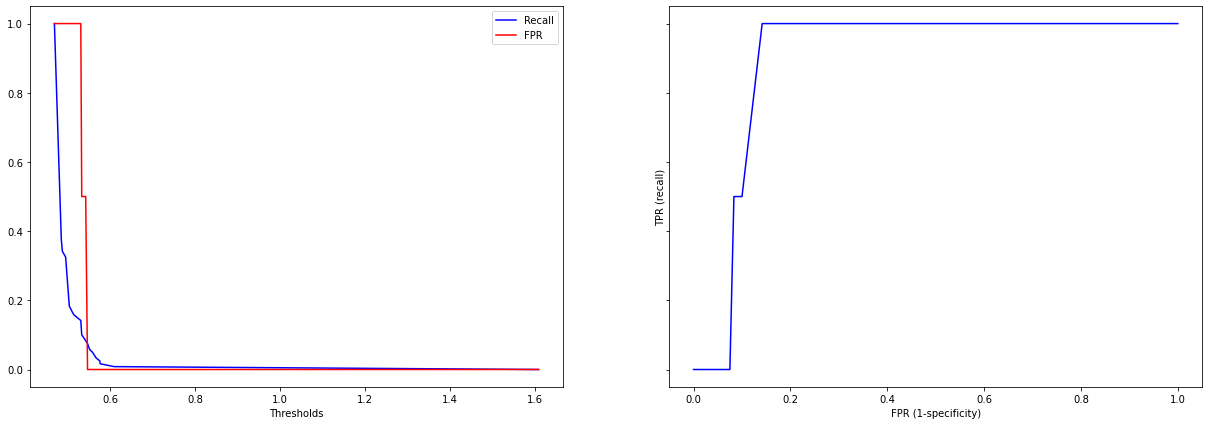

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.637603  0.473541   0.704919     0.801636  0.566407  0.666595
Validation  0.632685  0.472131   0.692967     0.793443  0.558408  0.658082


XGBoost Classifier
╠■■■■■■■■■╣


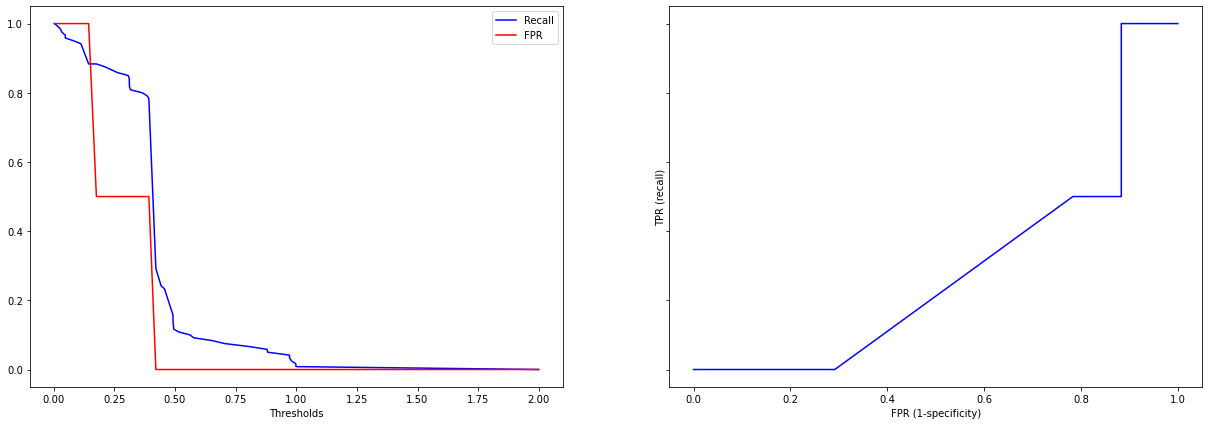

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.718701  0.530458   0.850930     0.906909  0.653360  0.781040
Validation  0.635938  0.440244   0.723695     0.831967  0.545658  0.656315


SVM
╠■■■■■■■■■╣


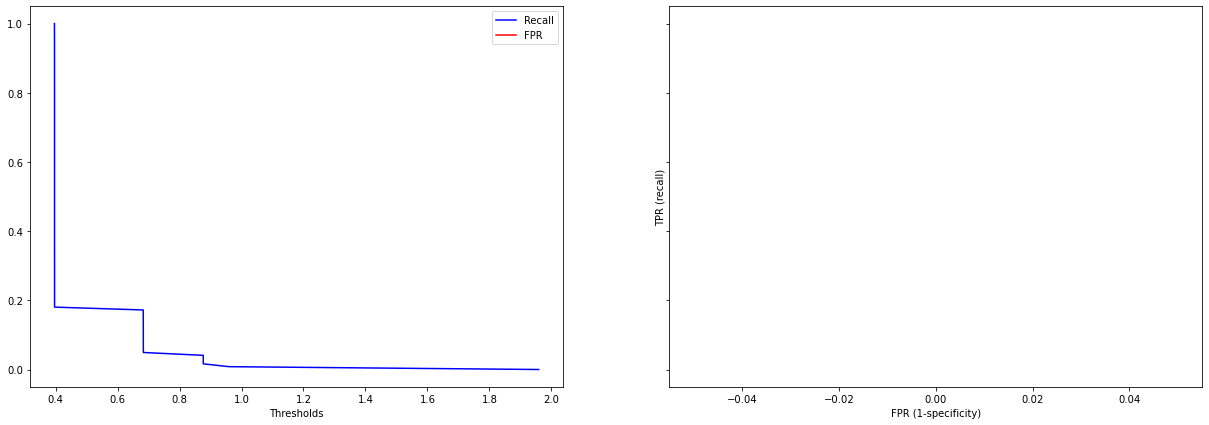

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.655287  0.457990   0.757427     0.852545  0.569887  0.695807
Validation  0.654769  0.453279   0.754469     0.856557  0.562566  0.687511


KNN
╠■■■■■■■■■╣


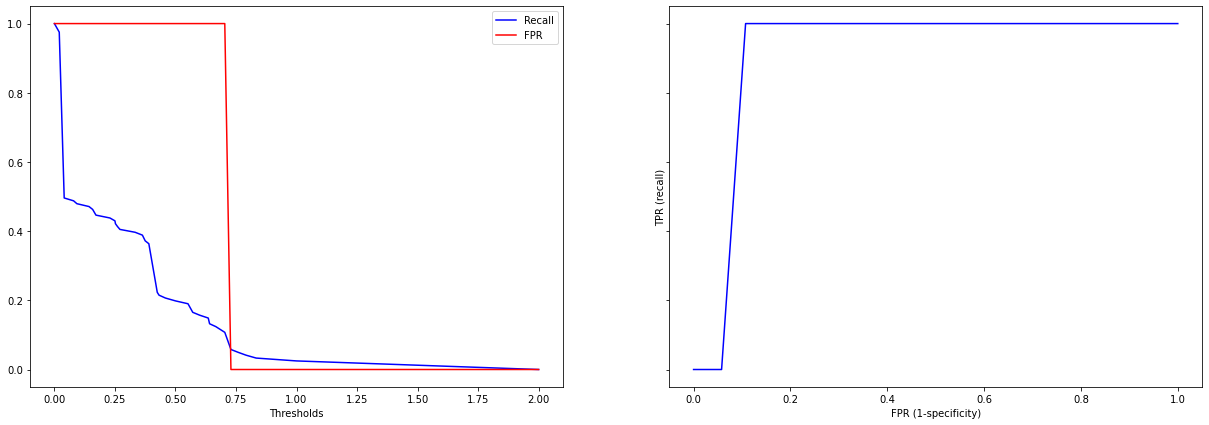

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.712747  0.505364   0.863649     0.920091  0.637487  0.758449
Validation  0.631445  0.426329   0.721417     0.836885  0.533931  0.633934


Logistic Regression
╠■■■■■■■■■╣


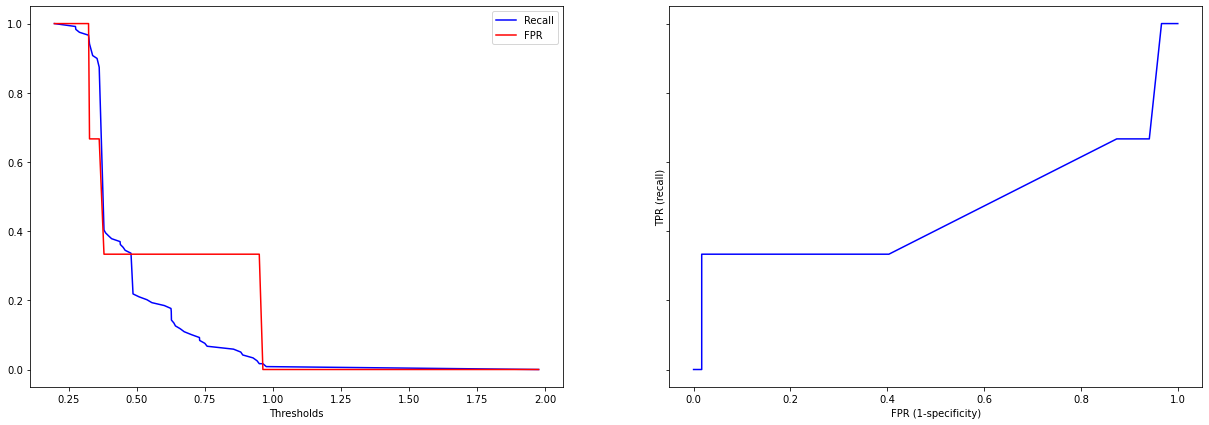

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.669697  0.502907   0.756301     0.836455  0.603247  0.707154
Validation  0.655176  0.491737   0.731582     0.818852  0.583371  0.693506

In [37]:
r_symptoms_comorb = pd.merge(r_symptoms.drop(columns=["sob_severity", "cough_severity"]), comorb, left_index=True, right_index=True)
run_models(r_symptoms_comorb, y[r_symptoms_comorb.index], models, ratio_negatives_to_positives=1)

In [38]:
a = pd.Series(np.array([True, False, True, False]))
b = pd.Series(np.array([True, True, False, False]))

In [39]:
(a ^ b)

0    False
1     True
2     True
3    False
dtype: bool

Next step is to determine which features are useful in the case of each dataset, eliminating them one by one(and maybe applying normalization to the vitals).
After that, we select the 2 (first just 2) best models and somehow combine them to make an ensemble model.<br>
<i>Idea: One model for each metric so 4 models with the highest metrics and then figure out some boolean operation to combine them</i><br>
<i>Idea 2: The boolean operation can be found by using a Decision Tree. After all they are good at finding simple rules</i><br>
<i>Idea 3: The boolean operation taking the highest precision and the highest recall would be an AND. Maybe the inverse for another 2 metrics as well</i>

In [40]:
class CustomModel():

    def __init__(self):
        self.model_1 = LogisticRegression() #The best model (has very high accuracy and precission but not very good recall. Good for determining Positive results)
        self.model_2 = RandomForestClassifier() #The one with the best recall. Poor specificity and precision but high recall. Good for determining Negative results
        self.model_3 = XGBAdapter() #The one with high accuracy, and balanced recall and precision. If none of the other 2 are sure this is the tie breaker
        self.imputer = Imputer()
        
    def fit(self, data_x, data_y):
        self.imputer.fit(data_x, data_y)
        
        data_1 = data_x.iloc[:,16:]
        data_2 = data_x.iloc[:,:10]
        data_3 = pd.merge(data_x.iloc[:,10-16].drop(columns=["sys", "dia"]), data_x.iloc[:,21:], left_index=True, right_index=True)
        self.model_1.fit(data_1, data_y[data_1.index])
        self.model_2.fit(data_2, data_y[data_2.index])
        self.model_3.fit(data_3, data_y[data_3.index])
        
    def predict(self, data_x):
        data_1 = data_x.iloc[:,16:]
        data_2 = data_x.iloc[:,:10]
        data_3 = pd.merge(data_x.iloc[:,10-16].drop(columns=["sys", "dia"]), data_x.iloc[:,21:], left_index=True, right_index=True)
                
        preds_1 = self.model_1.predict(data_1)
        preds_2 = self.model_2.predict(data_2)
        preds_3 = self.model_3.predict(data_3)
        
        preds_1[preds_1 == "Positive"] = True
        preds_1[preds_1 == "Negative"] = False
        preds_2[preds_2 == "Positive"] = True
        preds_2[preds_2 == "Negative"] = False
        preds_3[preds_3 == "Positive"] = True
        preds_3[preds_3 == "Negative"] = False
        
        final_preds = ((preds_1)| (preds_2 & preds_3)) #If predicted positive by model 1 then we keep that prediction. If predicted negative by model 2, we try to keep it. In case preds1 is False and preds2 is True the final decision is with preds3
        
        #final_preds = np.sum(np.array([preds_1, preds_2, preds_3]), axis = 0)
        
        #final_preds[final_preds <=1] = "Negative"
        #final_preds[final_preds != "Negative" ] = "Positive"
        final_preds[final_preds == True] = "Positive"
        final_preds[final_preds == False] = "Negative"
        
        
        return final_preds

In [41]:
run_models(X, y, {"FirstEnsembleModel" : CustomModel()}, folds=10, ratio_negatives_to_positives=1)

FirstEnsembleModel
'CustomModel' object has no attribute 'predict_proba'


In [42]:
weights=(np.ones(y[ra_symptoms_vitals.index].shape) + (y[ra_symptoms_vitals.index]=="Negative"))

In [43]:
ensemble_models = {
    "LogisticVanilla" : LogisticRegression(),
    "LogisticStrongRegularization" : LogisticRegression(C=.5),
    "LogisticWeakRegularization" : LogisticRegression(C=2),
    "Logisctic"
    "AdaBoost" : AdaBoostClassifier(base_estimator=LogisticRegression())
}



Ada
╠■■■■■■■■■╣


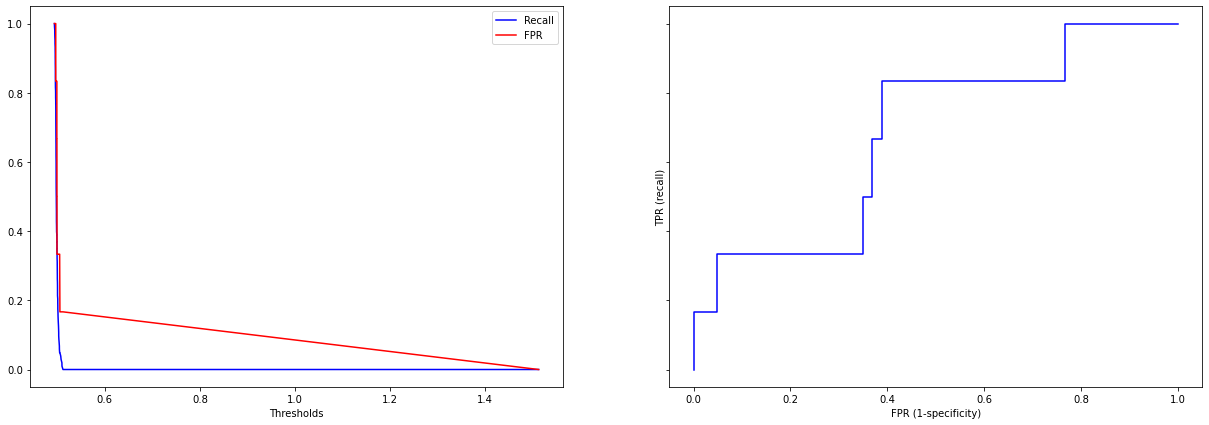

feature_importances
Unable to compute feature importances since base_estimator does not have a feature_importances_ attribute


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.679635  0.580719   0.724021     0.778499  0.644333  0.736663
Validation  0.674153  0.564379   0.722115     0.784404  0.630568  0.727104

In [44]:
run_models(ra_symptoms_vitals, y[ra_symptoms_vitals.index], {"Ada" : AdaBoostClassifier(base_estimator=LogisticRegression())}, folds=10, ratio_negatives_to_positives=1)

LogisticVanilla
╠■■■■■■■■■╣


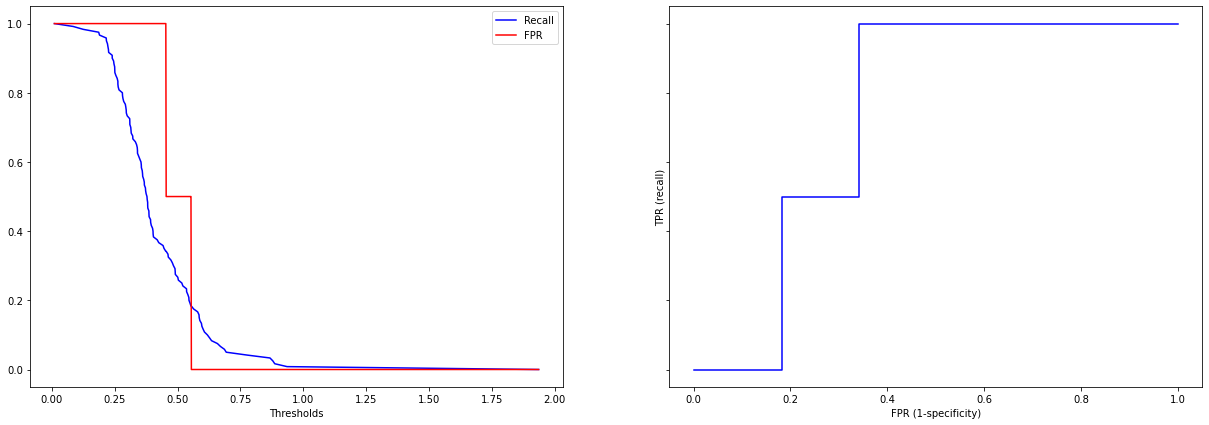

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.674879  0.582105   0.714777     0.767636  0.641552  0.745646
Validation  0.652713  0.559596   0.687378     0.745902  0.616032  0.717531


LogisticStrongRegularization
╠■■■■■■■■■╣


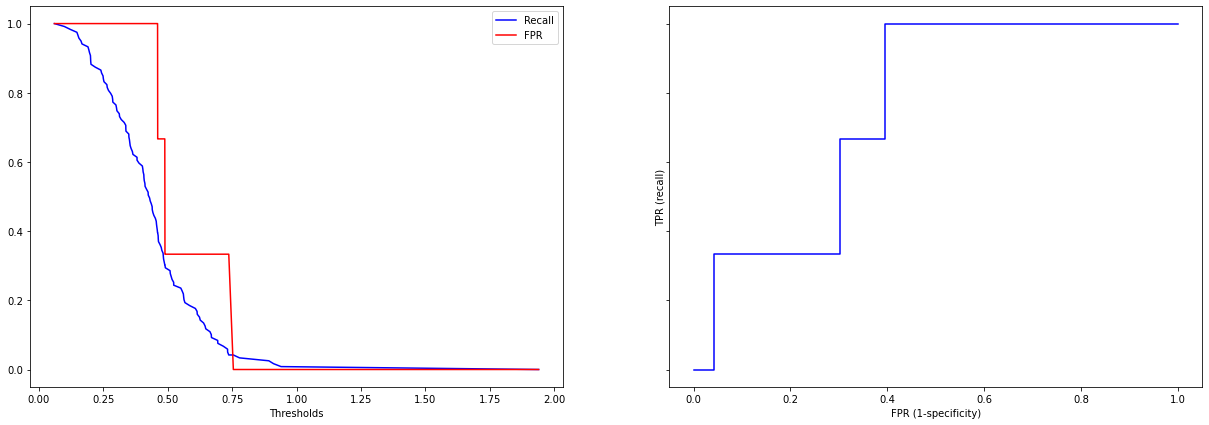

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.673879  0.574558   0.717037     0.773182  0.637870  0.742077
Validation  0.660514  0.540850   0.711046     0.780328  0.612891  0.725314


LogisticWeakRegularization
╠■■■■■■■■■╣


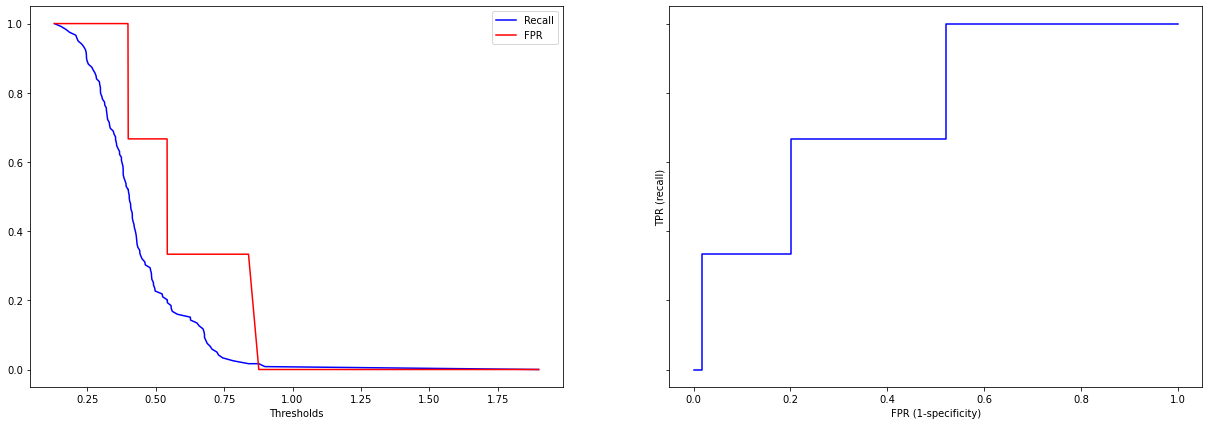

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.673880  0.574922   0.717053     0.772818  0.638040  0.745575
Validation  0.655564  0.544909   0.699871     0.766393  0.610556  0.729577


LogiscticAdaBoost
╠■■■■■■■■■╣


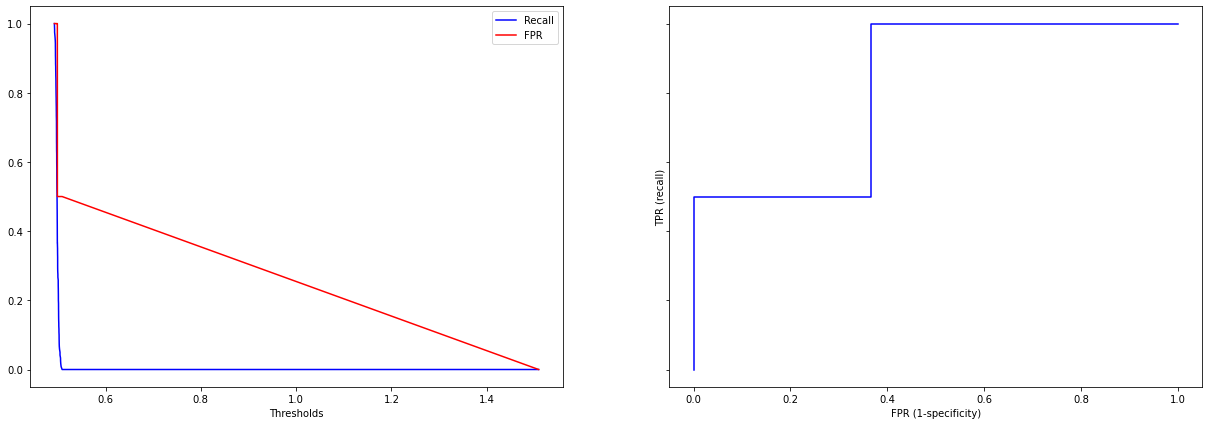

feature_importances
Unable to compute feature importances since base_estimator does not have a feature_importances_ attribute


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.679198  0.585470   0.720660     0.772909  0.645970  0.742791
Validation  0.664590  0.573524   0.702344     0.755738  0.628984  0.725996

In [45]:
run_models(X.drop(columns=["sys", "dia"]), y, ensemble_models, ratio_negatives_to_positives=1)

In [46]:
ada_configurations = {
    "Ada Vanilla" : AdaBoostClassifier(),
    "Ada Logistic" : AdaBoostClassifier(base_estimator=LogisticRegression()),
    "Ada algo" : AdaBoostClassifier(algorithm="SAMME"),
    "Ada learning rate" : AdaBoostClassifier(learning_rate=.5),
    "Ada complete" : AdaBoostClassifier(base_estimator=LogisticRegression(C=.5), algorithm="SAMME", learning_rate=.5)
    
}

Ada Vanilla
╠■■■■■■■■■╣


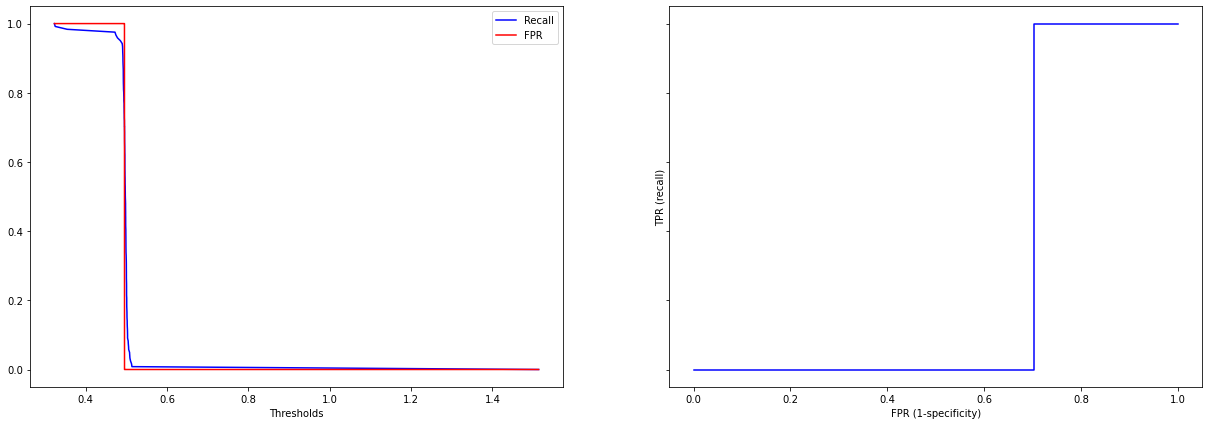

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.694289  0.615745   0.730606     0.772818  0.668073  0.768547
Validation  0.659266  0.570199   0.695158     0.748361  0.623604  0.721079


Ada Logistic
╠■■■■■■■■■╣


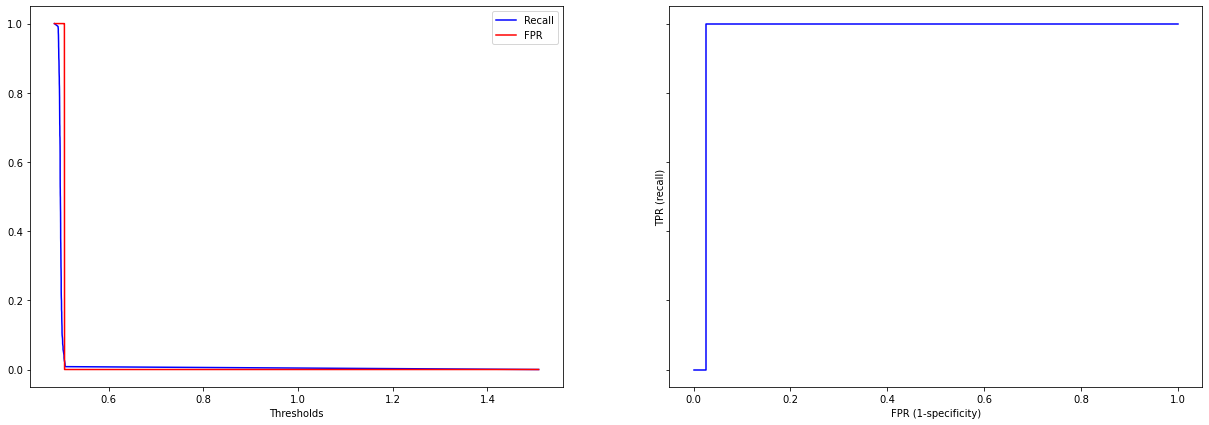

feature_importances
Unable to compute feature importances since base_estimator does not have a feature_importances_ attribute


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.677788  0.585649   0.718042     0.769909  0.645010  0.744536
Validation  0.666644  0.571072   0.705610     0.762295  0.629622  0.725068


Ada algo
╠■■■■■■■■■╣


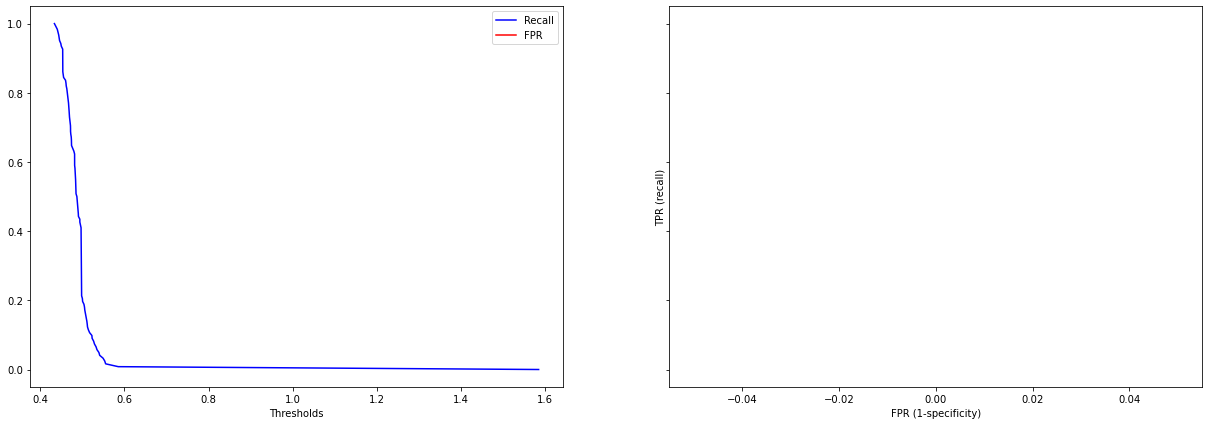

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.677379  0.609649   0.706835     0.745091  0.653176  0.739160
Validation  0.651890  0.571958   0.680254     0.731967  0.619384  0.706014


Ada learning rate
╠■■■■■■■■■╣


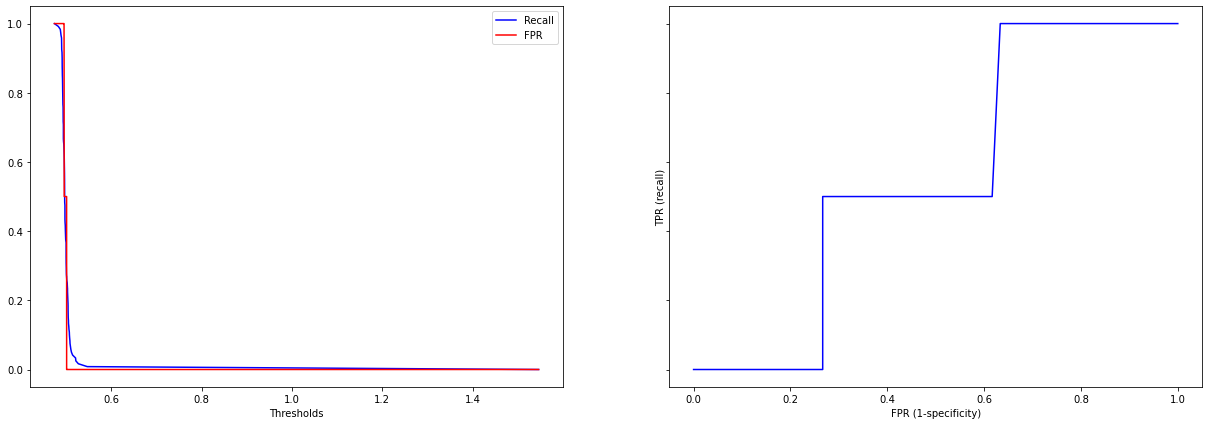

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.691062  0.584833   0.743103     0.797273  0.654005  0.765311
Validation  0.664180  0.547288   0.714427     0.781148  0.617526  0.729390


Ada complete
╠■■■■■■■■■╣


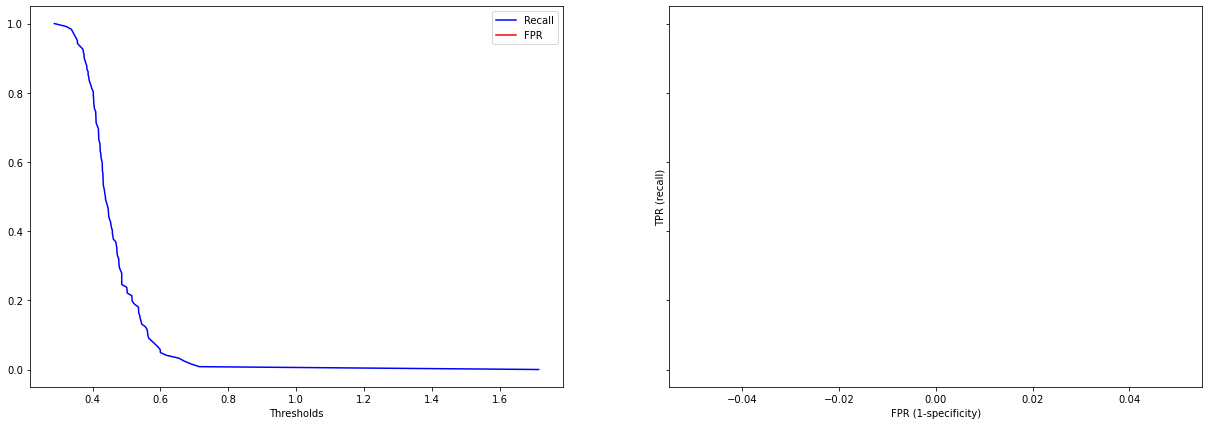

feature_importances
Unable to compute feature importances since base_estimator does not have a feature_importances_ attribute


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.663924  0.621109   0.679506     0.706727  0.648797  0.714149
Validation  0.657633  0.598127   0.677025     0.717213  0.632878  0.703147

In [47]:
run_models(X.drop(columns=["sys", "dia"]), y, ada_configurations, ratio_negatives_to_positives=1)

Ada Vanilla
╠■■■■■■■■■╣


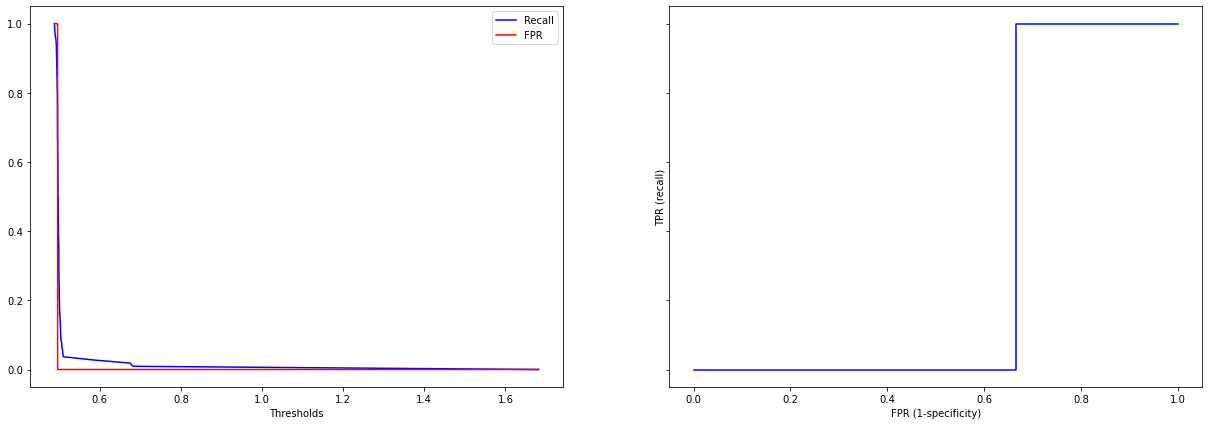

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.694953  0.593504   0.744641     0.796349  0.660321  0.767457
Validation  0.658563  0.566138   0.695641     0.751376  0.621647  0.713484


Ada Logistic
╠■■■■■■■■■╣


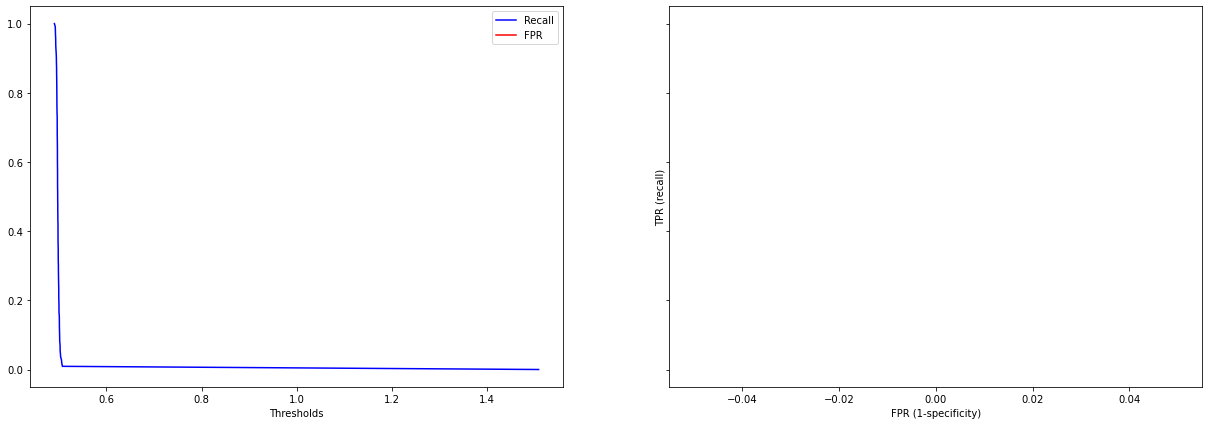

feature_importances
Unable to compute feature importances since base_estimator does not have a feature_importances_ attribute


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.676641  0.579395   0.719151     0.773834  0.641574  0.731737
Validation  0.668185  0.563470   0.712800     0.773394  0.626885  0.725582


Ada algo
╠■■■■■■■■■╣


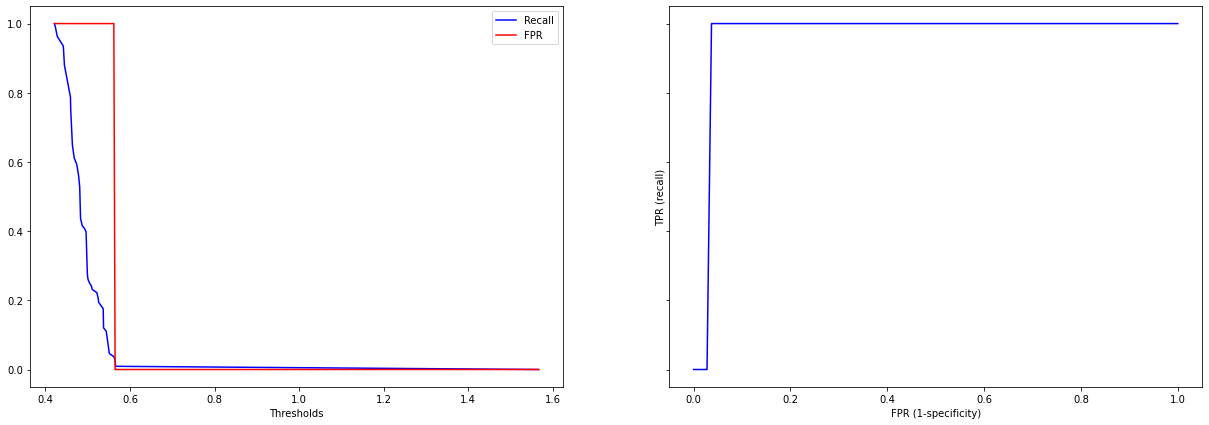

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.681714  0.569557   0.735290     0.793813  0.640996  0.737423
Validation  0.673677  0.553319   0.732038     0.794495  0.627172  0.716711


Ada learning rate
╠■■■■■■■■■╣


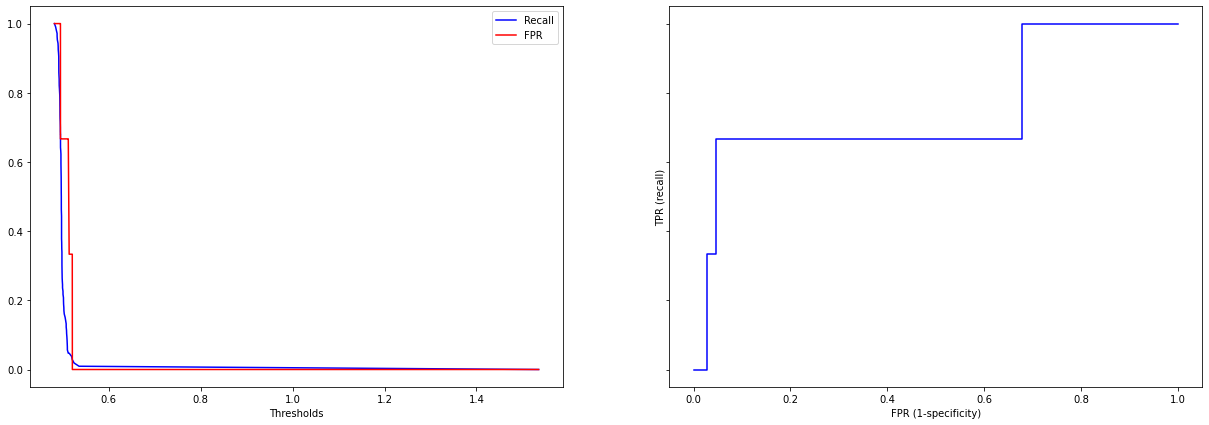

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.693178  0.579609   0.750622     0.806694  0.653779  0.761751
Validation  0.677768  0.561510   0.731198     0.794495  0.632729  0.720430


Ada complete
╠■■■■■■■■■╣


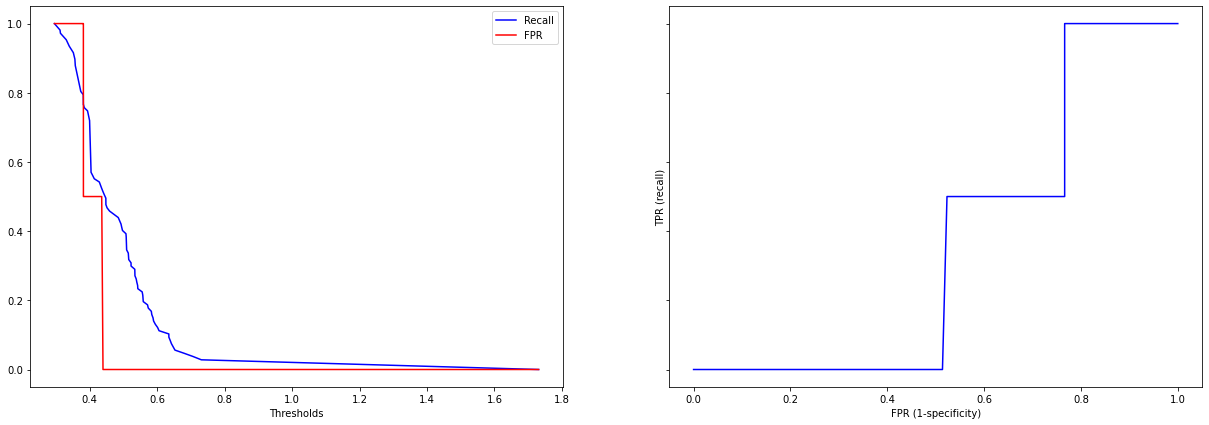

feature_importances
Unable to compute feature importances since base_estimator does not have a feature_importances_ attribute


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.663960  0.630642   0.676386     0.697262  0.652304  0.717488
Validation  0.637502  0.598991   0.649954     0.676147  0.621337  0.689558

In [48]:
run_models(ra_symptoms_vitals, y[ra_symptoms_vitals.index], ada_configurations, ratio_negatives_to_positives=1)

╠■■■■■■■■■╣
Threshold: 0.0
╠■■■■■■■■■╣
Threshold: 0.1
╠■■■■■■■■■╣
Threshold: 0.2
╠■■■■■■■■■╣
Threshold: 0.30000000000000004
╠■■■■■■■■■╣
Threshold: 0.4
╠■■■■■■■■■╣
Threshold: 0.5
╠■■■■■■■■■╣
Threshold: 0.6000000000000001
╠■■■■■■■■■╣
Threshold: 0.7000000000000001
╠■■■■■■■■■╣
Threshold: 0.8
╠■■■■■■■■■╣
Threshold: 0.9
╠■■■■■■■■■╣
Threshold: 1.0


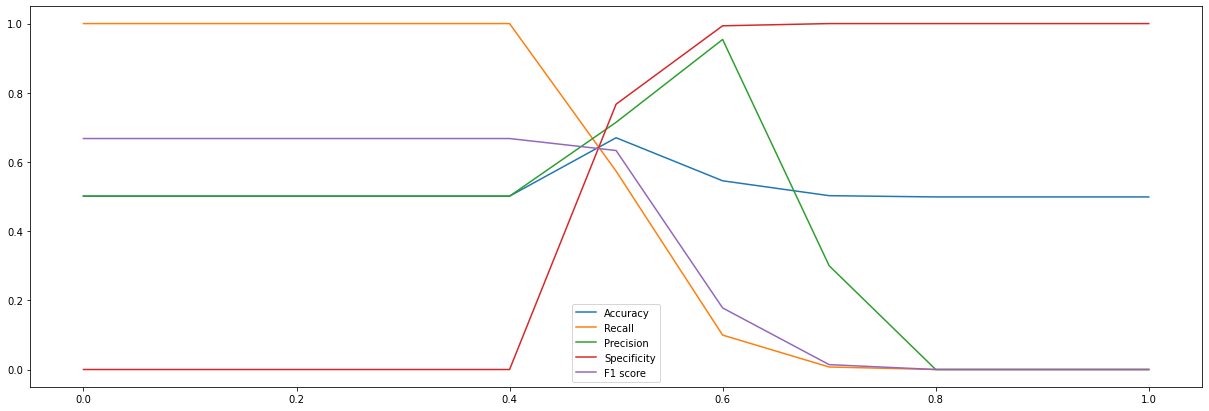

0.0       0.1       0.2       0.3       0.4       0.5  \
Accuracy     0.501142  0.501142  0.501142  0.501142  0.501142  0.669989   
Recall       1.000000  1.000000  1.000000  1.000000  1.000000  0.573411   
Precision    0.501142  0.501142  0.501142  0.501142  0.501142  0.714569   
Specificity  0.000000  0.000000  0.000000  0.000000  0.000000  0.766972   
F1           0.667680  0.667680  0.667680  0.667680  0.667680  0.633060   

                  0.6       0.7       0.8       0.9       1.0  
Accuracy     0.545524  0.502511  0.498858  0.498858  0.498858  
Recall       0.099458  0.007273  0.000000  0.000000  0.000000  
Precision    0.954009  0.300000  0.000000  0.000000  0.000000  
Specificity  0.993578  1.000000  1.000000  1.000000  1.000000  
F1           0.177984  0.014069  0.000000  0.000000  0.000000

In [88]:
run_threshold(ra_symptoms_vitals, y[ra_symptoms_vitals.index], ada_configurations["Ada algo"], ratio_negatives_to_positives=1)

╠■■■■■■■■■╣
Threshold: 0.47
╠■■■■■■■■■╣
Threshold: 0.475
╠■■■■■■■■■╣
Threshold: 0.48
╠■■■■■■■■■╣
Threshold: 0.485
╠■■■■■■■■■╣
Threshold: 0.49
╠■■■■■■■■■╣
Threshold: 0.495
╠■■■■■■■■■╣
Threshold: 0.5
╠■■■■■■■■■╣
Threshold: 0.505
╠■■■■■■■■■╣
Threshold: 0.51
╠■■■■■■■■■╣
Threshold: 0.515
╠■■■■■■■■■╣
Threshold: 0.52


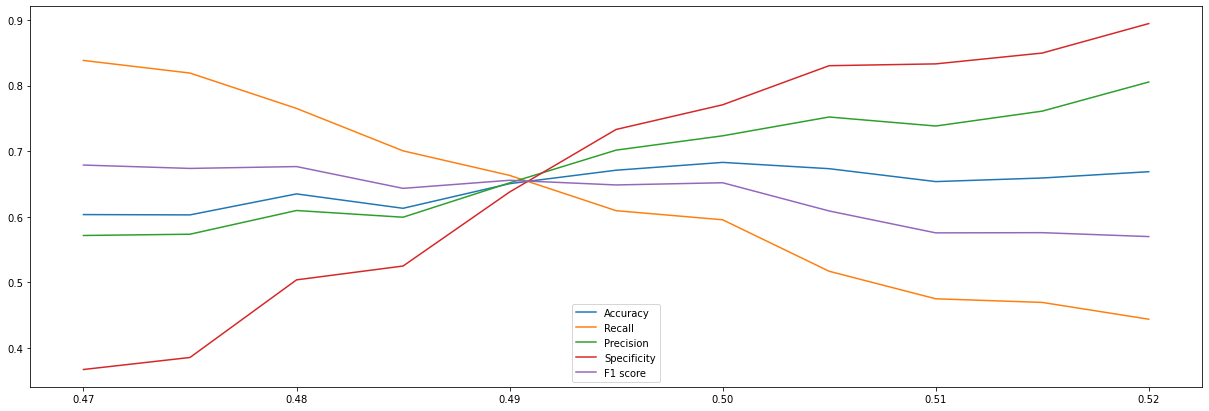

0.470     0.475     0.480     0.485     0.490     0.495  \
Accuracy     0.603217  0.602752  0.634762  0.612794  0.650367  0.670873   
Recall       0.838274  0.819041  0.765113  0.700425  0.663011  0.609183   
Precision    0.571339  0.573269  0.609443  0.599194  0.651562  0.701493   
Specificity  0.366972  0.385321  0.503670  0.524771  0.637615  0.733028   
F1           0.678738  0.673611  0.676445  0.643215  0.655531  0.648403   

                0.500     0.505     0.510     0.515     0.520  
Accuracy     0.682812  0.673210  0.653534  0.659011  0.668600  
Recall       0.595296  0.516781  0.474837  0.469283  0.443670  
Precision    0.723354  0.752027  0.738273  0.760977  0.805386  
Specificity  0.770642  0.830275  0.833028  0.849541  0.894495  
F1           0.651765  0.608740  0.575348  0.575640  0.569664

In [92]:
run_threshold(ra_symptoms_vitals, y[ra_symptoms_vitals.index], ada_configurations["Ada algo"], thresholds=np.linspace(0.47, 0.52, num=11), ratio_negatives_to_positives=1)

## Sidequest: Understanding logistic regression

In [ ]:
lr = LogisticRegression()
imp = Imputer()
imp.fit_transform(all_data, y[all_data.index])
lr.fit(all_data, y[all_data.index], sample_weight=(np.ones(y[all_data.index].shape) + (y[all_data.index]=="Negative")))

In [ ]:
lr_preds = lr.predict(all_data)

In [ ]:
manual_preds = np.dot(all_data, lr.coef_.transpose()) + lr.intercept_ #The dot product of coeficients and features plus the bias

In [ ]:
from math import exp
def logistic_function(value):
    return 1 / (1 + exp(-value))

In [ ]:
manual_preds.flatten()

In [ ]:
lfv = np.vectorize(logistic_function) #To vectorize means to apply it to vectors

In [ ]:
result = pd.Series(lfv(manual_preds).flatten())
result[result > .5] = "Positive"
result[result != "Positive"] = "Negative"

In [ ]:
a = np.array([[1,2,3,4,5],[2,4,6,8,10]])
b = np.ones((5,2))
b[:,1] *= 2

In [ ]:
np.dot(a, b)

In [ ]:
lfv(manual_preds)[lfv(manual_preds) > .5]

In [ ]:
explainer = shap.KernelExplainer(lr.predict_proba, np.zeros((1,all_data.columns.size)))

In [ ]:
shap_values = explainer.shap_values(all_data[y[all_data.index] == "Positive"].sample(1))

In [ ]:
shap_values

In [ ]:
shap.force_plot(explainer.expected_value[1], shap_values[1], all_data.columns)

In [ ]:
ra_symptoms_vitals.columns

In [ ]:
def calculate_shap_values(model, data_x):
    explainer = shap.KernelExplainer(model.predict_proba, np.zeros((1, data_x.shape[1])))
    sample = data_x.sample(1)
    shap.initjs()
    display(shap.force_plot(explainer.expected_value[1], explainer.shap_values(sample)[1], sample))

In [ ]:
lr.fit(all_data, y[all_data.index])
calculate_shap_values(lr, all_data)

In [ ]:
y[all_data.index].value_counts()

In [ ]:
all_data["sats"]